In [ ]:
# Ensure repo root is importable (for kaggle_evaluation)
import sys, os
repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)


# Hull Tactical · 시장 예측

이 대회는 Hull Tactical이 주최하며 참가자는 **S&P 500 지수의 일일 미래 수익률(forward returns)** 을 예측합니다.  
데이터셋은 여러 팩터 계열에 걸친 수십 년의 시장 정보를 제공합니다:

- **M\*** — 시장 동학 및 기술적 지표  
- **E\*** — 거시경제 지표  
- **I\*** — 금리 관련 특성  
- **P\*** — 가격/밸류에이션 지표  
- **V\*** — 변동성 지표  
- **S\*** — 심리/센티먼트 변수  
- **MOM\*** — 모멘텀 기반 지표  
- **D\*** — 더미/이진 특성  

타깃 변수는 `forward_returns`로, 오늘 매수하여 다음 날 매도했을 때의 수익률을 의미합니다.  
`risk_free_rate`, `market_forward_excess_returns` 등은 기대 대비 상대 성과를 포착하기 위해 포함됩니다.

대회는 **두 단계**로 진행됩니다:
1. **학습 단계** — 과거 데이터로 모델을 개발합니다. 공개 리더보드는 **모의 테스트 구간** 기반이라 의미가 크지 않습니다.  
2. **예측 단계** — Kaggle 평가 API로 실제 미공개 미래 데이터에 대해 평가합니다. 최종 리더보드는 이 단계 점수로 결정됩니다.

목표는 노이즈가 많은 금융 데이터에서 신호를 추출하면서 과적합을 피하는 **견고하고 일반화 가능한 모델**을 구축하는 것입니다.


### 라이브러리 임포트 및 설정
데이터 처리, 시각화, 특성 분석을 위한 필수 Python 라이브러리를 불러옵니다.  
- **pandas / numpy** — 데이터 가공과 수치 연산  
- **matplotlib / seaborn / plotly** — 정적/인터랙티브 시각화  
- **scipy.stats** — 통계 검정(예: 정규성 검정)  
- **scikit-learn** — `StandardScaler`, `PCA`, `mutual_info_regression` 등 전처리/특성 분석 도구  

경고 출력을 정리하고 기본 플로팅 스타일을 설정해 노트북 출력을 깔끔하고 일관되게 유지합니다.


In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import jarque_bera, shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. 데이터 로딩 및 초기 점검

대회에서 제공한 학습·테스트 데이터를 불러옵니다.  
이 섹션의 핵심 점검 항목:
- 두 데이터셋의 **크기(shape)** 와 학습 데이터의 **날짜 범위** 확인  
- **메모리 사용량**과 **데이터 타입** 요약으로 규모/구성 파악  
- 첫 몇 행을 확인해 특성 계열(M*, E*, I*, P*, V*, S*, MOM*, D*) 구조 파악  
- 학습 데이터의 **중복 행** 존재 여부 확인  

초기 점검은 데이터 무결성을 확인하고 심층 탐색 분석의 기반을 마련합니다.


In [6]:
def load_and_inspect_data():
    """Load and perform initial inspection of the dataset"""
    
    print("🔍 데이터 로딩 및 점검")
    print("="*50)
    
    # Load datasets
    train_df = pd.read_csv('../data/train.csv')
    test_df = pd.read_csv('../data/test.csv')
    
    print(f"📊 학습 데이터 크기: {train_df.shape}")
    print(f"📊 테스트 데이터 크기: {test_df.shape}")
    print(f"📅 날짜 범위: {train_df['date_id'].min()} to {train_df['date_id'].max()}")
    
    # Basic info about the datasets
    print("\n📋 학습 데이터 정보:")
    print(f"Memory usage: {train_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"데이터 타입 분포:")
    print(train_df.dtypes.value_counts())
    
    # Display first few rows
    print("\n🔍 학습 데이터 상위 5행:")
    display(train_df.head())
    
    # Check for duplicates
    duplicates = train_df.duplicated().sum()
    print(f"\n🔍 학습 데이터 중복 행 수: {duplicates}")
    
    return train_df, test_df

train_df, test_df = load_and_inspect_data()

🔍 데이터 로딩 및 점검
📊 학습 데이터 크기: (8990, 98)
📊 테스트 데이터 크기: (10, 99)
📅 날짜 범위: 0 to 8989

📋 학습 데이터 정보:
Memory usage: 6.72 MB
데이터 타입 분포:
float64    88
int64      10
Name: count, dtype: int64

🔍 학습 데이터 상위 5행:


date_id  D1  D2  D3  D4  D5  D6  D7  D8  D9  ...  V3  V4  V5  V6  V7  V8  \
0        0   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
1        1   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
2        2   0   0   0   1   0   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
3        3   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   
4        4   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   

   V9  forward_returns  risk_free_rate  market_forward_excess_returns  
0 NaN        -0.002421        0.000301                      -0.003038  
1 NaN        -0.008495        0.000303                      -0.009114  
2 NaN        -0.009624        0.000301                      -0.010243  
3 NaN         0.004662        0.000299                       0.004046  
4 NaN        -0.011686        0.000299                      -0.012301  

[5 rows x 98 columns]


🔍 학습 데이터 중복 행 수: 0


# 2. 결측치 분석

금융 시계열 모델링에서 결측 구조 파악은 매우 중요합니다. 본 함수는 데이터셋의 **결측 현황을 종합적으로 요약**합니다:  

1. **전체 통계**  
   - 데이터 전반의 결측치 총합  
   - 전체 셀 대비 결측 비율  

2. **컬럼 단위 결측**  
   - 결측이 많은 상위 20개 컬럼 표시  
   - 특정 특성이 체계적으로 희소한지 파악  

3. **시각적 진단**  
   - **히트맵(처음 50개 컬럼):** 컬럼/시점별 결측 패턴을 한눈에 확인  
   - **상위 20개 컬럼 막대차트:** 삭제/대체 여부 판단에 도움  
   - **시간 흐름별 결측(라인):** `date_id`에 따른 결측 추이, 휴장/장애/구조 변화 등 단서  
   - **시간 흐름별 결측 비율:** 데이터 크기 변화에 대한 정규화 관점 제공  



🕳️ 결측치 분석
Total missing values: 137,675 (15.63% of all cells)

📊 결측치 상위 20개 컬럼:


Missing_Count  Missing_Percentage
E7            6969           77.519466
V10           6049           67.285873
S3            5733           63.770857
M1            5547           61.701891
M13           5540           61.624027
M14           5540           61.624027
M6            5043           56.095662
V9            4539           50.489433
S12           3537           39.343715
M5            3283           36.518354
M2            3217           35.784205
S8            3009           33.470523
M3            2018           22.447164
E1            1784           19.844271
P6            1638           18.220245
E20           1616           17.975528
P7            1616           17.975528
P5            1574           17.508343
V5            1512           16.818687
S5            1511           16.807564

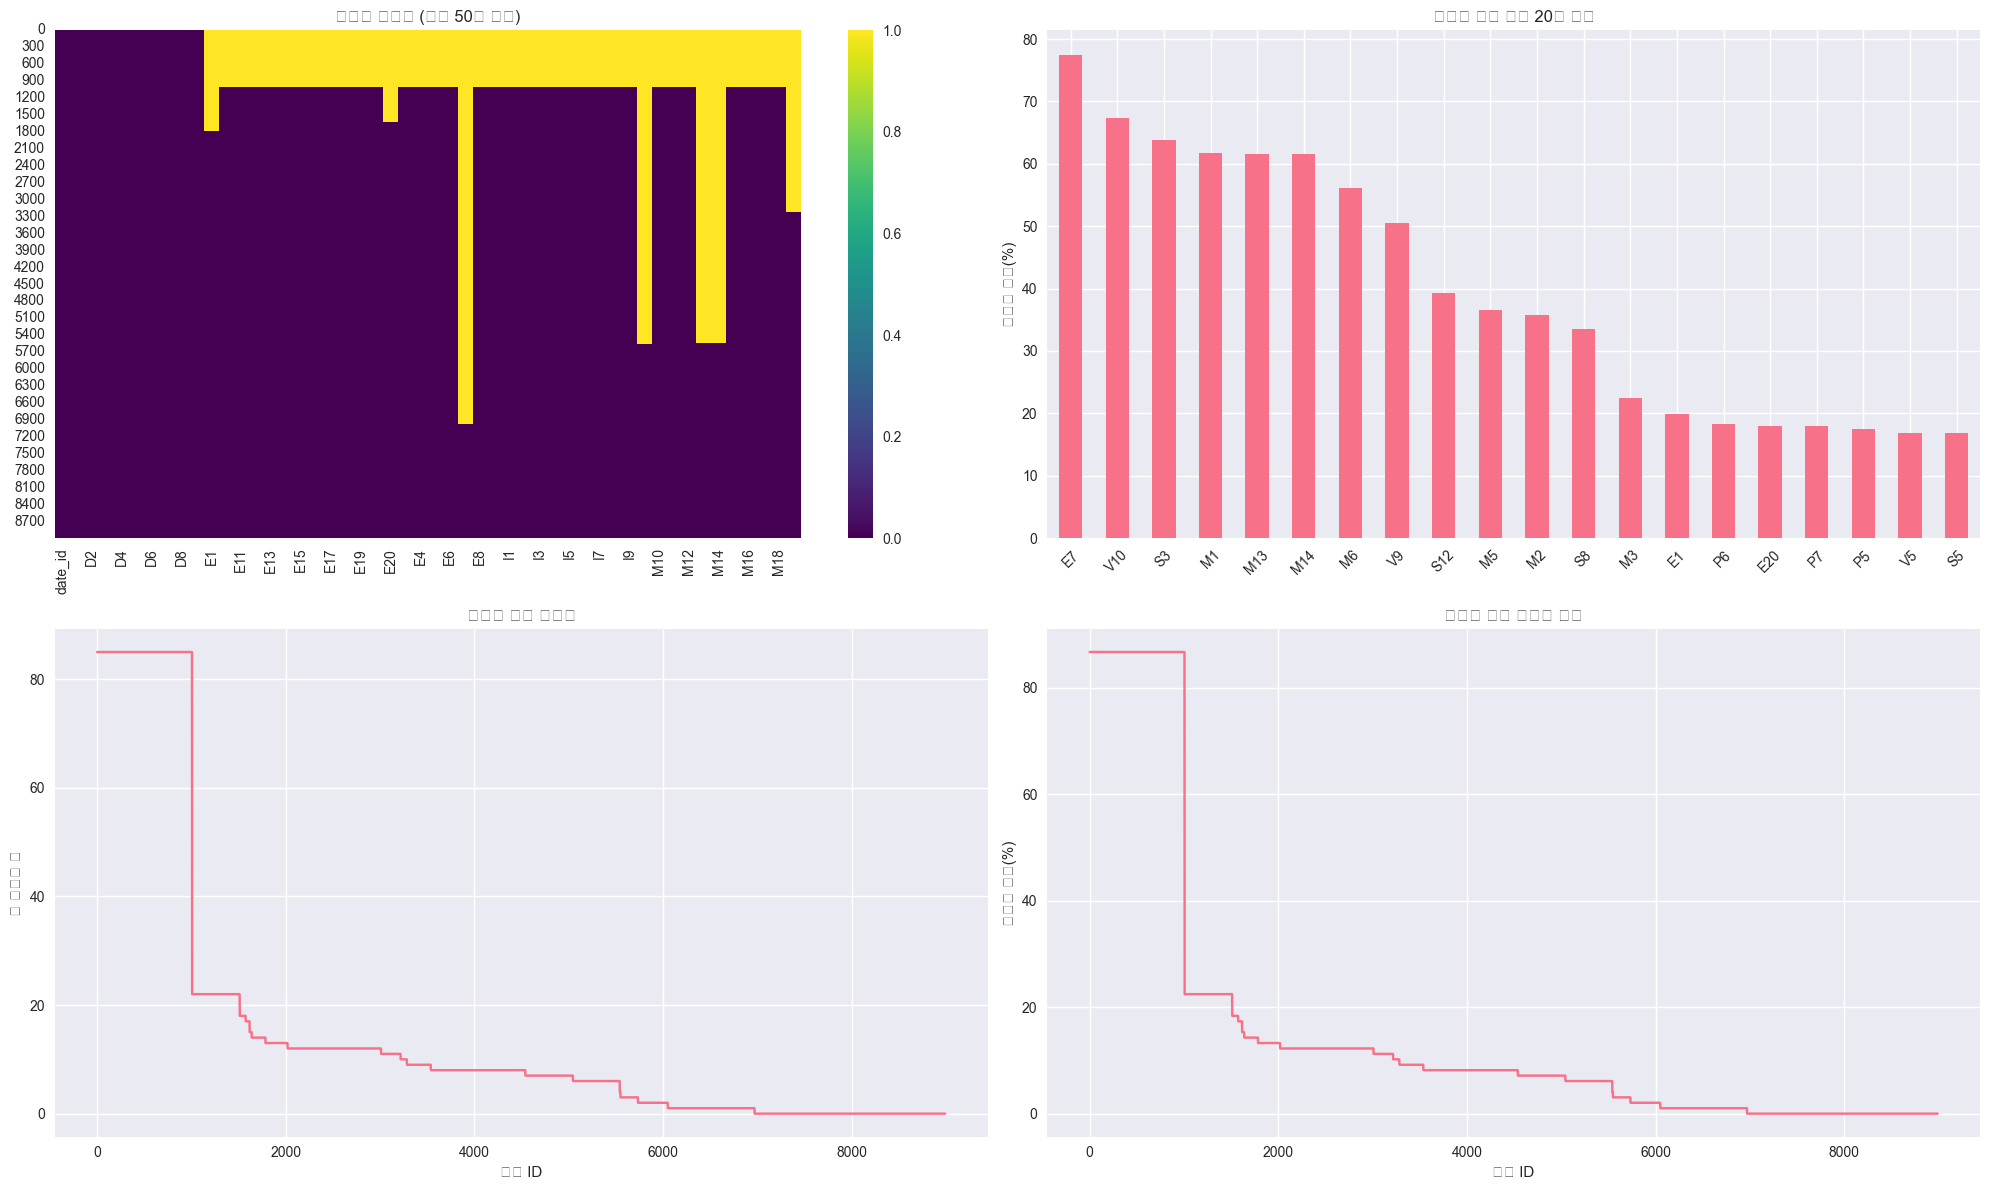

In [7]:
def analyze_missing_values(df):
    """Comprehensive missing values analysis"""
    
    print("\n🕳️ 결측치 분석")
    print("="*50)
    
    # Overall missing statistics
    total_cells = df.shape[0] * df.shape[1]
    total_missing = df.isnull().sum().sum()
    missing_percentage = (total_missing / total_cells) * 100
    
    print(f"Total missing values: {total_missing:,} ({missing_percentage:.2f}% of all cells)")
    
    # Missing values per column
    missing_data = df.isnull().sum().sort_values(ascending=False)
    missing_data = missing_data[missing_data > 0]
    
    if len(missing_data) > 0:
        missing_percent = (missing_data / len(df)) * 100
        missing_df = pd.DataFrame({
            'Missing_Count': missing_data,
            'Missing_Percentage': missing_percent
        })
        
        print(f"\n📊 결측치 상위 20개 컬럼:")
        display(missing_df.head(20))
        
        # Visualize missing values pattern
        if len(missing_data) > 0:
            fig, axes = plt.subplots(2, 2, figsize=(20, 12))
            
            # Missing values heatmap
            missing_matrix = df.isnull()
            sns.heatmap(missing_matrix.iloc[:, :50], cbar=True, ax=axes[0,0], cmap='viridis')
            axes[0,0].set_title('결측치 히트맵 (처음 50개 컬럼)')
            
            # Missing values bar chart
            top_missing = missing_df.head(20)
            top_missing['Missing_Percentage'].plot(kind='bar', ax=axes[0,1])
            axes[0,1].set_title('결측치 비율 상위 20개 컬럼')
            axes[0,1].set_ylabel('결측치 비율(%)')
            plt.setp(axes[0,1].xaxis.get_majorticklabels(), rotation=45)
            
            # Missing values over time
            if 'date_id' in df.columns:
                missing_by_date = df.groupby('date_id').apply(lambda x: x.isnull().sum().sum())
                axes[1,0].plot(missing_by_date.index, missing_by_date.values)
                axes[1,0].set_title('시간에 따른 결측치')
                axes[1,0].set_xlabel('날짜 ID')
                axes[1,0].set_ylabel('총 결측치 수')
                
                # Missing percentage by date
                missing_pct_by_date = (missing_by_date / df.shape[1]) * 100
                axes[1,1].plot(missing_pct_by_date.index, missing_pct_by_date.values)
                axes[1,1].set_title('시간에 따른 결측치 비율')
                axes[1,1].set_xlabel('날짜 ID')
                axes[1,1].set_ylabel('결측치 비율(%)')
            
            plt.tight_layout()
            plt.show()
    
    return missing_data

missing_analysis = analyze_missing_values(train_df)

### 🔎 결측치 분석 요약  

- **전체 결측:**  
  데이터 전반에 **137,675개 결측**(전체 셀의 **15.63%**)이 존재합니다. 모델 성능에 영향을 줄 수 있어 신중한 처리가 필요합니다.  

- **결측 상위 특성:**  
  다음 컬럼에서 결측 비율이 높게 관찰됩니다:  
  - `E7` → 77.5%  
  - `V10` → 67.3%  
  - `S3` → 63.8%  
  - `M1`, `M13`, `M14` → 각 ~61.6%  

  이들 특성은 **제거 후보**(중복/저신호) 또는 **특별 대체** 후보(도메인 상 중요)입니다.  

- **중간 정도 결측(30–50%)**  
  `M6`, `V9`, `S12` 등. 적절한 대체 후 신호가 남을 수 있으나, 부적절 처리 시 노이즈 증가 위험.  

- **경미한 결측(<25%)**  
  `E1`, `P6`, `E20`, `P7`, `P5`, `V5`, `S5` 등(16–22%). **견고한 대체 전략**을 적용하면 유지 가치가 큽니다.  


# 3. 특성 분류 및 분석


In [8]:
def categorize_features(df):
    """Categorize features based on their prefixes"""
    
    print("\n🏷️ 특성 분류")
    print("="*50)
    
    feature_categories = {}
    
    # Define feature categories based on prefixes
    categories = {
        'Market_Dynamics': 'M',
        'Macro_Economic': 'E',
        'Interest_Rate': 'I',
        'Price_Valuation': 'P',
        'Volatility': 'V',
        'Sentiment': 'S',
        'Momentum': 'MOM',
        'Dummy_Binary': 'D'
    }
    
    # Categorize features
    for category, prefix in categories.items():
        if prefix == 'MOM':
            feature_categories[category] = [col for col in df.columns if col.startswith(prefix)]
        else:
            feature_categories[category] = [col for col in df.columns if col.startswith(prefix) and not col.startswith('MOM')]
    
    # Special columns
    special_cols = ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
    feature_categories['Special'] = [col for col in special_cols if col in df.columns]
    
    # Display categorization
    total_features = 0
    for category, features in feature_categories.items():
        print(f"📊 {category}: {len(features)} features")
        total_features += len(features)
    
    print(f"\n📈 Total categorized features: {total_features}")
    print(f"📈 Total columns in dataset: {df.shape[1]}")
    
    return feature_categories

feature_categories = categorize_features(train_df)


🏷️ 특성 분류
📊 Market_Dynamics: 18 features
📊 Macro_Economic: 20 features
📊 Interest_Rate: 9 features
📊 Price_Valuation: 13 features
📊 Volatility: 13 features
📊 Sentiment: 12 features
📊 Momentum: 0 features
📊 Dummy_Binary: 9 features
📊 Special: 4 features

📈 Total categorized features: 98
📈 Total columns in dataset: 98


### 📊 분류 결과  

총 **98개 특성**이 도메인별 카테고리로 매핑되었습니다:  

- **시장 동학(18개):** 스프레드, 유동성, 마켓 내부지표 등  
- **거시경제(20개):** 고용, 인플레이션, 성장 대리변수 등  
- **금리(9개):** 수익률 곡선 및 금리 민감 변수  
- **가격/밸류에이션(13개):** 상대 가치 및 밸류에이션 비율  
- **변동성(13개):** 실현/내재 변동성, 불확실성 지표  
- **센티먼트(12개):** 설문, 행동·심리 지표  
- **모멘텀(0개):** 제공되지 않음 — 다른 특성에 간접 내재 가능성  
- **더미/이진(9개):** 구조 플래그 및 범주 인코딩  
- **특수(4개):** `date_id`, `forward_returns`, `risk_free_rate`, `market_forward_excess_returns`  

📌 **인사이트:**  
1. 데이터셋은 거시/심리/변동성 등 **여러 차원을 고르게 포함**.  
2. **명시적 모멘텀 부재** — 다른 그룹이 간접적으로 포착할지 관찰 가치.  
3. **특수 컬럼**은 예측 대상(`forward_returns`)과 평가 프레임(시장 초과수익/무위험수익)을 명확히 정의.  


# 4. 타깃 변수 분석



🎯 TARGET VARIABLE ANALYSIS

📊 FORWARD_RETURNS Statistics:
Count: 8,990
Mean: 0.000469
Std: 0.010551
Min: -0.039754
25%: -0.004324
50%: 0.000659
75%: 0.005900
Max: 0.040661
Skewness: -0.176202
Kurtosis: 2.192690
Jarque-Bera test p-value: 0.000000 (Not Normal)

📊 RISK_FREE_RATE Statistics:
Count: 8,990
Mean: 0.000107
Std: 0.000088
Min: -0.000004
25%: 0.000008
50%: 0.000095
75%: 0.000193
Max: 0.000317
Skewness: 0.218248
Kurtosis: -1.267292
Jarque-Bera test p-value: 0.000000 (Not Normal)

📊 MARKET_FORWARD_EXCESS_RETURNS Statistics:
Count: 8,990
Mean: 0.000051
Std: 0.010568
Min: -0.040582
25%: -0.004759
50%: 0.000252
75%: 0.005479
Max: 0.040551
Skewness: -0.177948
Kurtosis: 2.238481
Jarque-Bera test p-value: 0.000000 (Not Normal)


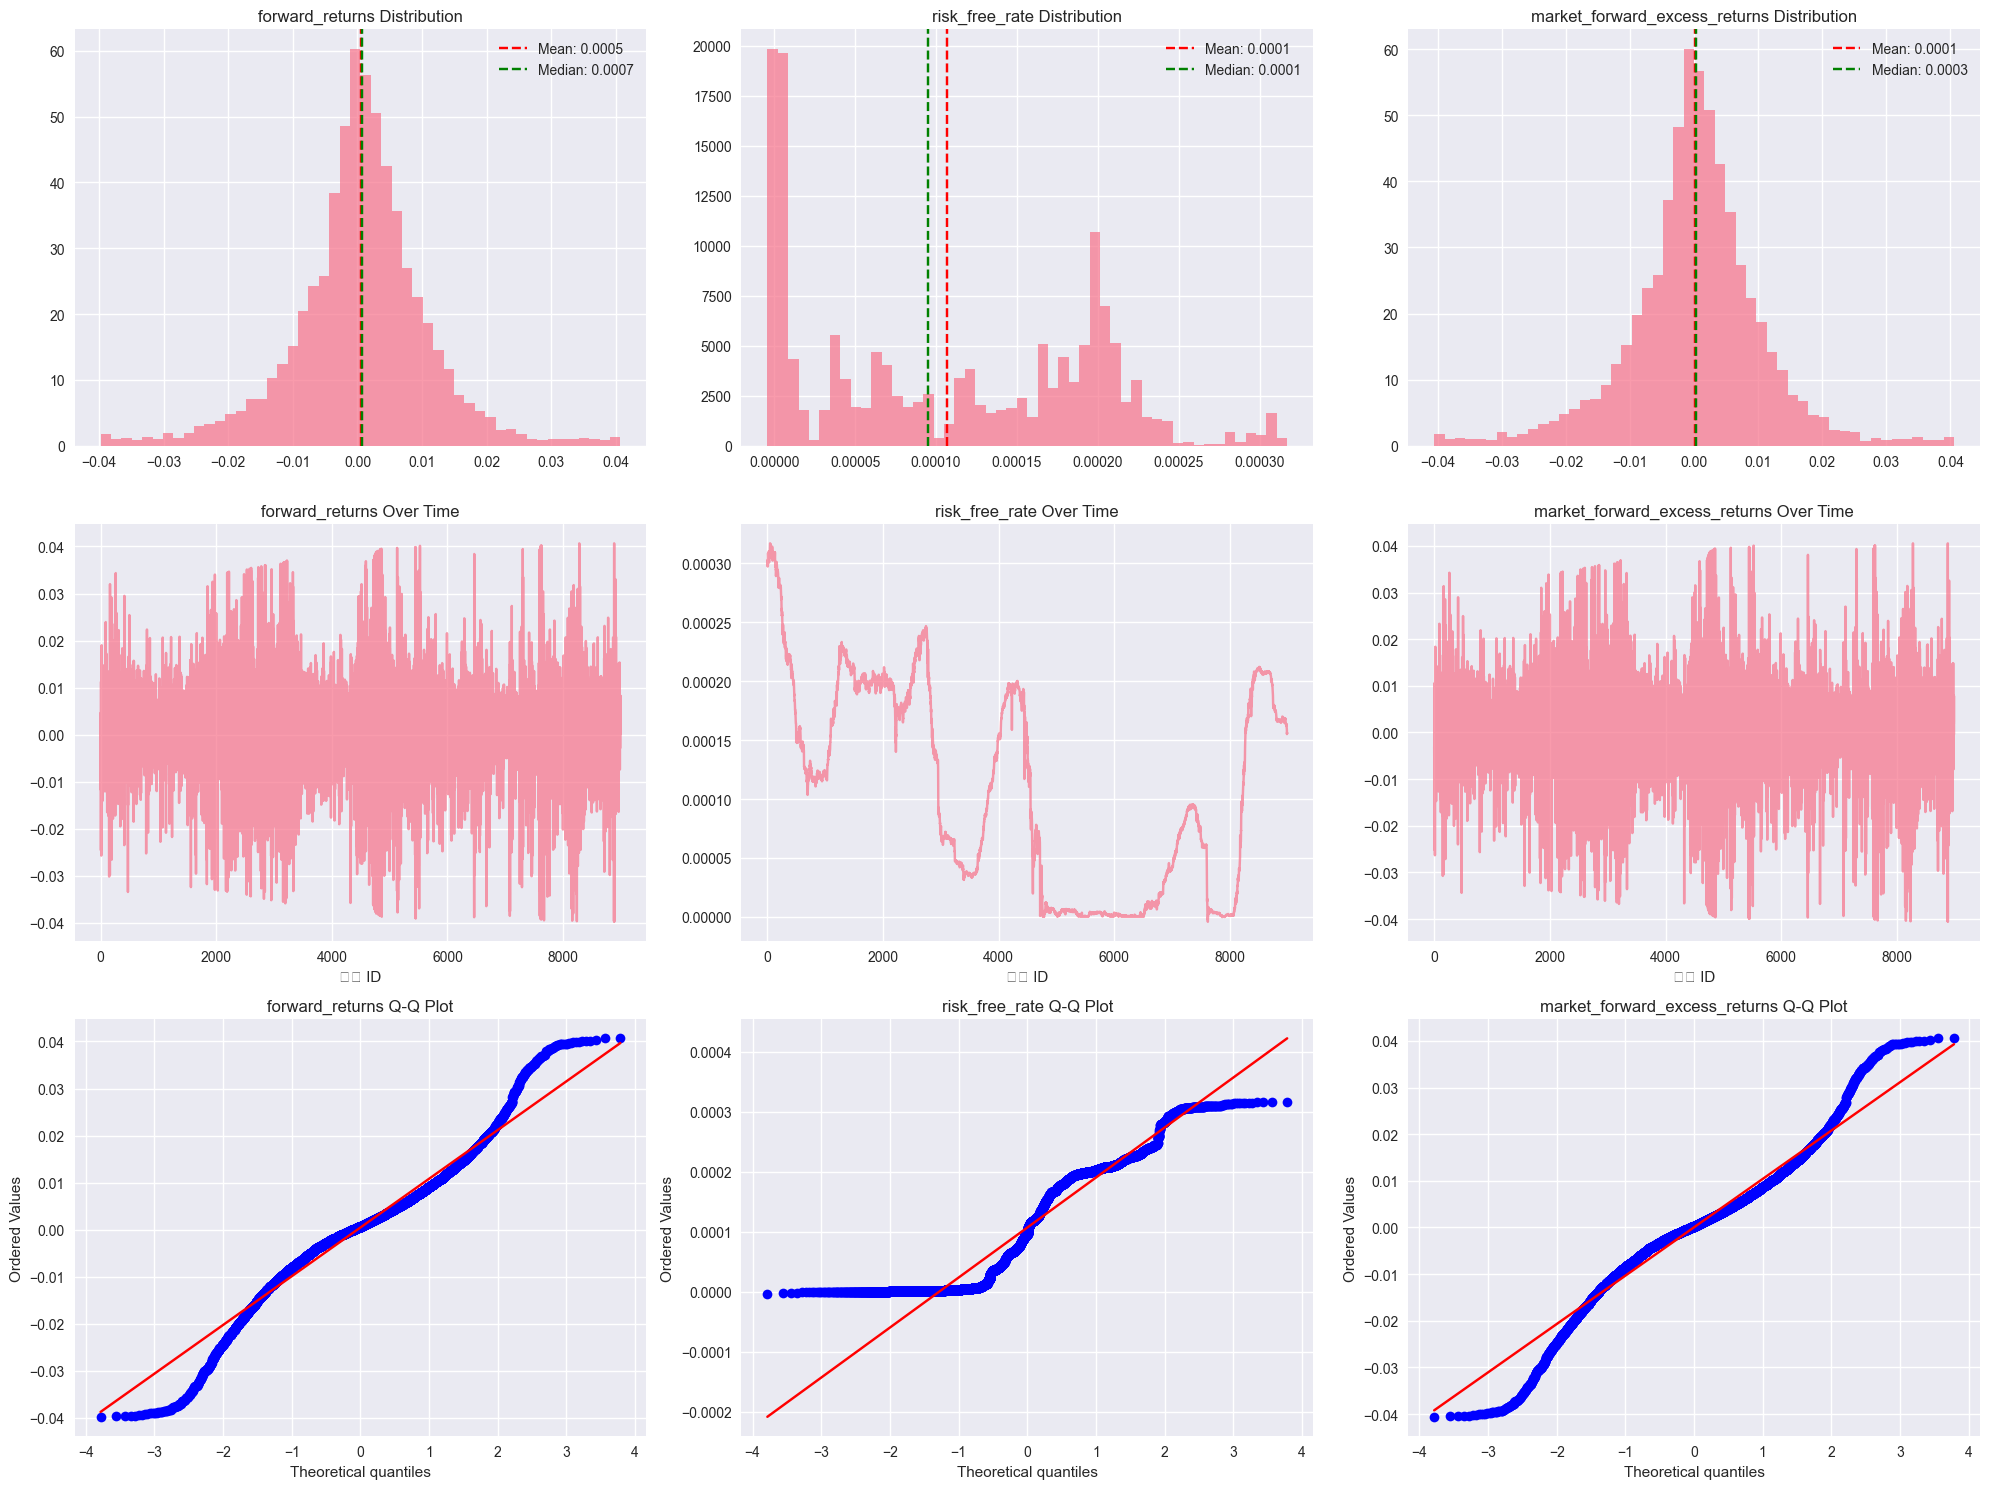

In [9]:
def analyze_target_variable(df):
    """Comprehensive analysis of target variables"""
    
    print("\n🎯 TARGET VARIABLE ANALYSIS")
    print("="*50)
    
    target_cols = ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
    target_cols = [col for col in target_cols if col in df.columns]
    
    fig, axes = plt.subplots(3, len(target_cols), figsize=(20, 15))
    if len(target_cols) == 1:
        axes = axes.reshape(-1, 1)
    
    for i, col in enumerate(target_cols):
        if col in df.columns:
            data = df[col].dropna()
            
            print(f"\n📊 {col.upper()} Statistics:")
            print(f"Count: {len(data):,}")
            print(f"Mean: {data.mean():.6f}")
            print(f"Std: {data.std():.6f}")
            print(f"Min: {data.min():.6f}")
            print(f"25%: {data.quantile(0.25):.6f}")
            print(f"50%: {data.median():.6f}")
            print(f"75%: {data.quantile(0.75):.6f}")
            print(f"Max: {data.max():.6f}")
            print(f"Skewness: {data.skew():.6f}")
            print(f"Kurtosis: {data.kurtosis():.6f}")
            
            # Distribution plot
            axes[0, i].hist(data, bins=50, alpha=0.7, density=True)
            axes[0, i].axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.4f}')
            axes[0, i].axvline(data.median(), color='green', linestyle='--', label=f'Median: {data.median():.4f}')
            axes[0, i].set_title(f'{col} Distribution')
            axes[0, i].legend()
            
            # Time series plot
            if 'date_id' in df.columns:
                axes[1, i].plot(df['date_id'], df[col], alpha=0.7)
                axes[1, i].set_title(f'{col} Over Time')
                axes[1, i].set_xlabel('날짜 ID')
            
            # Q-Q plot for normality check
            stats.probplot(data, dist="norm", plot=axes[2, i])
            axes[2, i].set_title(f'{col} Q-Q Plot')
            
            # Statistical tests
            jb_stat, jb_pvalue = jarque_bera(data)
            print(f"Jarque-Bera test p-value: {jb_pvalue:.6f} ({'Normal' if jb_pvalue > 0.05 else 'Not Normal'})")
    
    plt.tight_layout()
    plt.show()
    
    return target_cols

target_analysis = analyze_target_variable(train_df)

### 🎯 타깃 변수 분석  

본 데이터셋의 핵심 열 세 가지에 주목합니다:  

1. **forward_returns** → 다음 날 S&P 500 수익률(예측 대상)  
2. **risk_free_rate** → 연준 기준금리 등 자본의 기준 비용  
3. **market_forward_excess_returns** → 장기 기대 대비 초과수익(롤링 평균/MAD 윈저화 반영)  

#### 핵심 결과:  

- **Forward Returns**  
  - 평균 ≈ 0.00047로 0 근처에 집중(일수익 특성)  
  - 표준편차 ≈ 1% (일간 변동성 수준)  
  - 약한 음의 왜도(-0.18) — 하락 꼬리가 다소 두꺼움  
  - 첨도 ≈ 2.19 → 정규분포보다 얕은 꼬리  
  - **정규성 기각**(Jarque-Bera p < 0.05)  

- **Risk-Free Rate**  
  - 일 단위 변화가 매우 작음(평균 ≈ 0.0001)  
  - 수익률 대비 변동성 미미  
  - 음의 초과첨도(-1.27) — 정규보다 평평한 분포  
  - 역시 **정규 아님**(영향은 상대적으로 적음)  

- **Market Forward Excess Returns**  
  - `forward_returns`와 유사(평균 ≈ 0.00005)  
  - 표준편차 ≈ 1% — 원시 수익률의 추세 제거 관점  
  - 약한 음의 왜도(-0.18), 첨도 ≈ 2.24  
  - 통계적으로 **정규 아님**  

#### 시각적 요약:  
- **히스토그램** — 0 부근 집중, 꼬리는 비정규  
- **시계열 그래프** — 변동성 군집(평온/격동 시기)  
- **Q-Q 플롯** — 비정규 꼬리 확인(금융 시계열의 전형적 특성)  

📌 **모델링 시사점:**  
정규성 가정 선형모형은 한계가 있을 수 있습니다.  
- 로버스트 손실(Huber, 분위수 회귀)  
- 비선형 모델(트리 기반, 신경망)  
- 변동성/테일 리스크 중심의 특성 공학  


# 5. 특성 분포 분석



📊 FEATURE DISTRIBUTION ANALYSIS

🔍 Analyzing Market_Dynamics features (18 total)


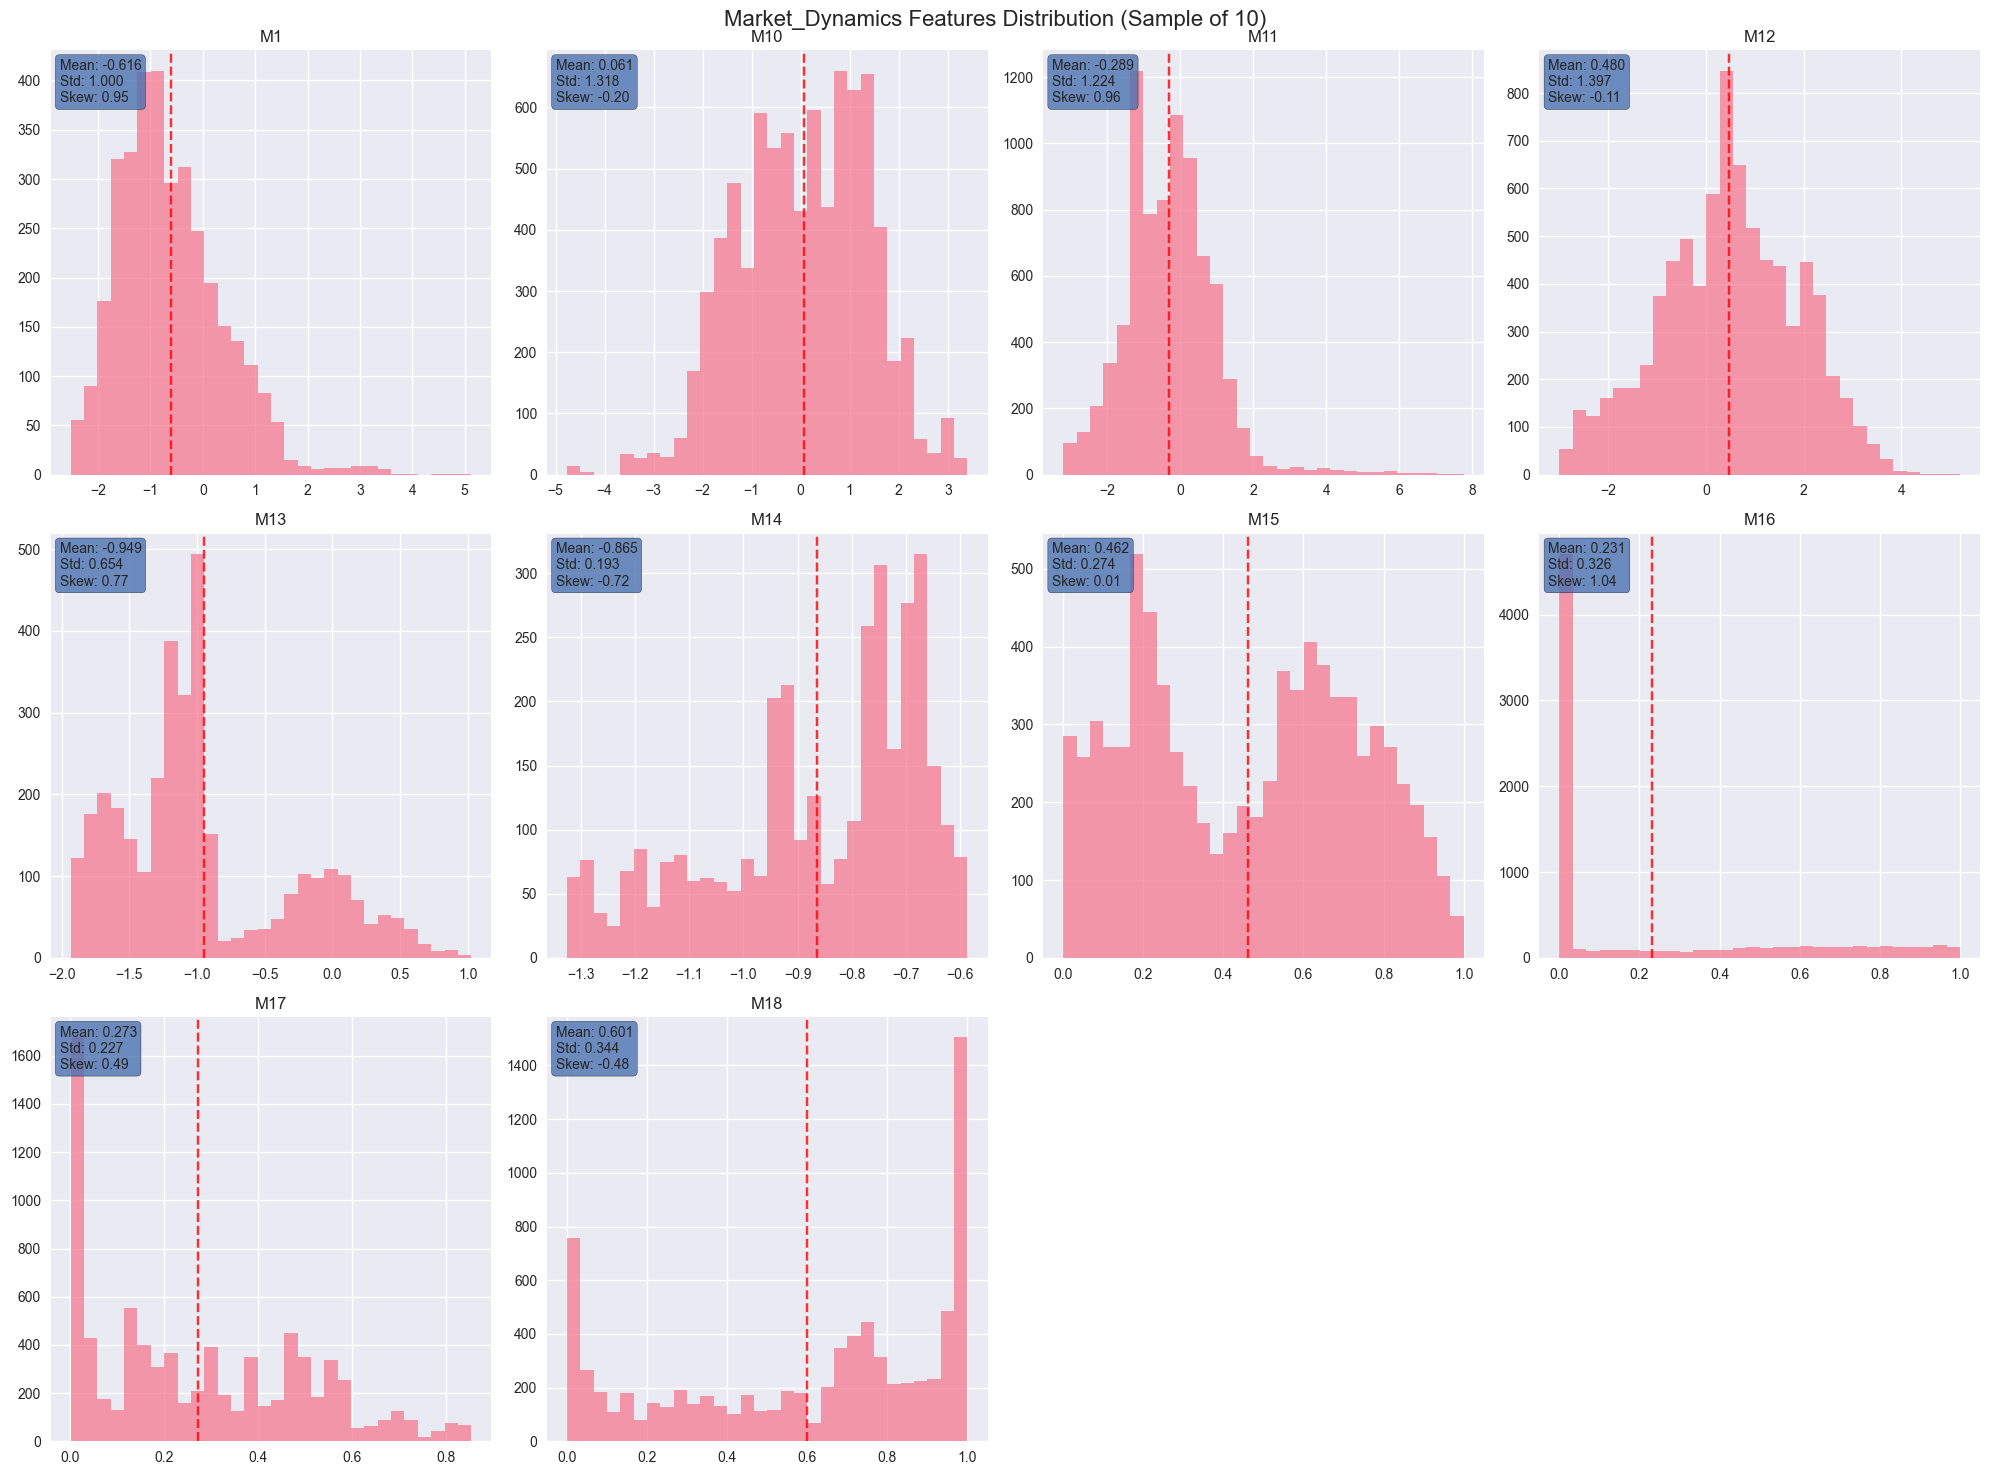


🔍 Analyzing Macro_Economic features (20 total)


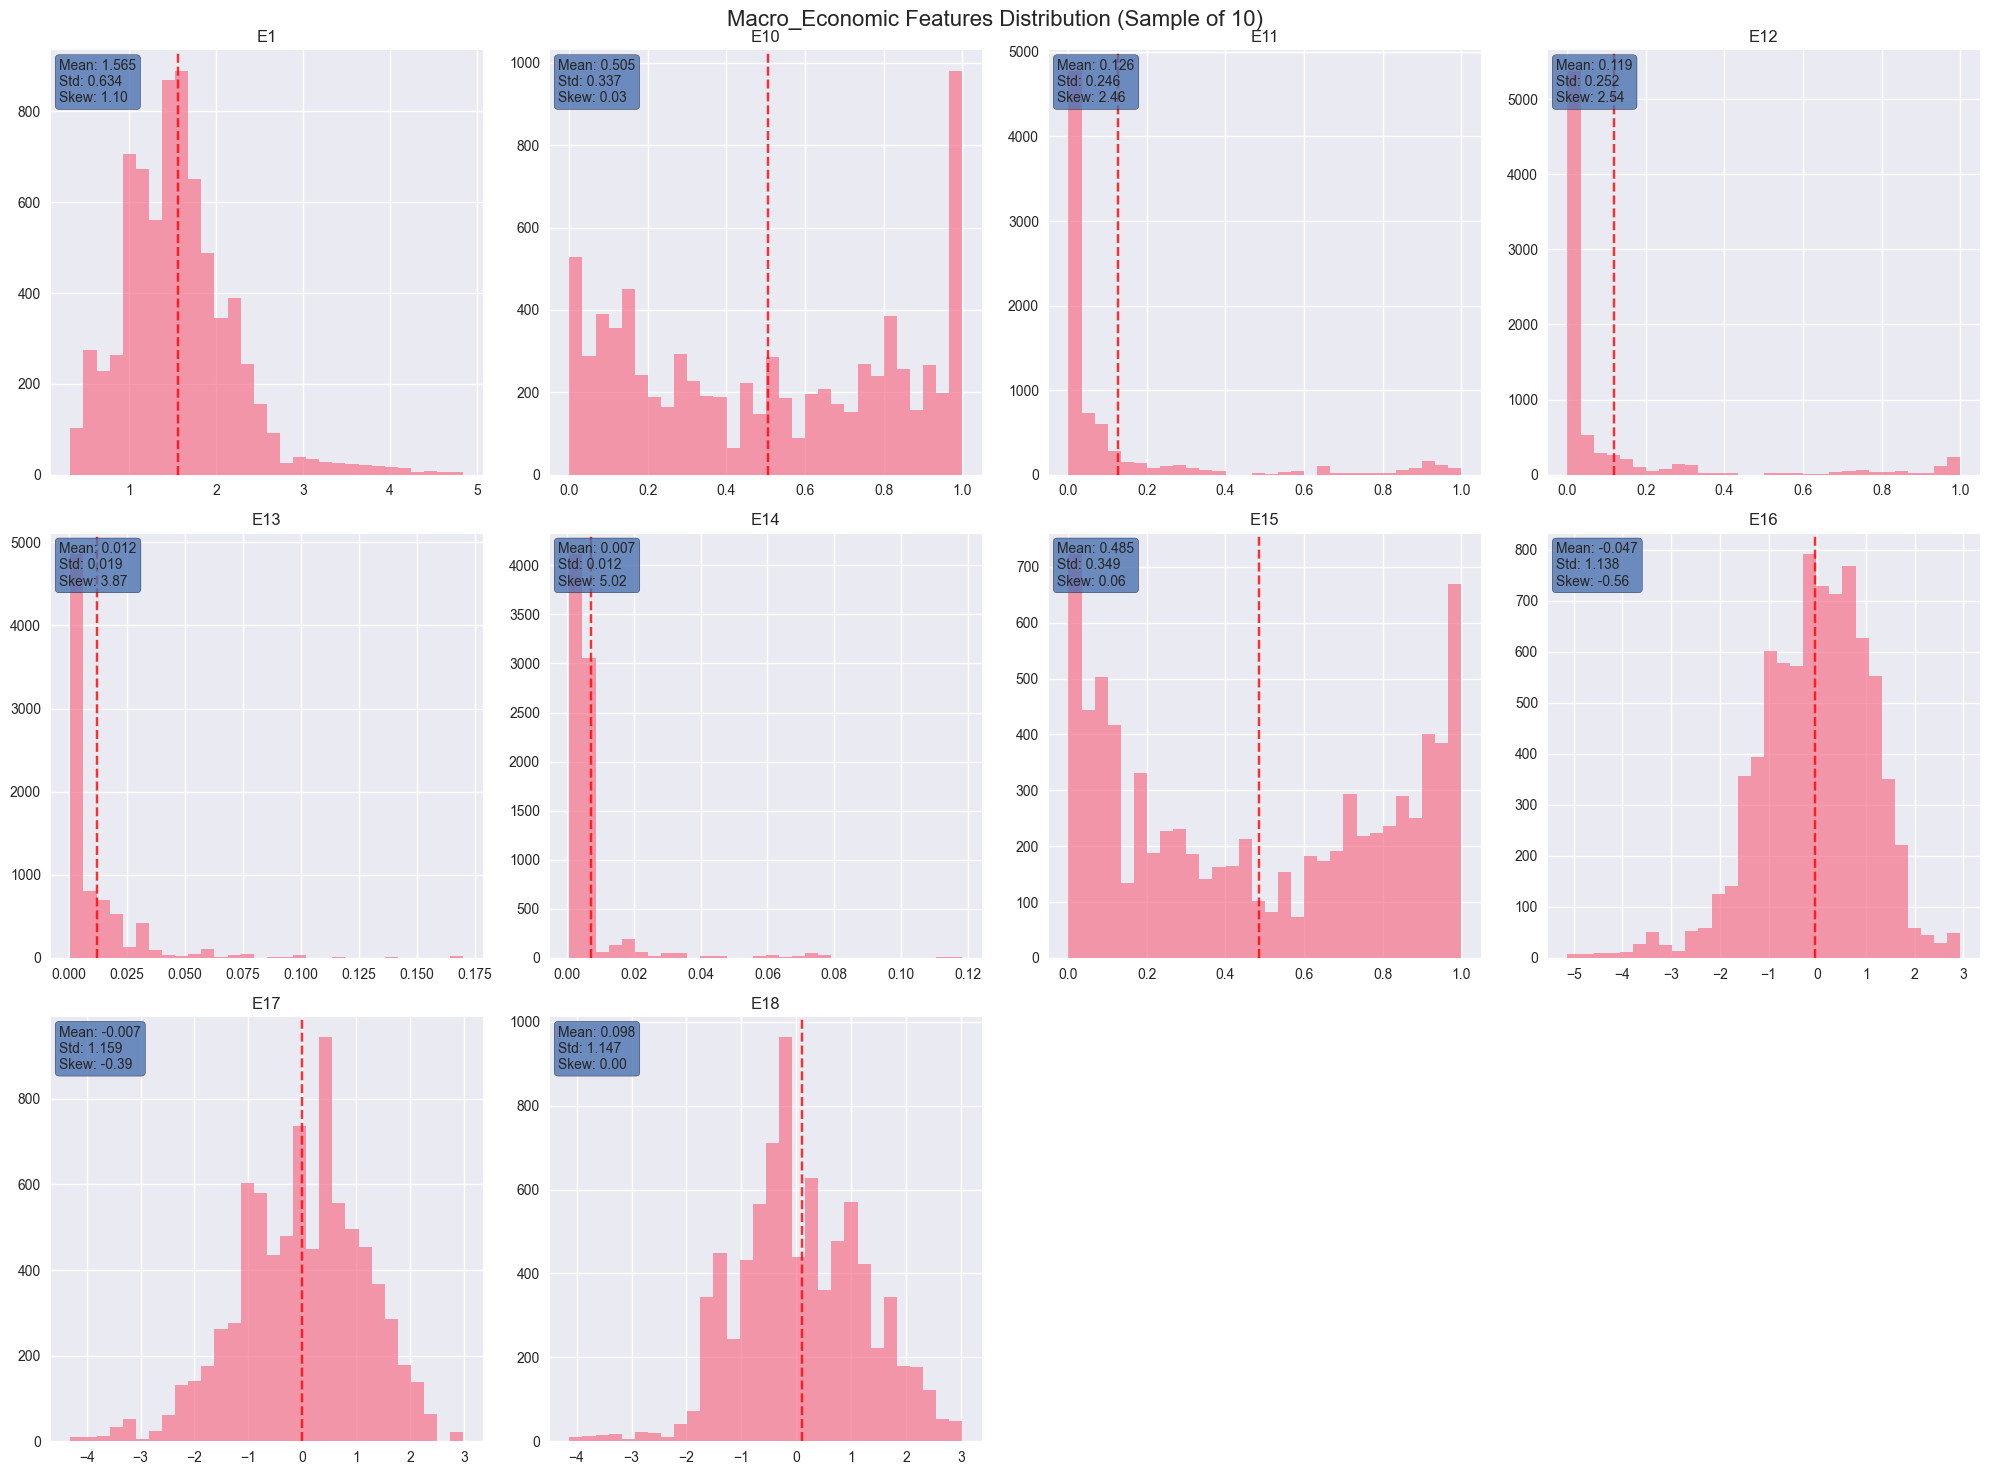


🔍 Analyzing Interest_Rate features (9 total)


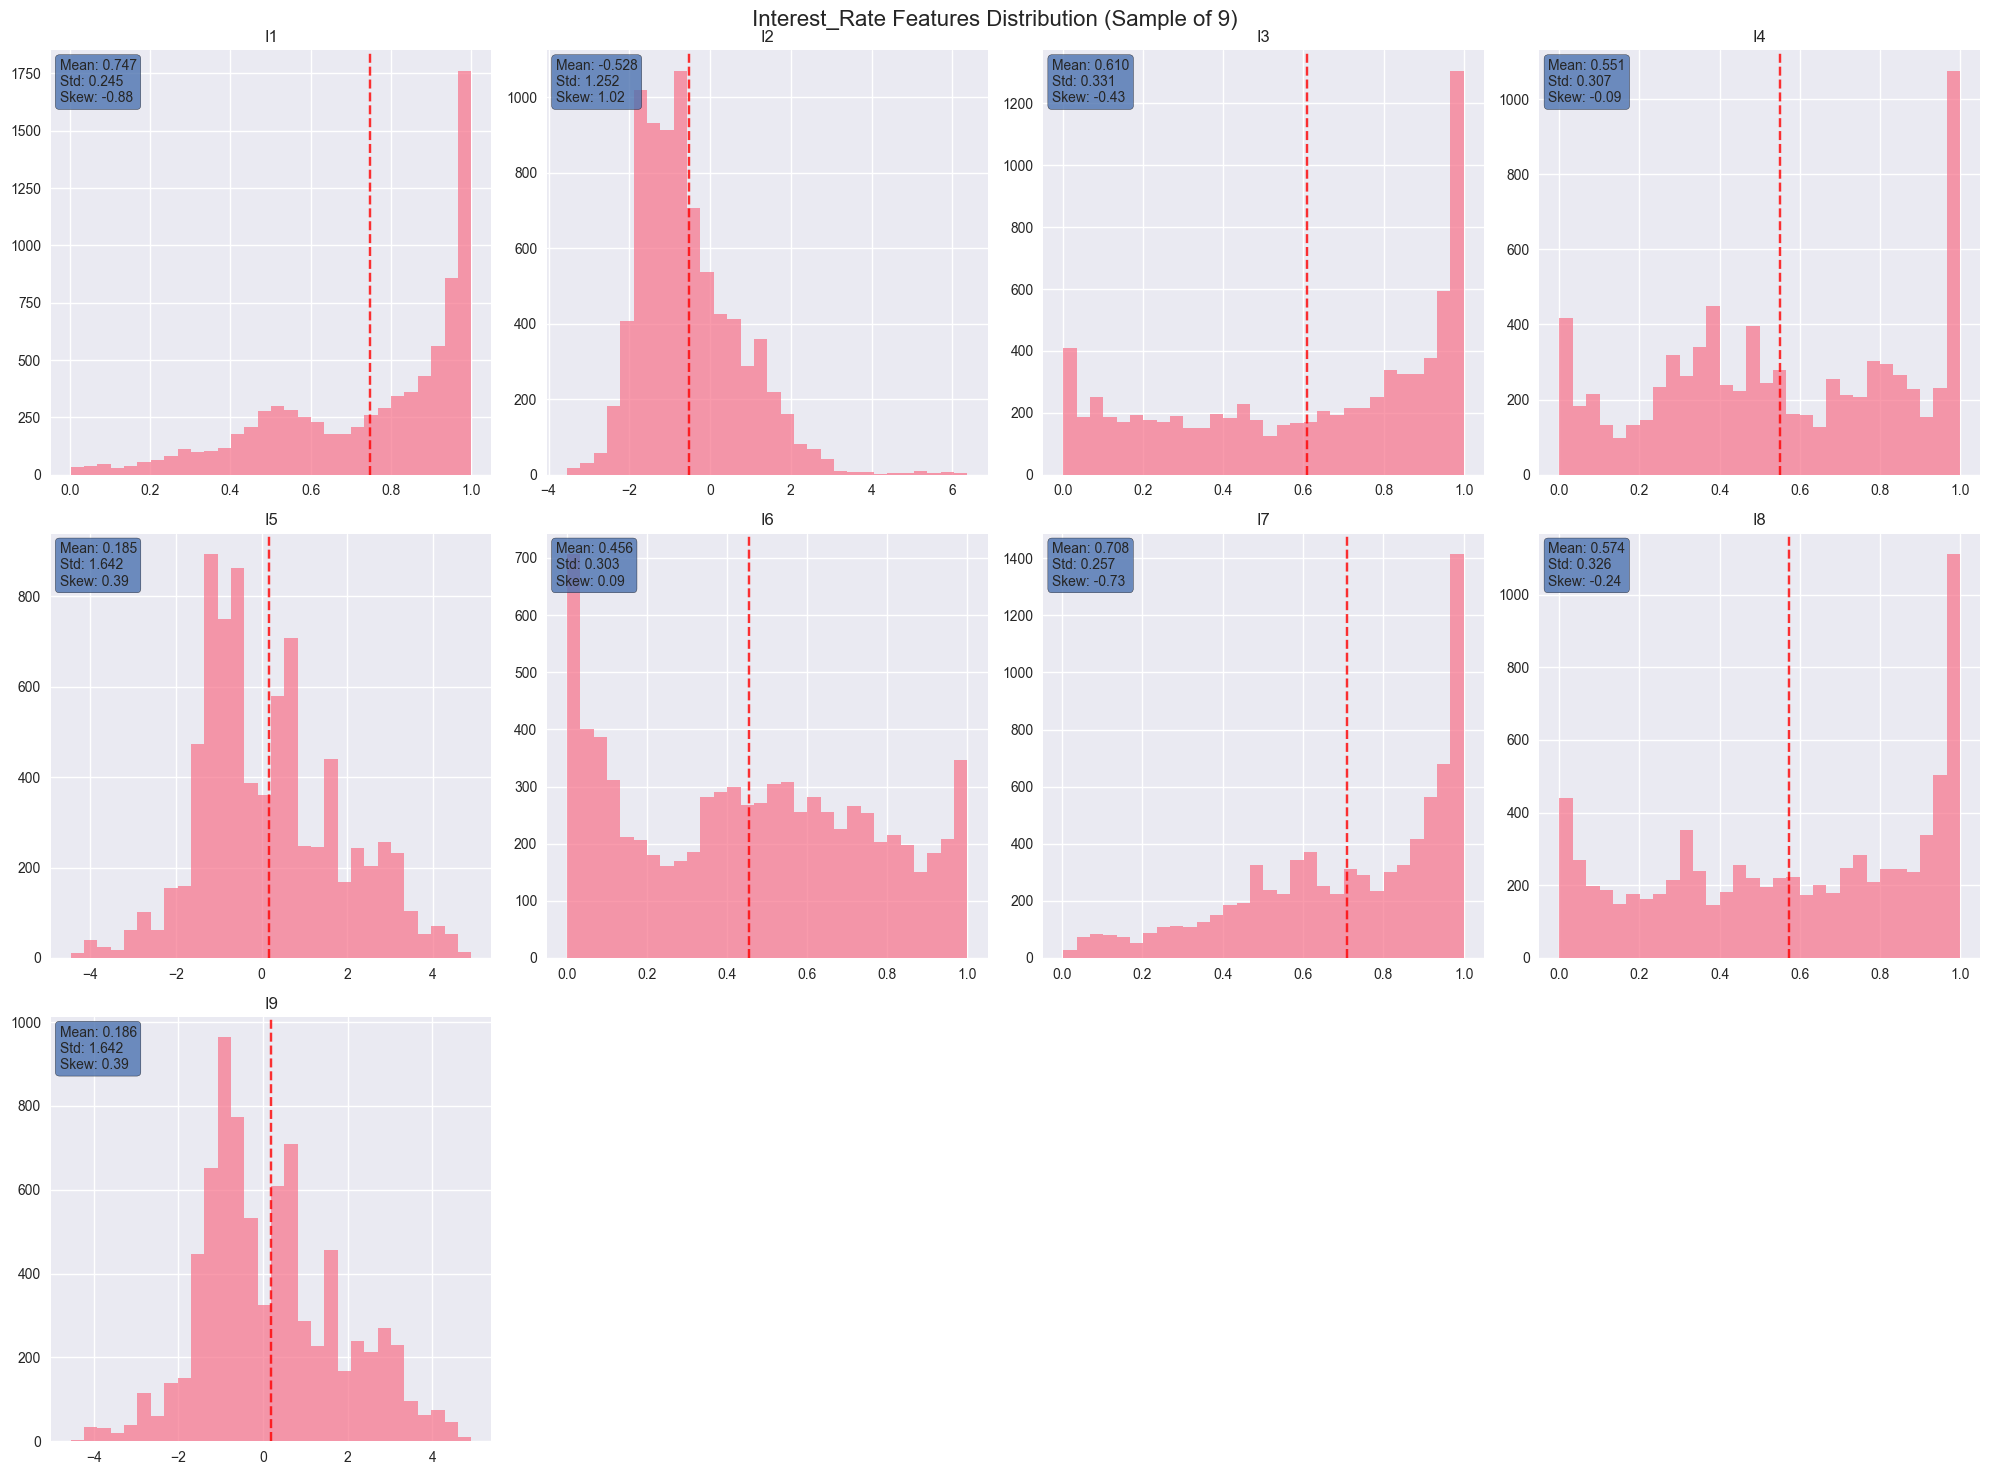


🔍 Analyzing Price_Valuation features (13 total)


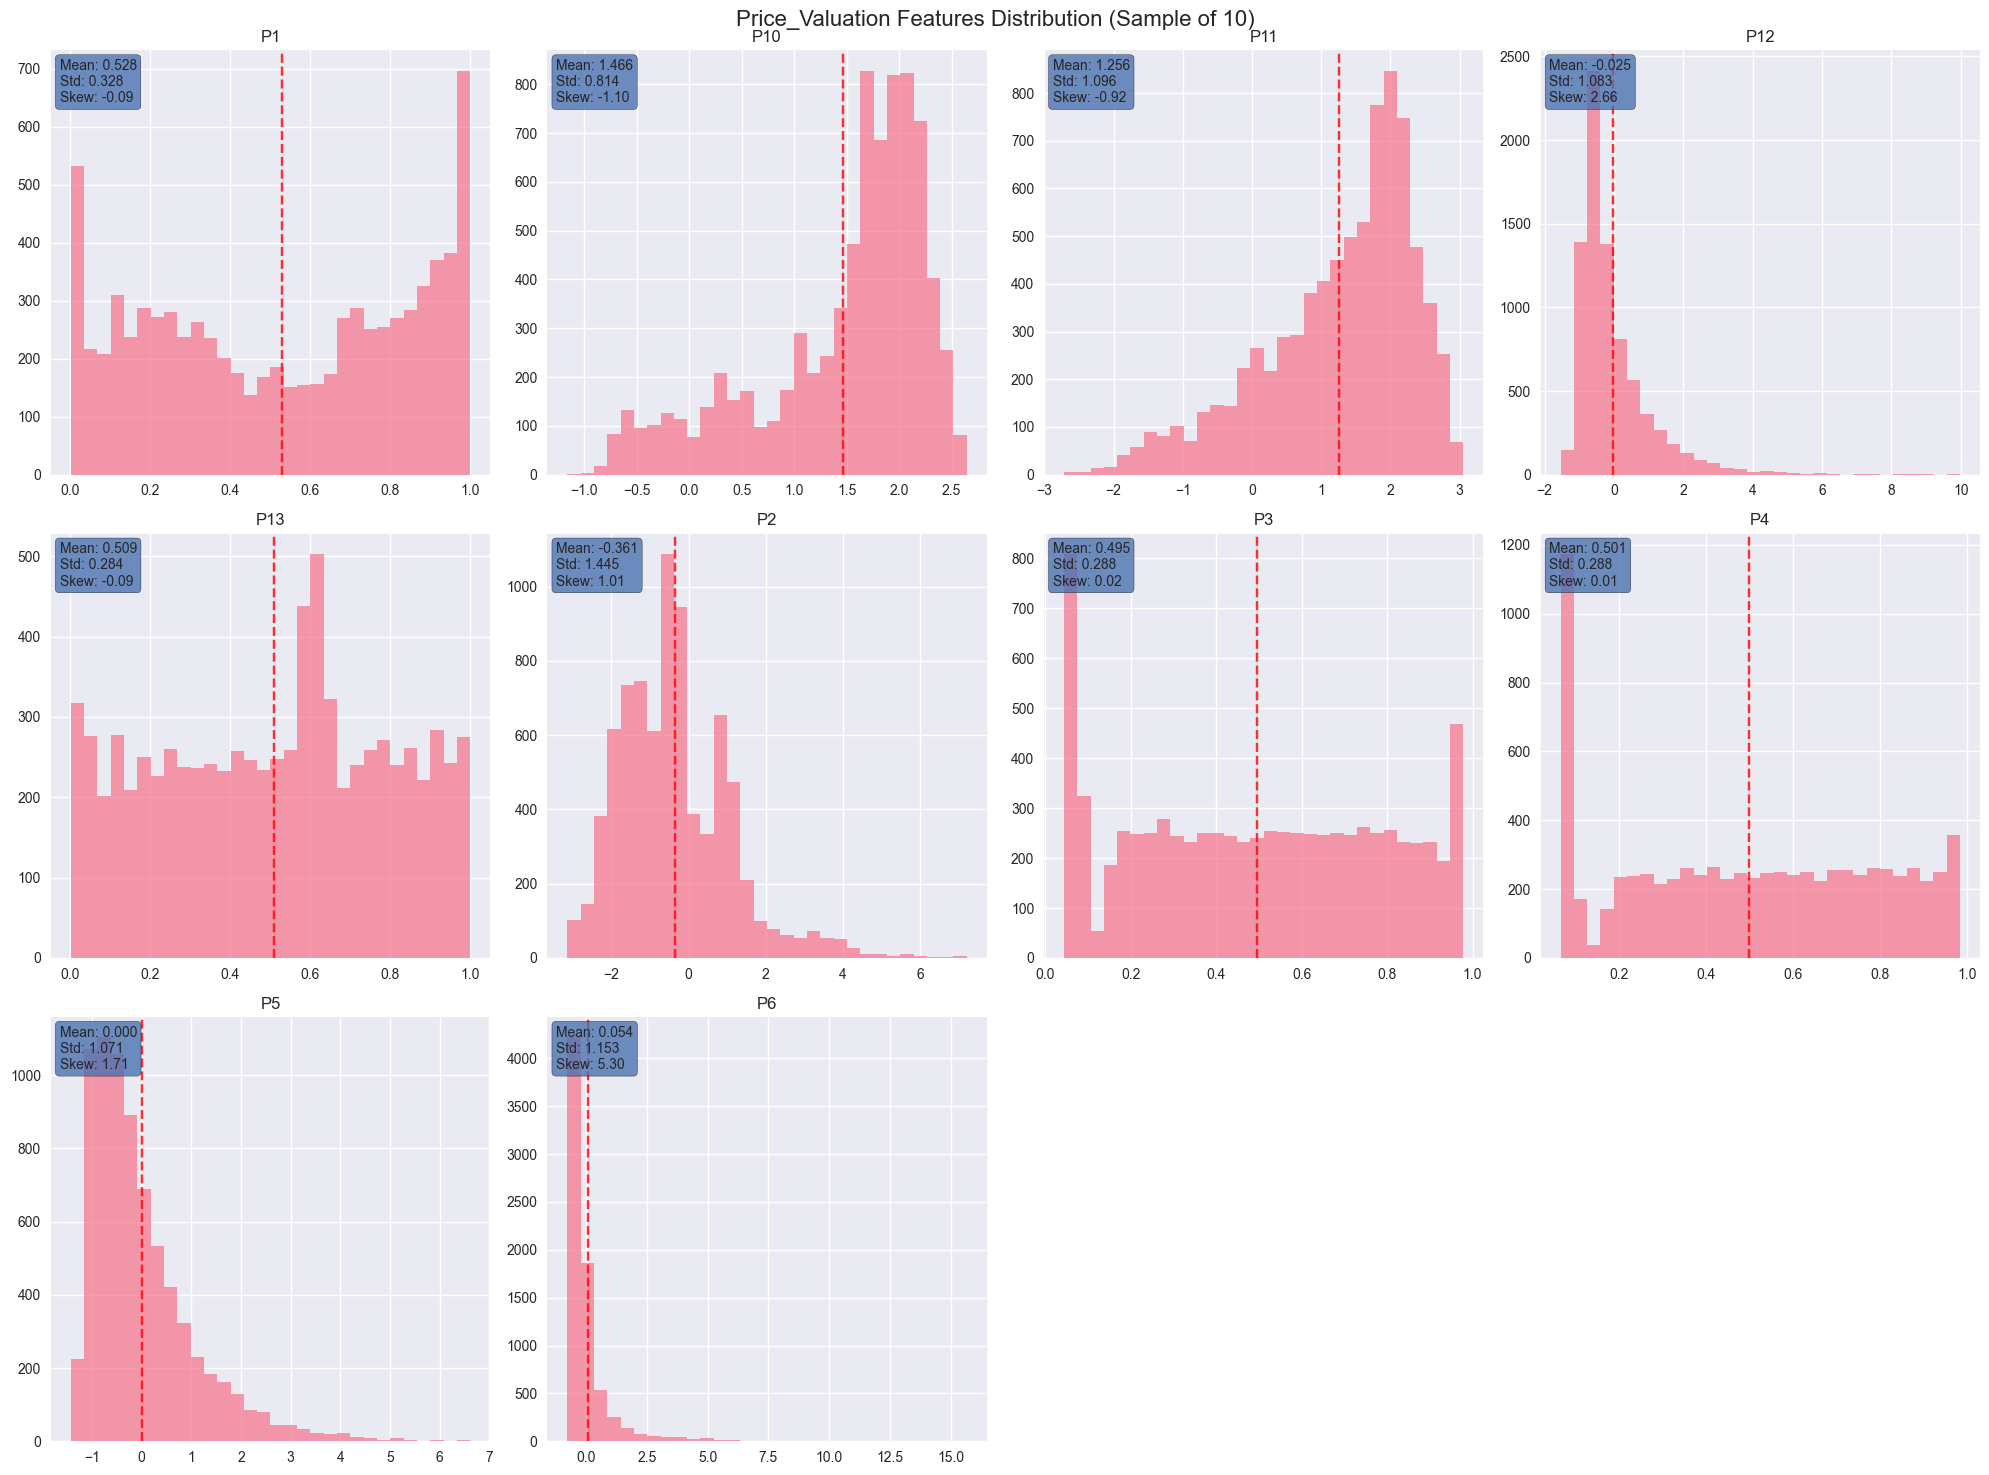


🔍 Analyzing Volatility features (13 total)


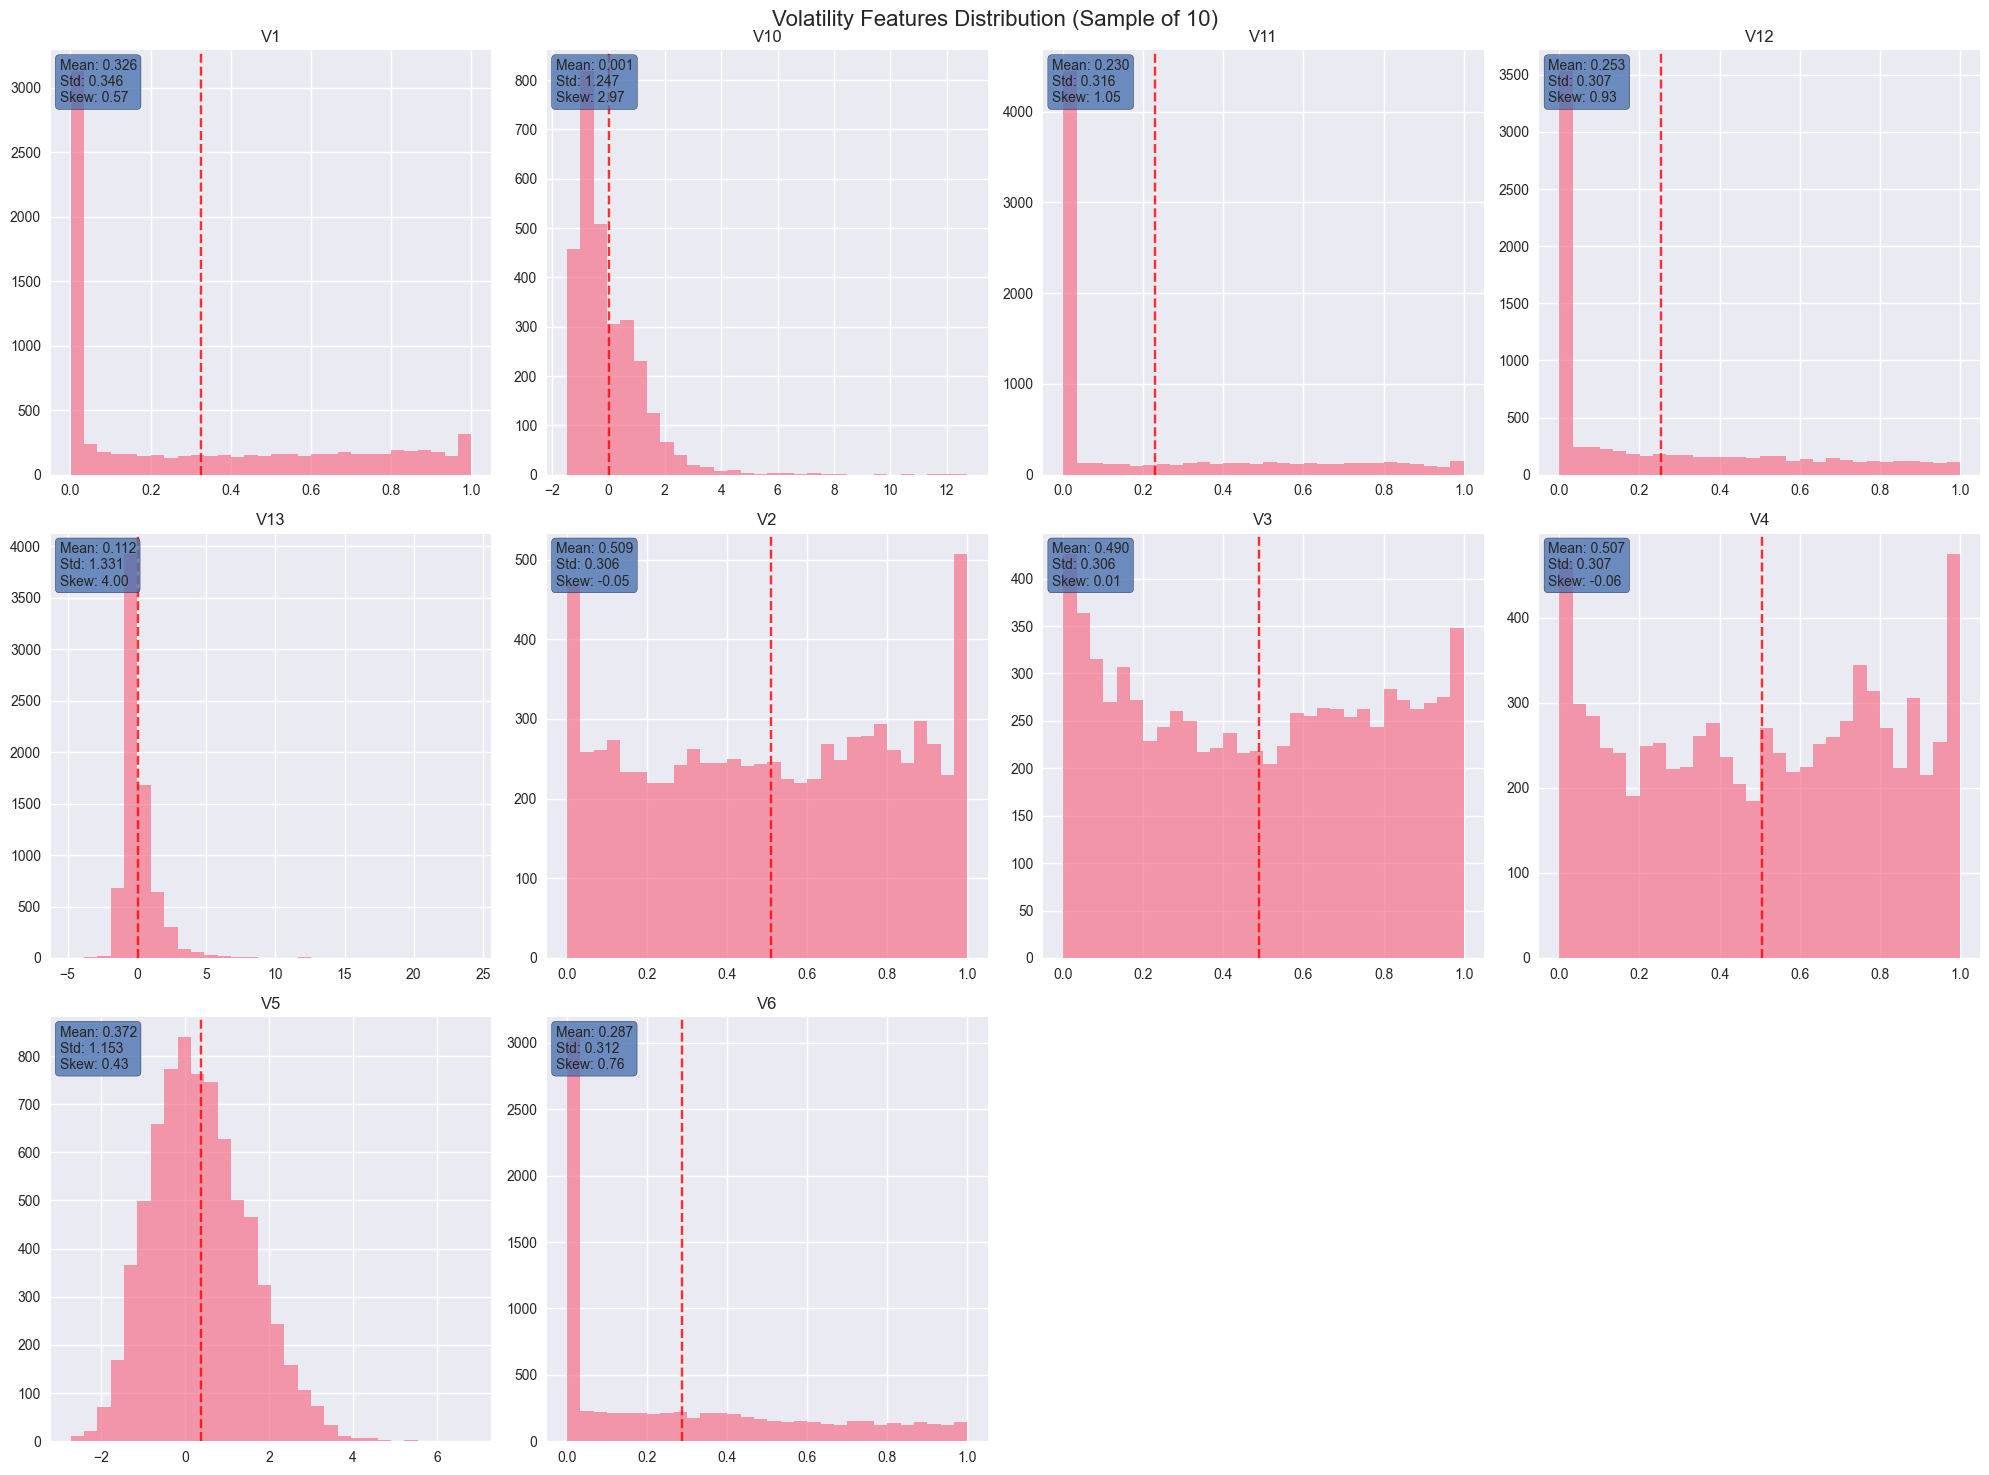


🔍 Analyzing Sentiment features (12 total)


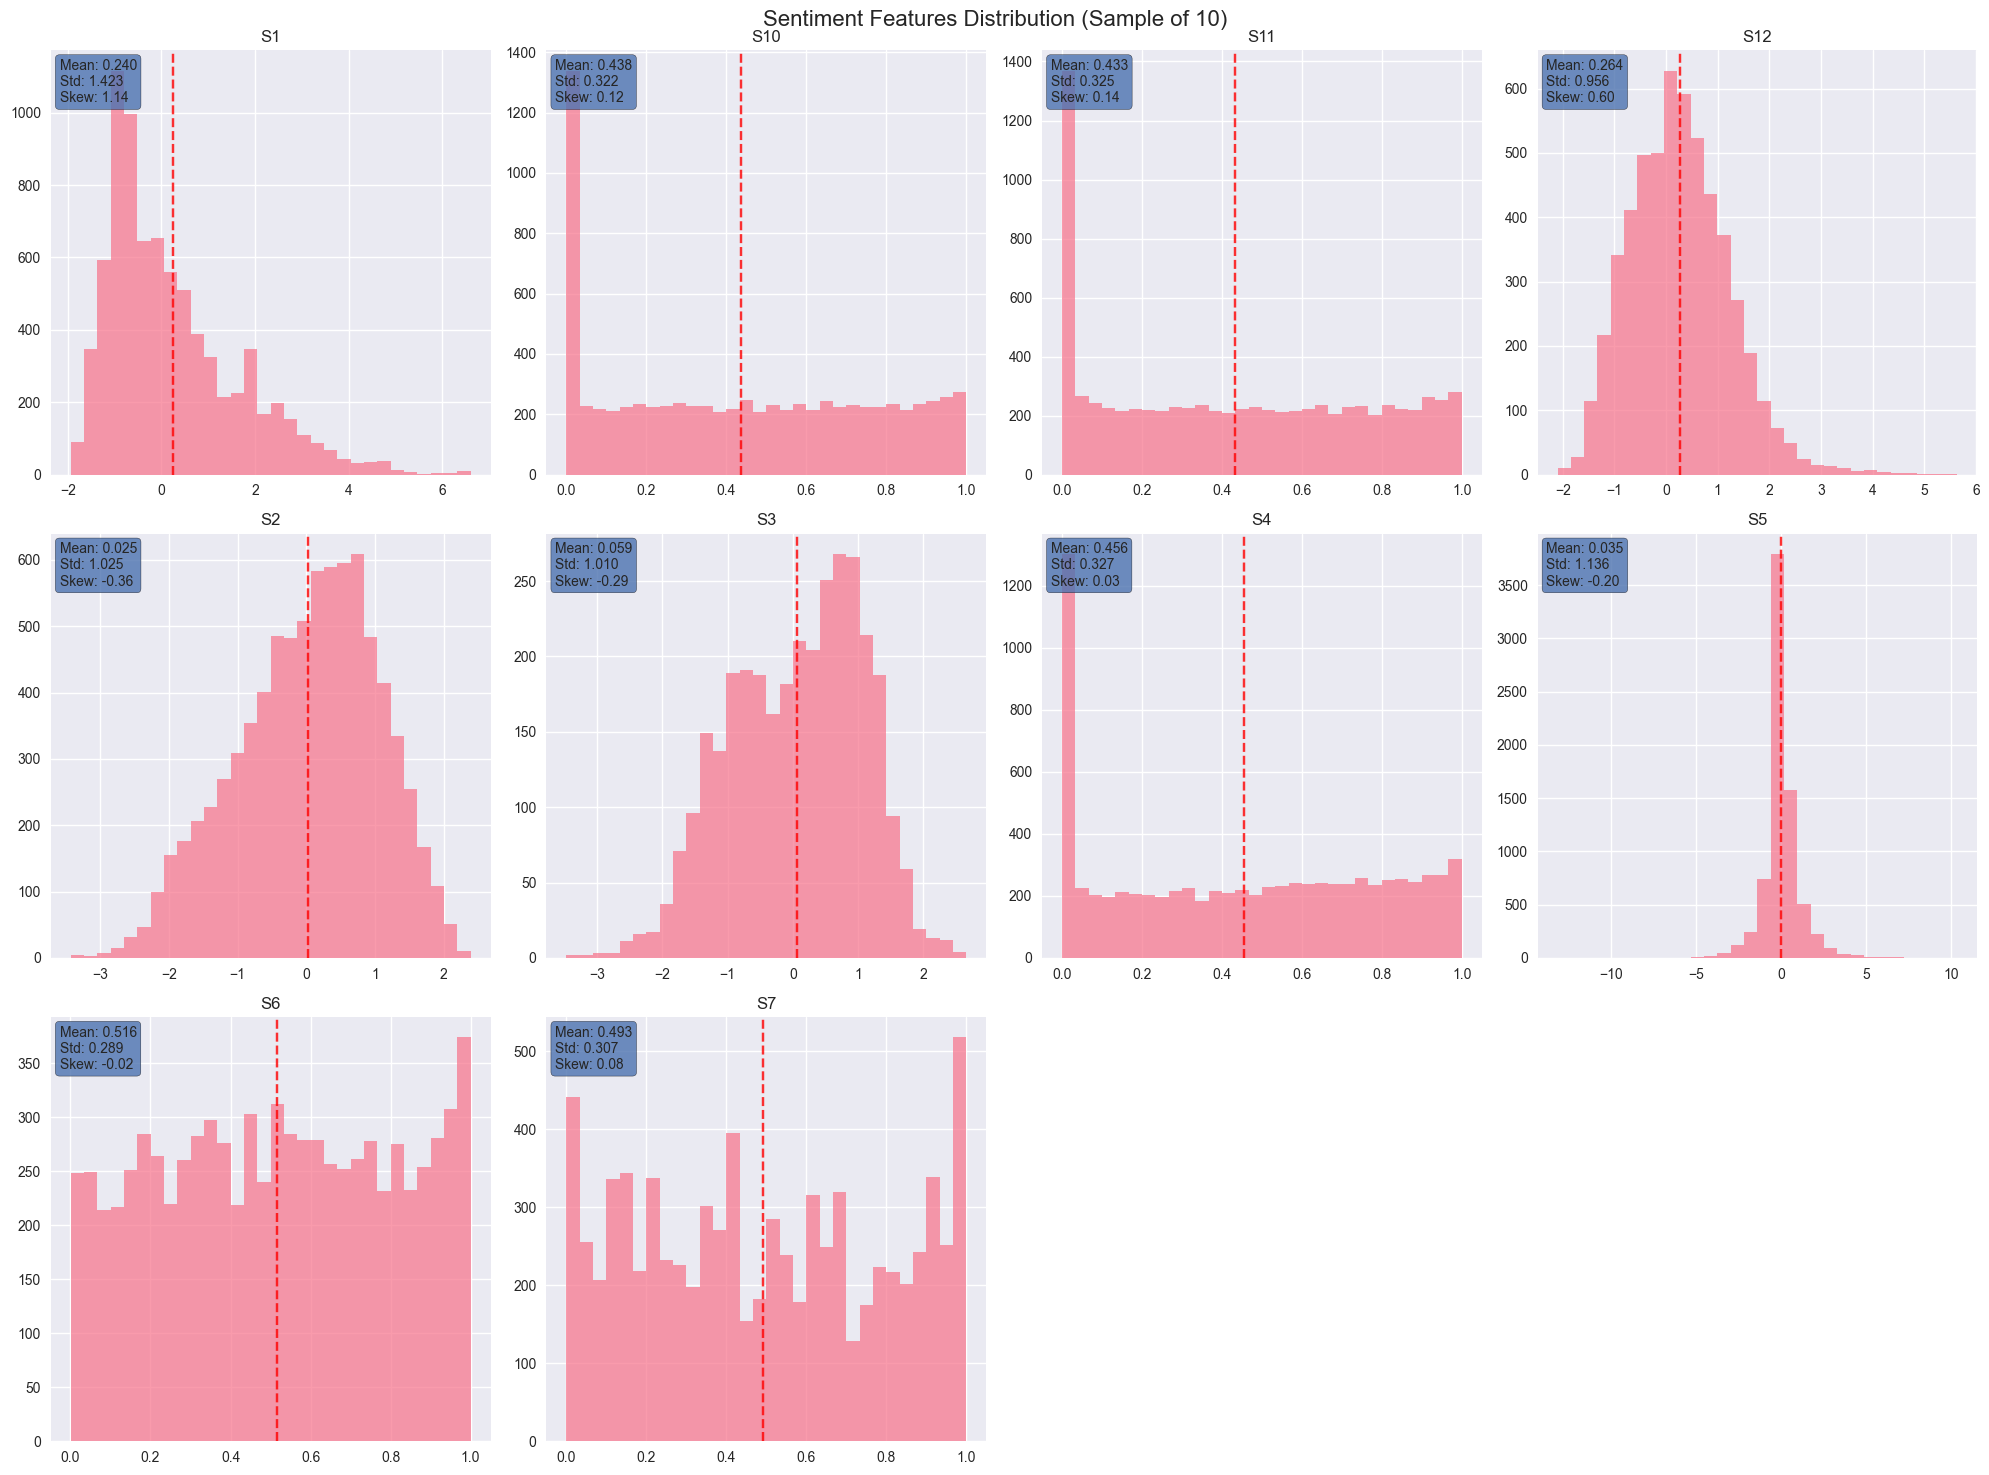


🔍 Analyzing Dummy_Binary features (9 total)


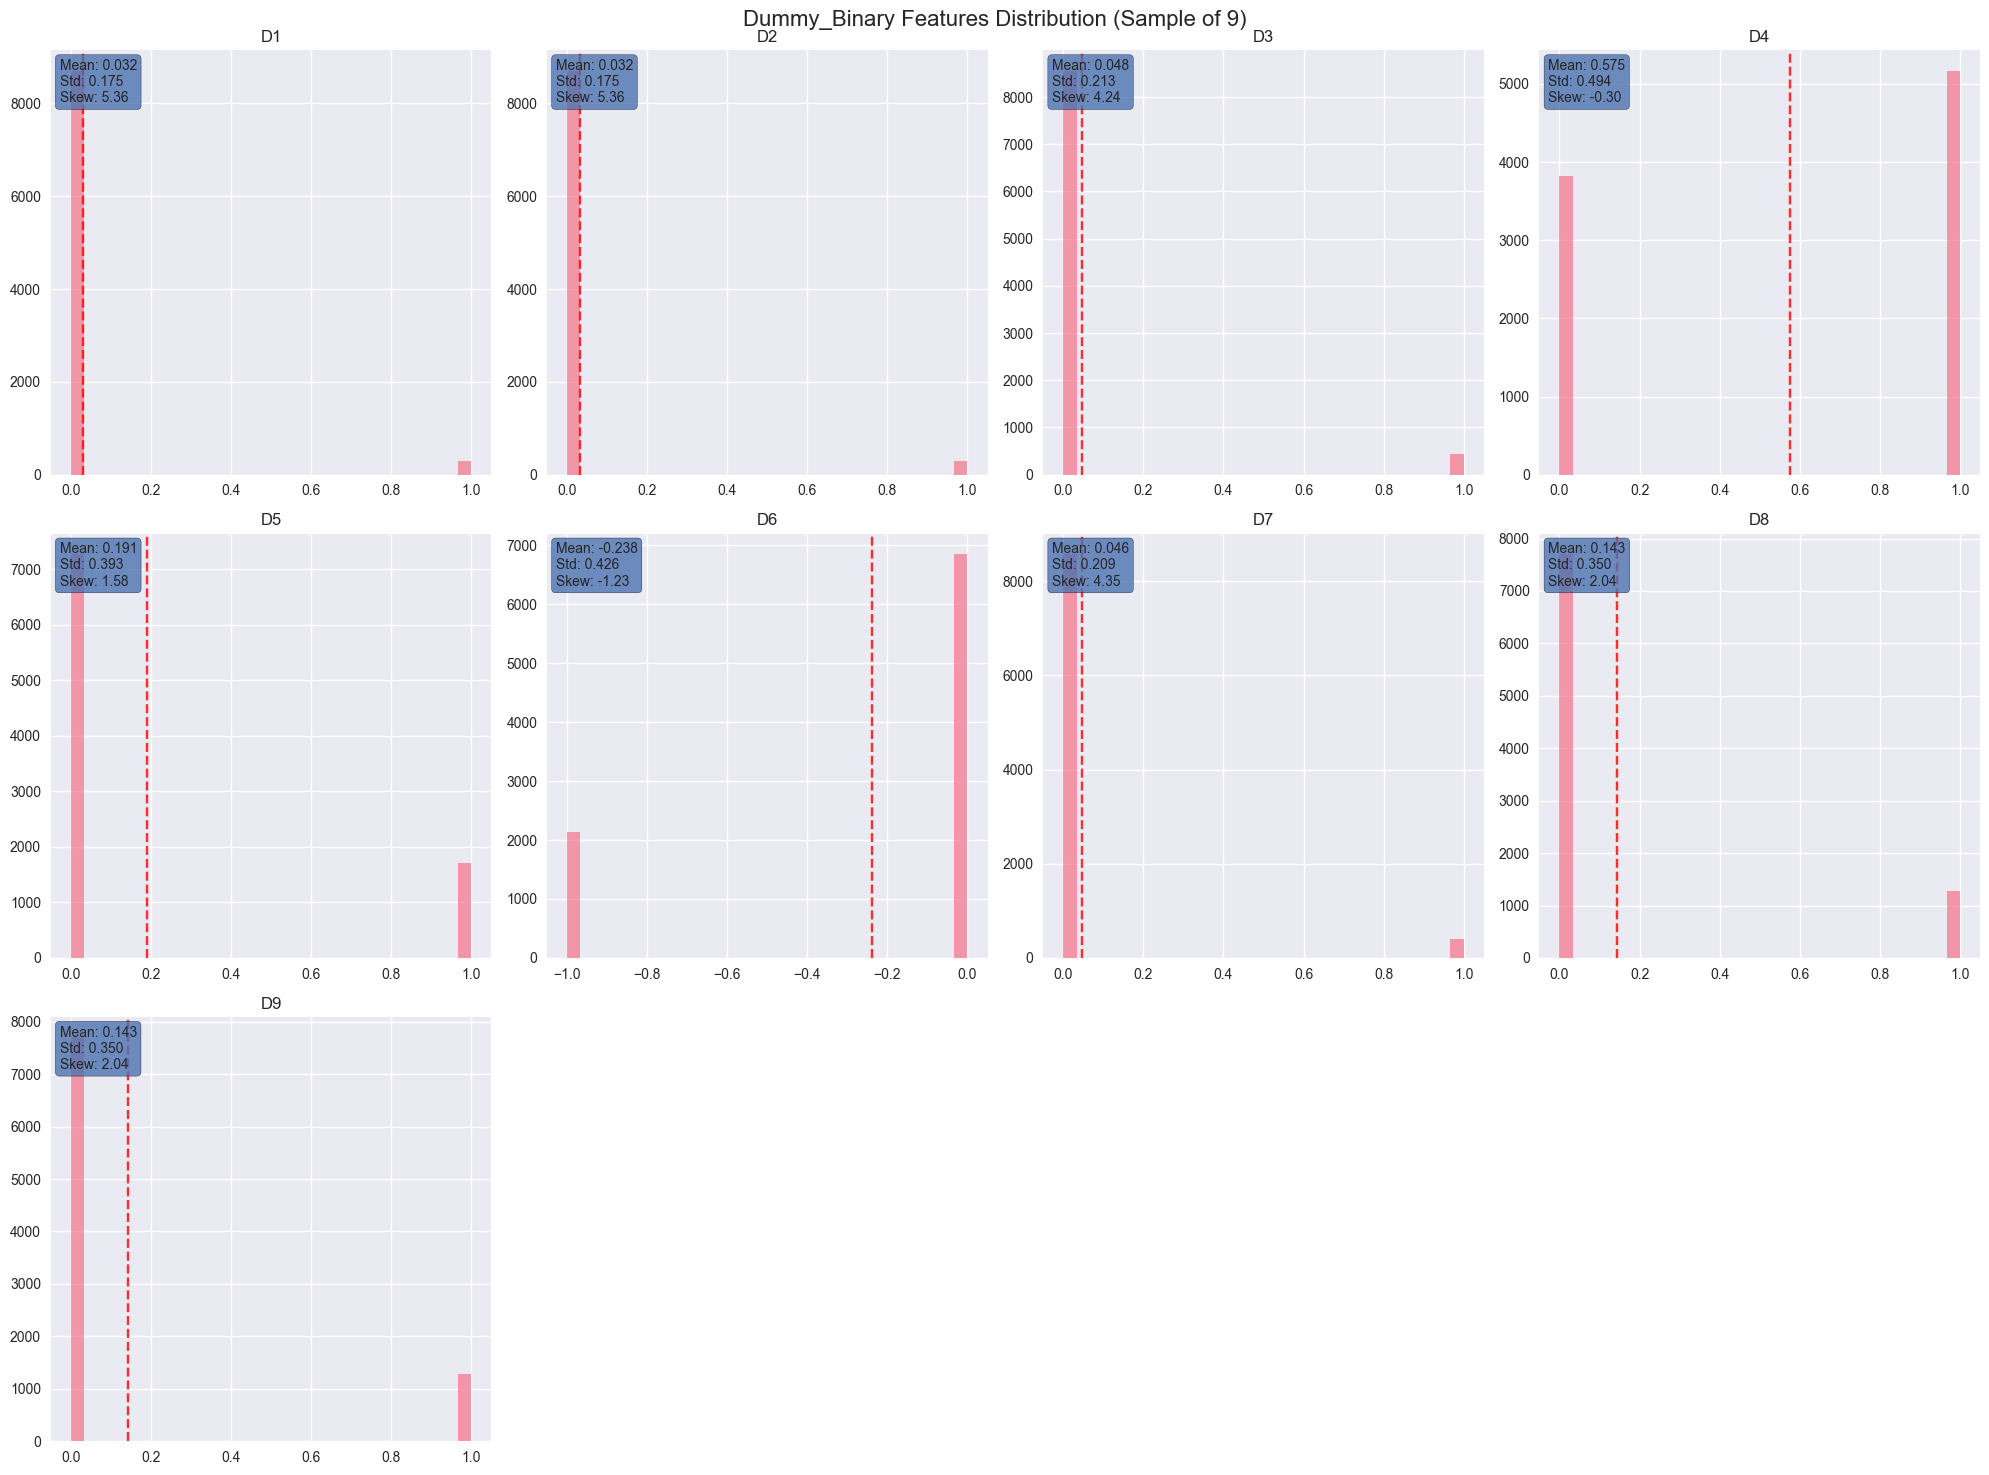

In [10]:
def analyze_feature_distributions(df, feature_categories, sample_size=10):
    """Analyze distributions of different feature categories"""
    
    print("\n📊 FEATURE DISTRIBUTION ANALYSIS")
    print("="*50)
    
    for category, features in feature_categories.items():
        if category == 'Special' or len(features) == 0:
            continue
            
        print(f"\n🔍 Analyzing {category} features ({len(features)} total)")
        
        # Sample features for visualization
        sample_features = features[:min(sample_size, len(features))]
        
        if len(sample_features) > 0:
            # Create distribution plots
            n_cols = min(4, len(sample_features))
            n_rows = (len(sample_features) + n_cols - 1) // n_cols
            
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
            if n_rows == 1:
                axes = axes.reshape(1, -1)
            elif n_cols == 1:
                axes = axes.reshape(-1, 1)
            
            for idx, feature in enumerate(sample_features):
                row = idx // n_cols
                col = idx % n_cols
                
                data = df[feature].dropna()
                if len(data) > 0:
                    axes[row, col].hist(data, bins=30, alpha=0.7)
                    axes[row, col].set_title(f'{feature}')
                    axes[row, col].axvline(data.mean(), color='red', linestyle='--', alpha=0.8)
                    
                    # Add statistics as text
                    stats_text = f'Mean: {data.mean():.3f}\nStd: {data.std():.3f}\nSkew: {data.skew():.2f}'
                    axes[row, col].text(0.02, 0.98, stats_text, transform=axes[row, col].transAxes, 
                                      verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.8))
            
            # Hide empty subplots
            for idx in range(len(sample_features), n_rows * n_cols):
                row = idx // n_cols
                col = idx % n_cols
                axes[row, col].set_visible(False)
            
            plt.suptitle(f'{category} Features Distribution (Sample of {len(sample_features)})', fontsize=16)
            plt.tight_layout()
            plt.show()

analyze_feature_distributions(train_df, feature_categories)

# 6. 상관관계 분석



🔗 CORRELATION ANALYSIS
🎯 TOP 20 FEATURES CORRELATED WITH FORWARD RETURNS:
market_forward_excess_returns    0.999957
V13                              0.063071
M1                               0.044979
S5                               0.040562
D2                               0.034180
D1                               0.034180
M2                               0.033464
V7                               0.032736
V10                              0.031712
M17                              0.024940
D8                               0.024739
S12                              0.024633
E19                              0.024513
S6                               0.022385
D6                               0.017044
D5                               0.016642
D4                               0.016584
V9                               0.016583
M3                               0.016095
E6                               0.015650
Name: forward_returns, dtype: float64

🎯 BOTTOM 20 FEATURES CORRELATED WITH FORWARD R

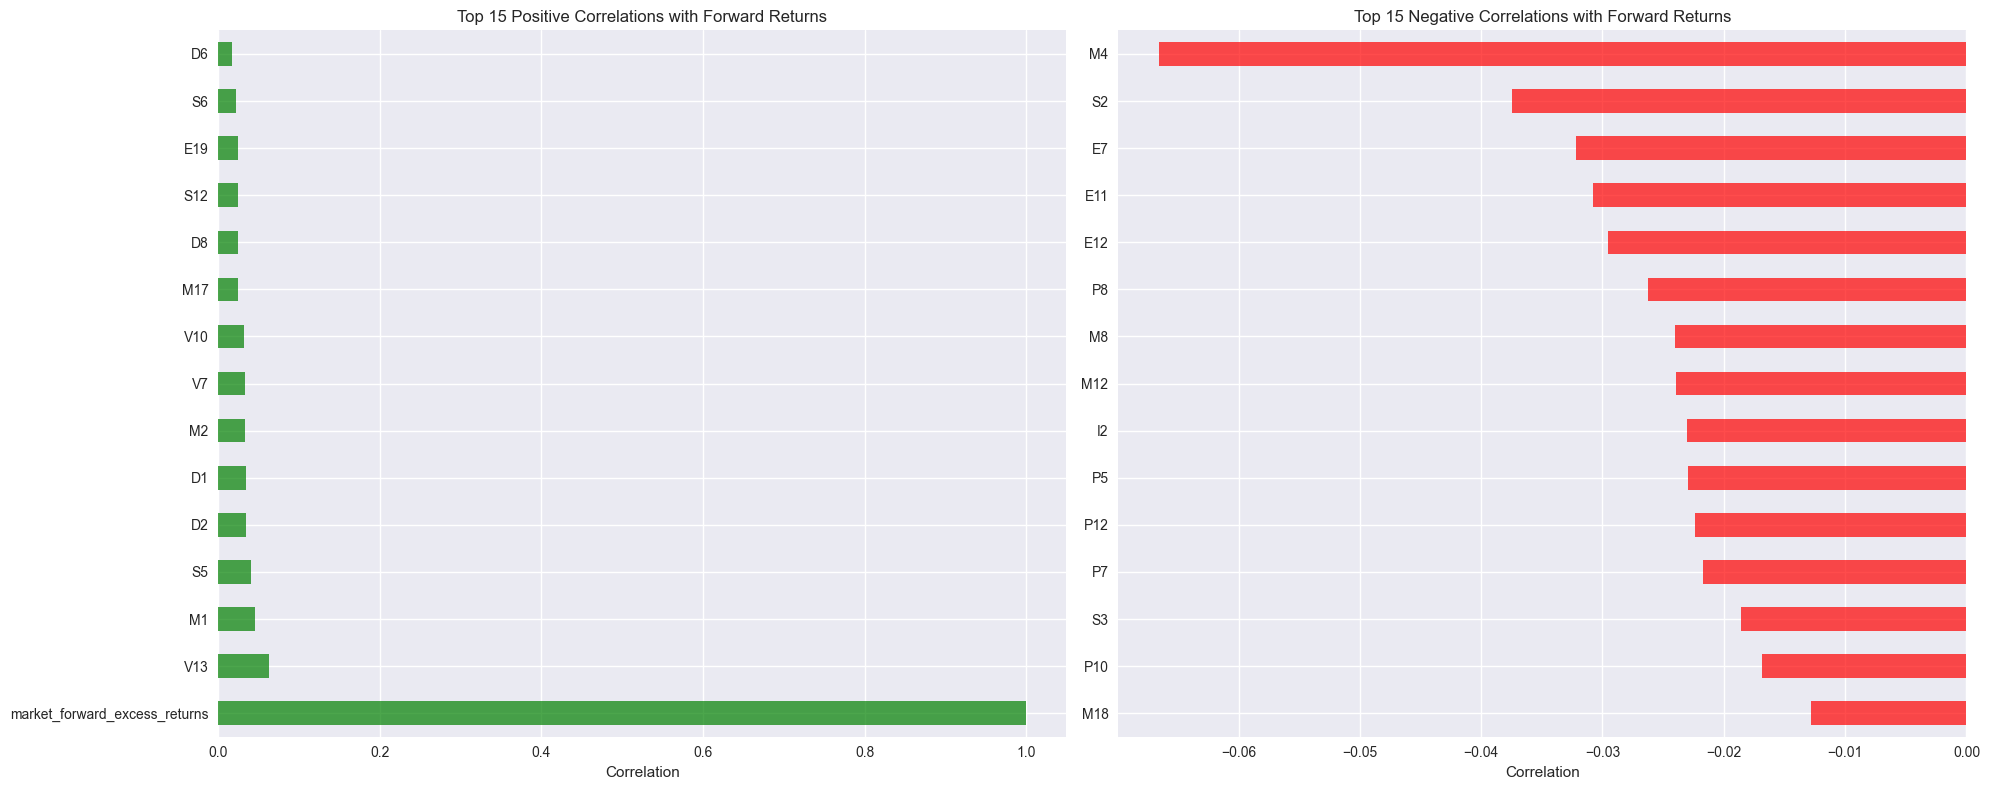


🔍 Market_Dynamics Internal Correlations:


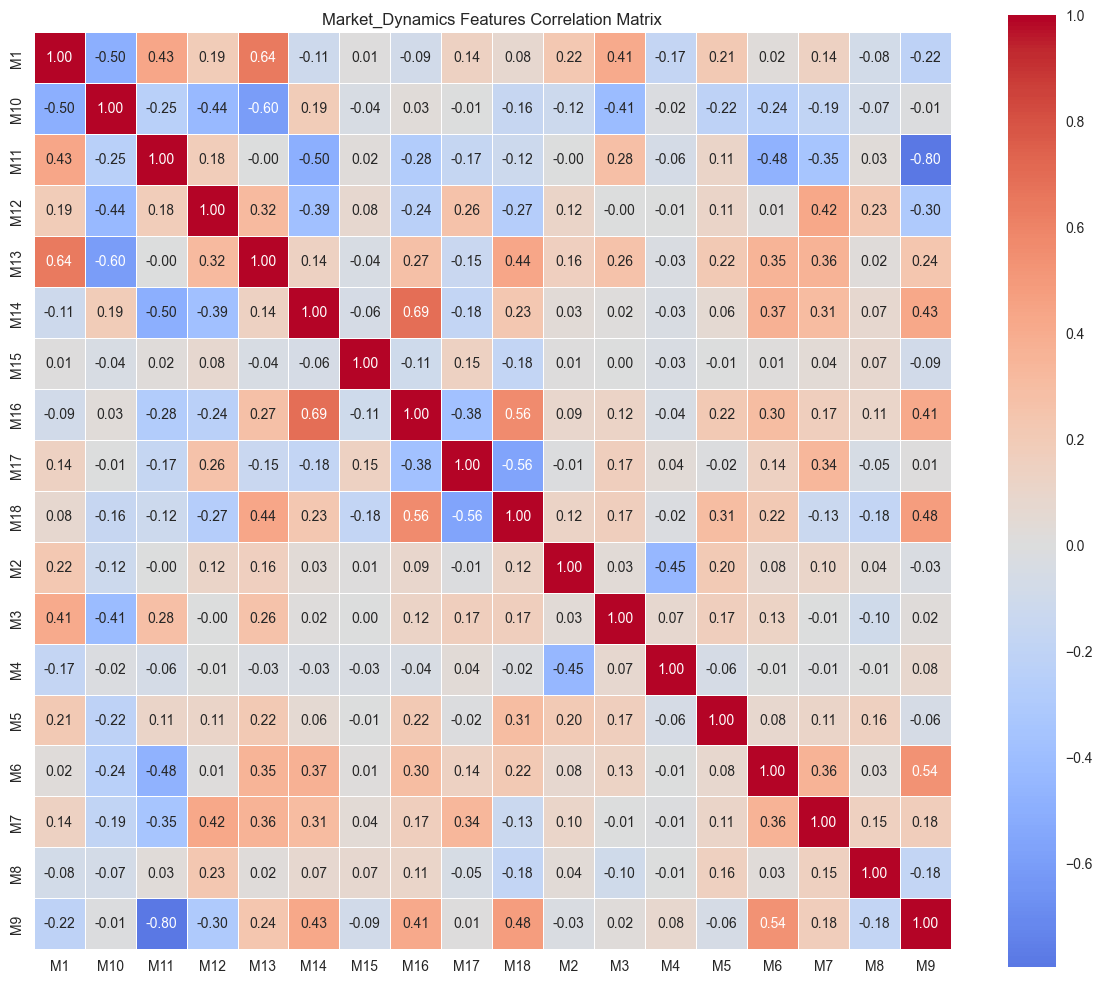


🔍 Macro_Economic Internal Correlations:
High correlations (|r| > 0.8): 5 pairs
  E15 - E9: 0.844
  E16 - E17: 0.929
  E16 - E18: 0.801
  E17 - E18: 0.886
  E2 - E3: 0.896


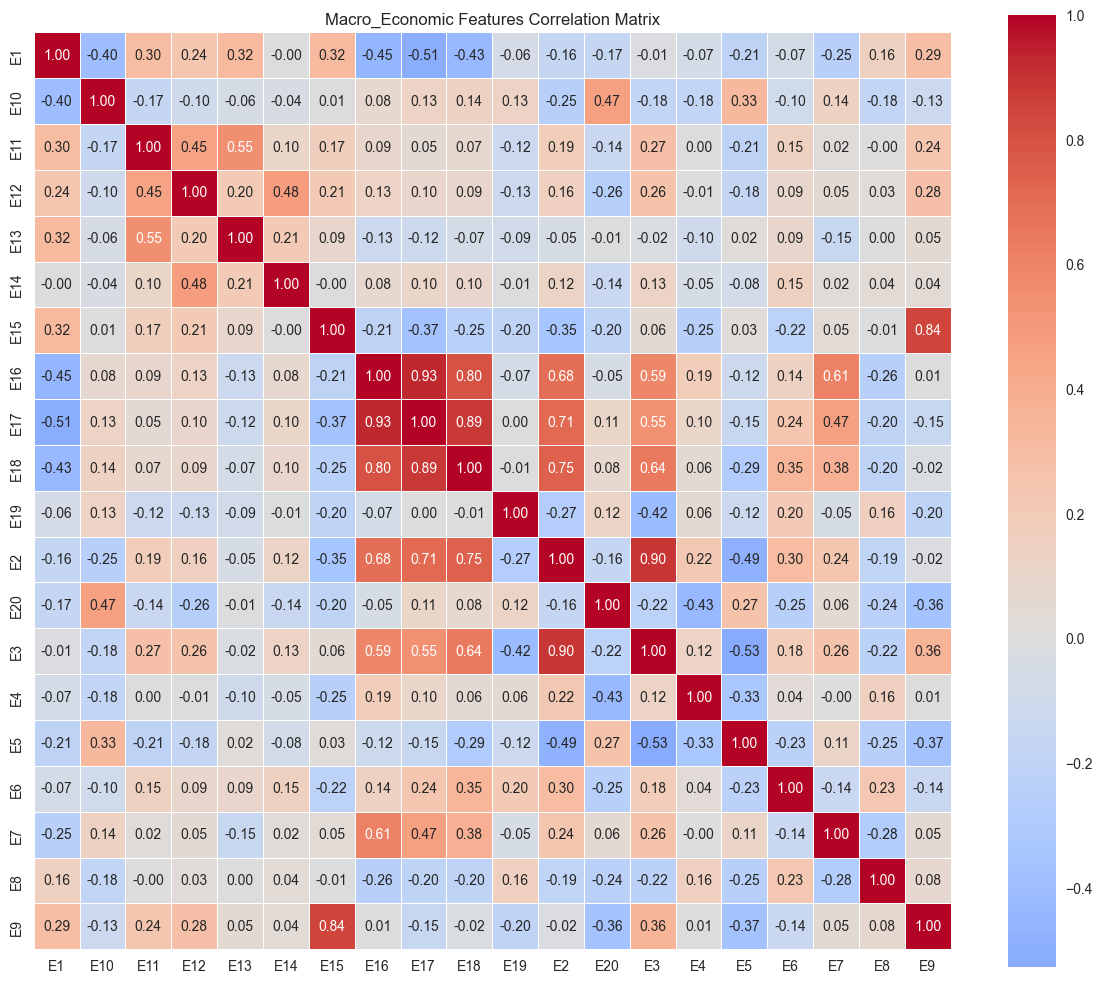


🔍 Interest_Rate Internal Correlations:
High correlations (|r| > 0.8): 2 pairs
  I4 - I8: 0.830
  I5 - I9: 1.000


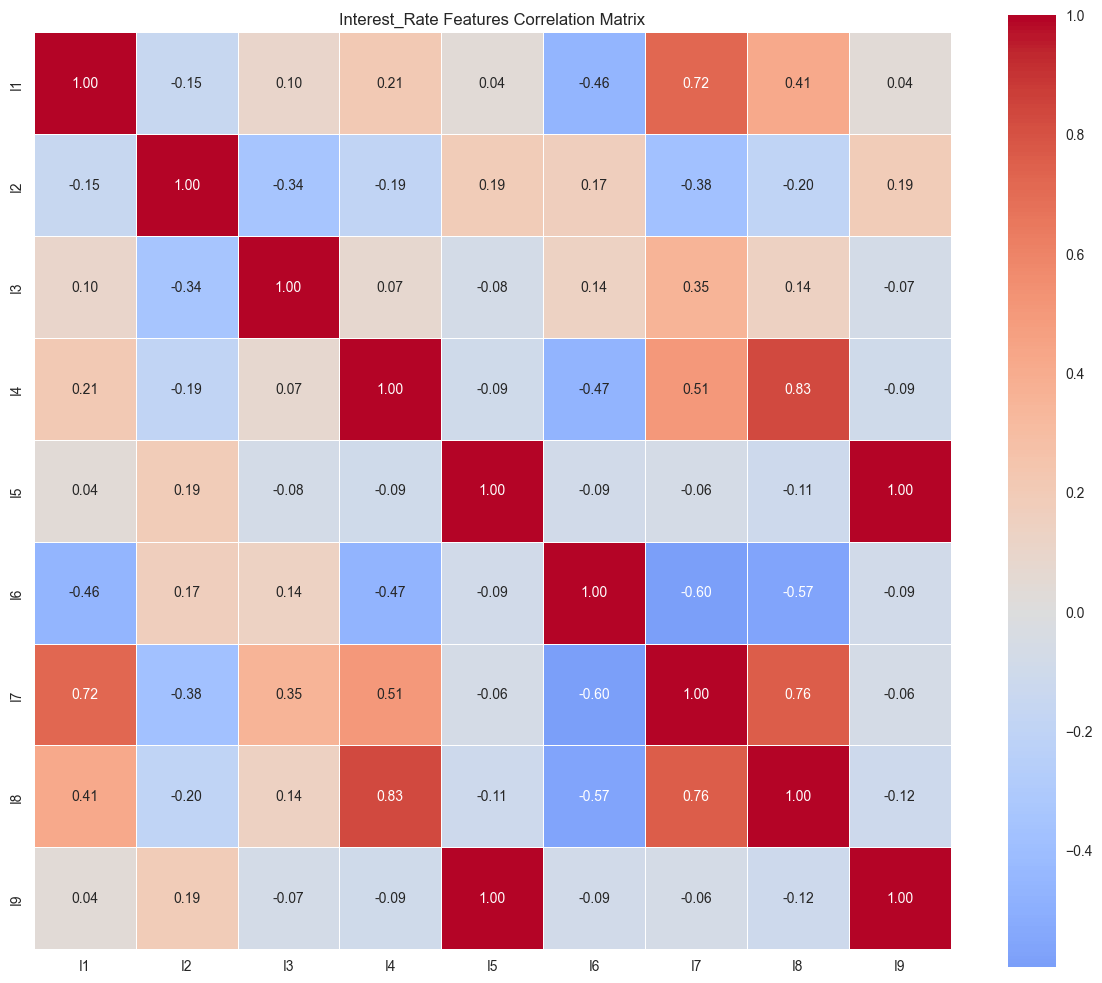


🔍 Price_Valuation Internal Correlations:
High correlations (|r| > 0.8): 2 pairs
  P10 - P11: 0.938
  P10 - P8: 0.807


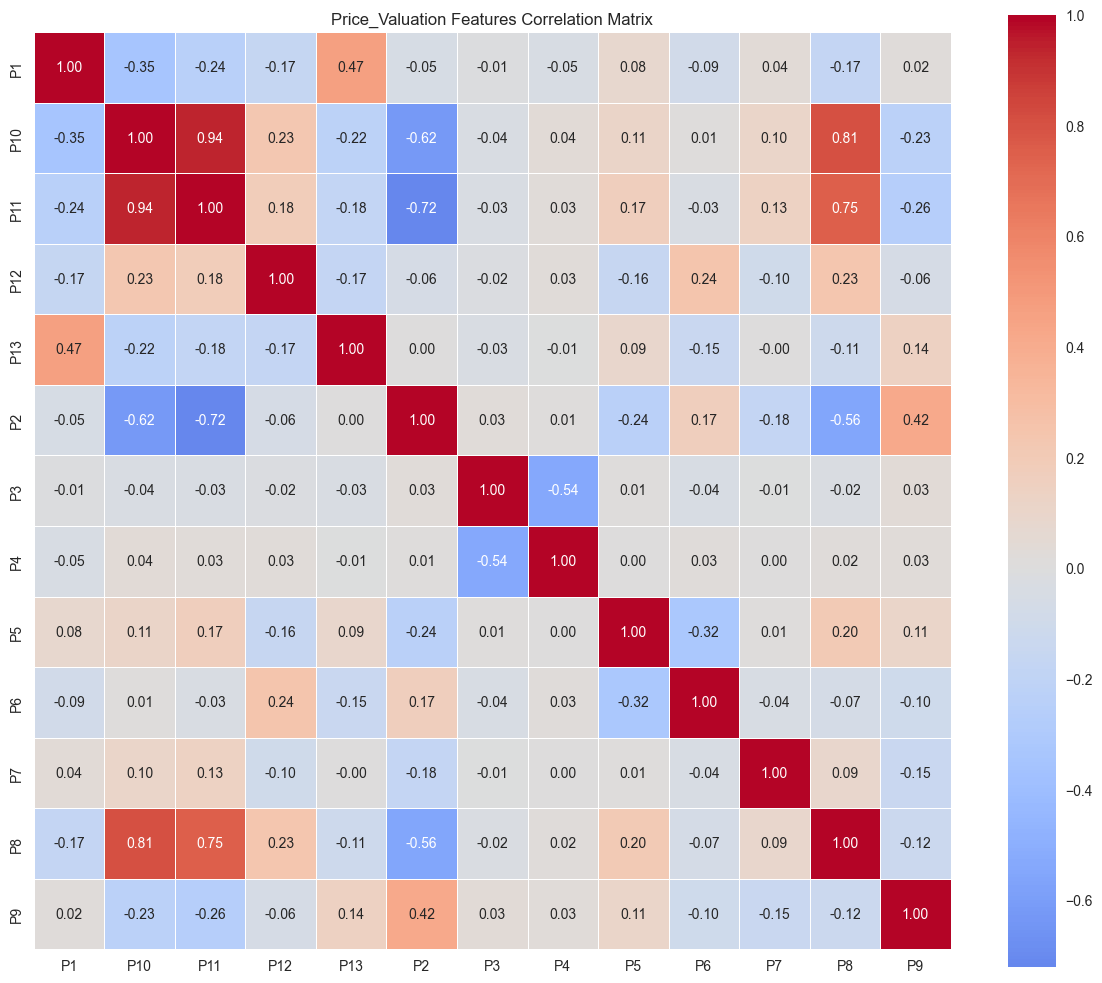


🔍 Volatility Internal Correlations:
High correlations (|r| > 0.8): 9 pairs
  V1 - V11: 0.877
  V1 - V2: 0.845
  V1 - V3: 0.802
  V1 - V4: 0.821
  V1 - V8: 0.873
  V10 - V7: 0.934
  V10 - V9: 0.985
  V2 - V4: 0.935
  V7 - V9: 0.977


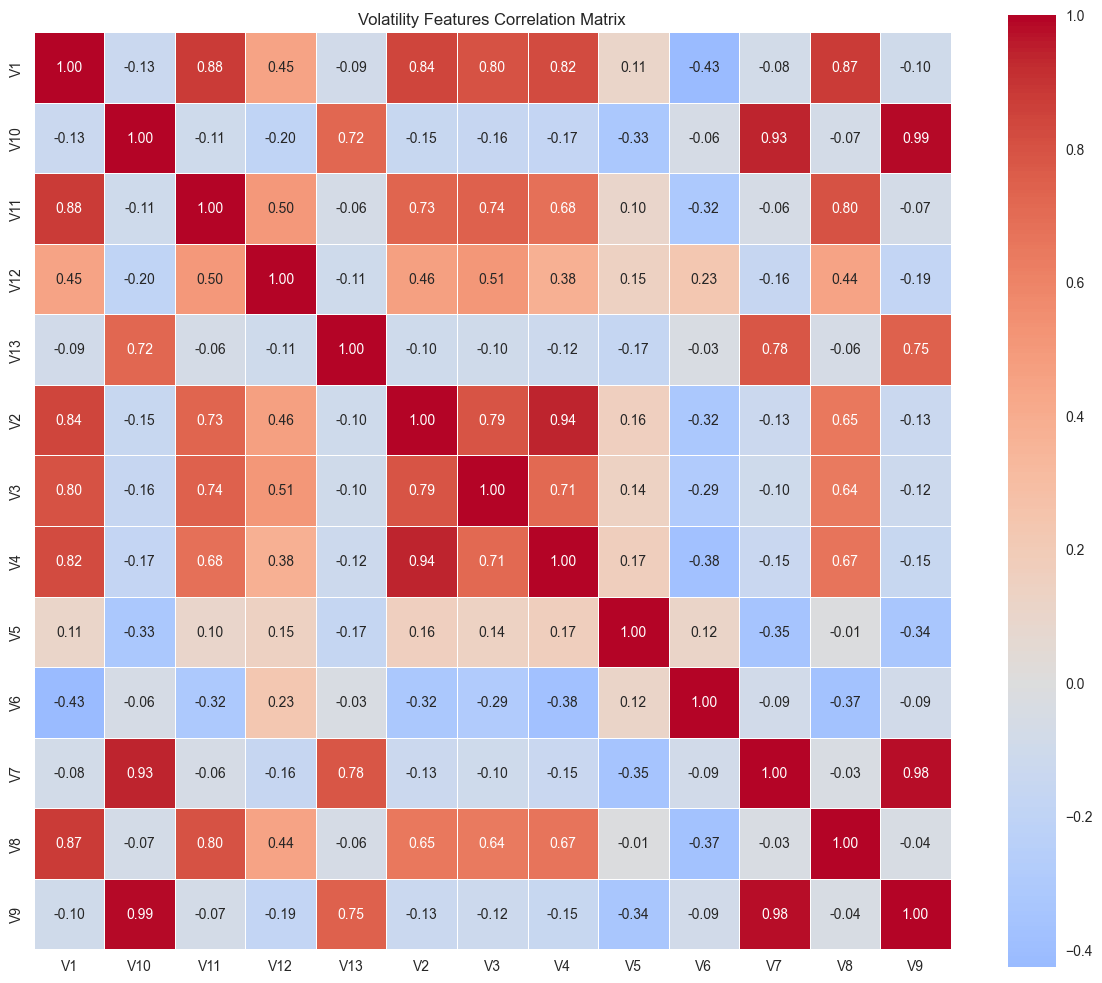


🔍 Sentiment Internal Correlations:
High correlations (|r| > 0.8): 3 pairs
  S10 - S11: 0.916
  S10 - S4: 0.819
  S11 - S4: 0.901


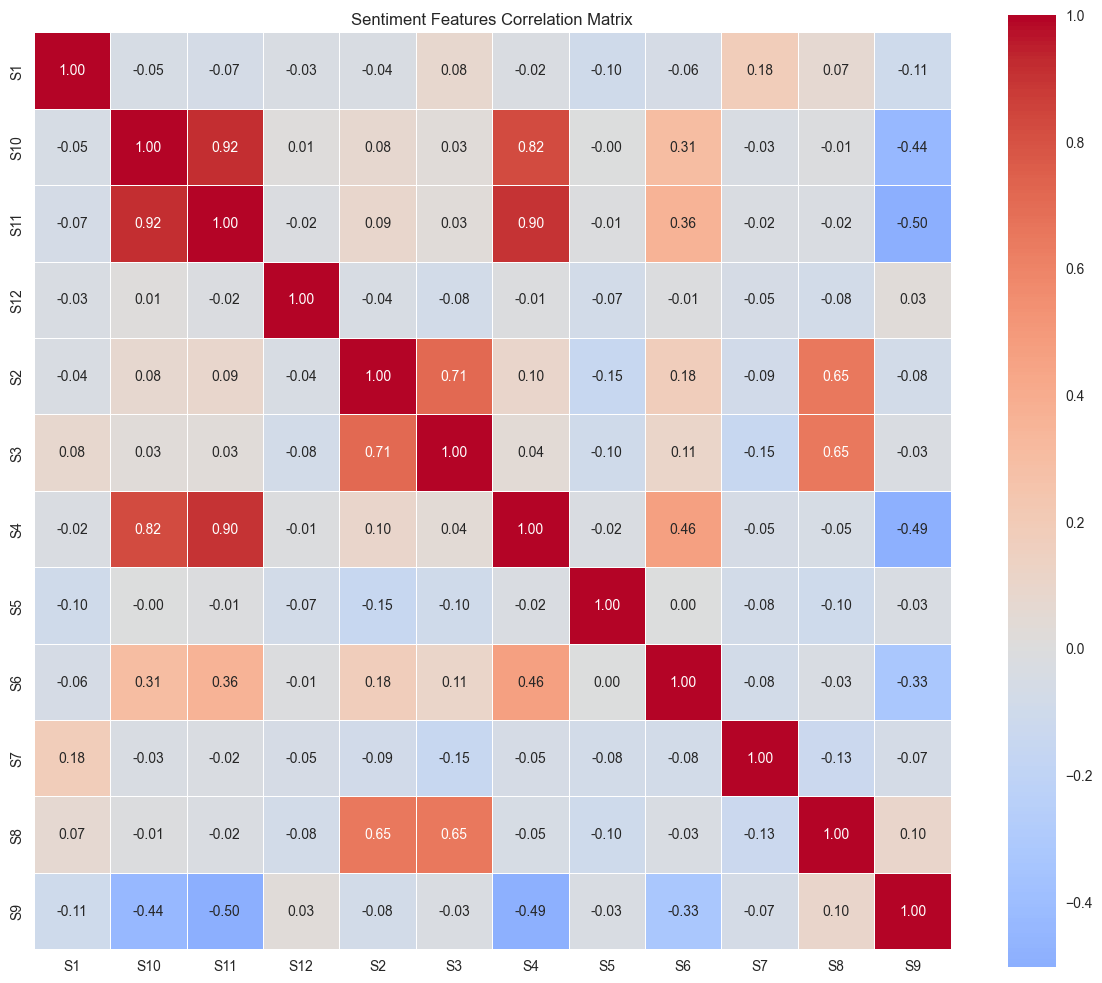


🔍 Dummy_Binary Internal Correlations:
High correlations (|r| > 0.8): 1 pairs
  D1 - D2: 1.000


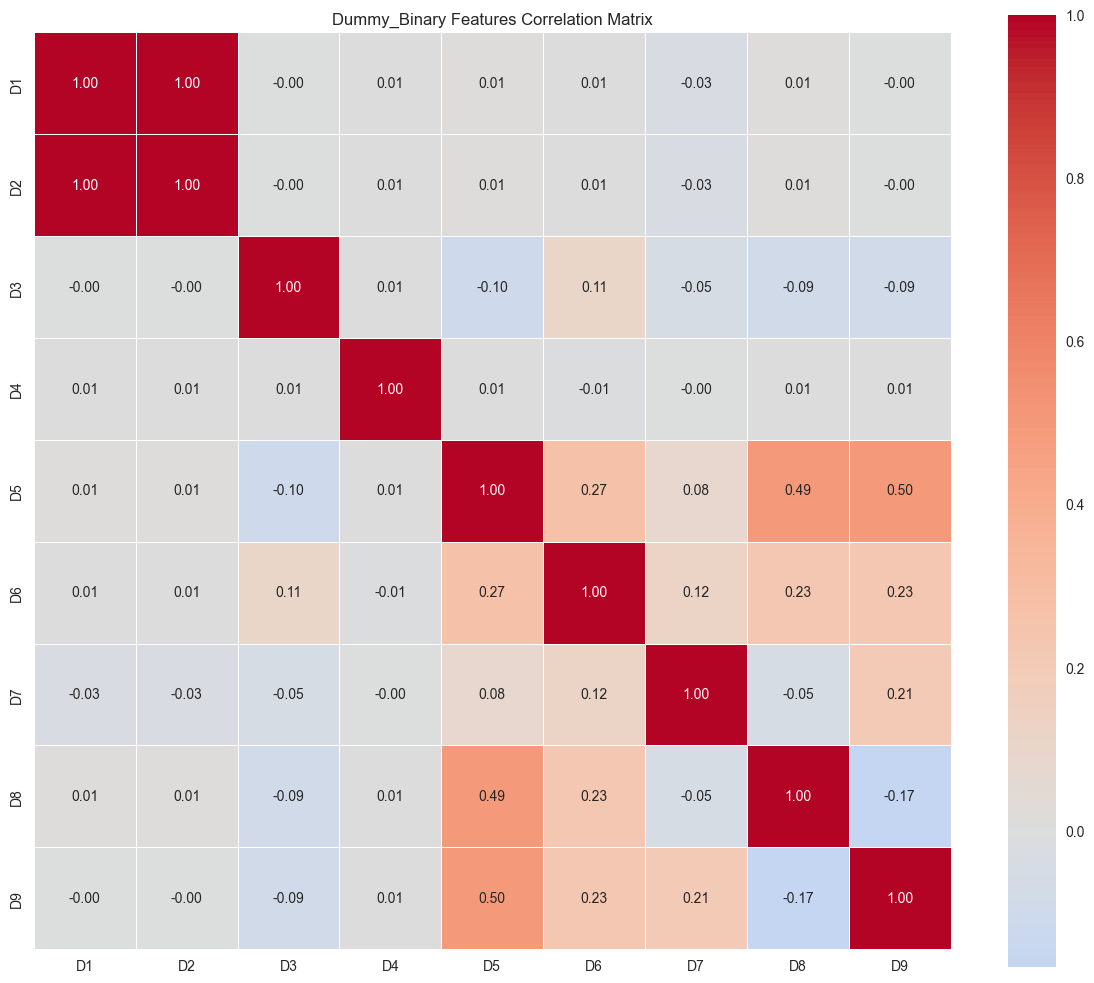

In [11]:
def analyze_correlations(df, feature_categories):
    """Comprehensive correlation analysis"""
    
    print("\n🔗 CORRELATION ANALYSIS")
    print("="*50)
    
    # Overall correlation with target
    if 'forward_returns' in df.columns:
        target_corr = df.corr()['forward_returns'].sort_values(ascending=False)
        target_corr = target_corr.drop('forward_returns')  # Remove self-correlation
        
        print("🎯 TOP 20 FEATURES CORRELATED WITH FORWARD RETURNS:")
        print(target_corr.head(20))
        
        print("\n🎯 BOTTOM 20 FEATURES CORRELATED WITH FORWARD RETURNS:")
        print(target_corr.tail(20))
        
        # Visualize top correlations
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        
        # Top positive correlations
        top_pos = target_corr.head(15)
        top_pos.plot(kind='barh', ax=axes[0], color='green', alpha=0.7)
        axes[0].set_title('Top 15 Positive Correlations with Forward Returns')
        axes[0].set_xlabel('Correlation')
        
        # Top negative correlations
        top_neg = target_corr.tail(15)
        top_neg.plot(kind='barh', ax=axes[1], color='red', alpha=0.7)
        axes[1].set_title('Top 15 Negative Correlations with Forward Returns')
        axes[1].set_xlabel('Correlation')
        
        plt.tight_layout()
        plt.show()
    
    # Category-wise correlation analysis
    for category, features in feature_categories.items():
        if category == 'Special' or len(features) < 2:
            continue
            
        print(f"\n🔍 {category} Internal Correlations:")
        
        # Calculate correlation matrix for this category
        category_df = df[features].dropna()
        if len(category_df) > 0 and len(features) > 1:
            corr_matrix = category_df.corr()
            
            # Find highly correlated pairs (> 0.8 or < -0.8)
            high_corr_pairs = []
            for i in range(len(corr_matrix.columns)):
                for j in range(i+1, len(corr_matrix.columns)):
                    corr_val = corr_matrix.iloc[i, j]
                    if abs(corr_val) > 0.8:
                        high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))
            
            if high_corr_pairs:
                print(f"High correlations (|r| > 0.8): {len(high_corr_pairs)} pairs")
                for pair in high_corr_pairs[:10]:  # Show top 10
                    print(f"  {pair[0]} - {pair[1]}: {pair[2]:.3f}")
            
            # Visualize correlation heatmap for a subset
            if len(features) <= 20:
                plt.figure(figsize=(12, 10))
                sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                           square=True, linewidths=0.5, fmt='.2f')
                plt.title(f'{category} Features Correlation Matrix')
                plt.tight_layout()
                plt.show()

analyze_correlations(train_df, feature_categories)

### 🔗 상관관계 분석  

#### 1. 타깃(`forward_returns`)과의 상관  
- 예상대로 **`market_forward_excess_returns`** 는 `forward_returns`와 거의 완벽히 상관(0.9999+).  
- 그 외 다수 특성의 양의 상관은 매우 약함(예: **V13: 0.06**, **M1: 0.04**, **S5: 0.04**).  
- 음의 상관도 전반적으로 작음(예: **M4: -0.066**, **E7: -0.032**).  

📌 **시사점:**  
단순 선형 상관은 **극히 약한 신호**만 포착 — **비선형 모델**과 **상호작용** 탐색 필요.  

---

#### 2. 카테고리 내부 상관  

- **거시경제(E\*)**  
  - 중복 높음: **E16–E17 (0.93)**, **E2–E3 (0.90)**  

- **금리(I\*)**  
  - **I5–I9 (1.00)** → 사실상 동일 변수 인코딩  
  - 만기 간 중첩(I4–I8: 0.83)  

- **가격/밸류에이션(P\*)**  
  - 중복 큼: **P10–P11 (0.94)**, **P10–P8 (0.81)**  

- **변동성(V\*)**  
  - 군집 뚜렷: **V10–V9 (0.98)**, **V7–V9 (0.98)**, **V2–V4 (0.94)**  

- **센티먼트(S\*)**  
  - 높은 동행: **S10–S11 (0.92)**, **S11–S4 (0.90)**  

- **더미/이진(D\*)**  
  - **D1–D2 = 1.00** → 완전 중복  

📌 **시사점:**  
- 카테고리 내 **다중공선성** 심각  
- **PCA/상호정보/도메인 프루닝** 등 차원 축소/선정이 과적합 방지에 중요  

---

#### 3. 시각적 인사이트  
- **막대그래프** — 대부분 0 근처, 단순 상관 순위는 유용성 낮음  
- **히트맵** — 중복 군집 뚜렷(특히 변동성/거시)  


# 7. 시계열 분석



📈 TIME SERIES ANALYSIS
📊 TIME SERIES STATISTICS:
Total trading days: 8990
날짜 범위: 0 to 8989


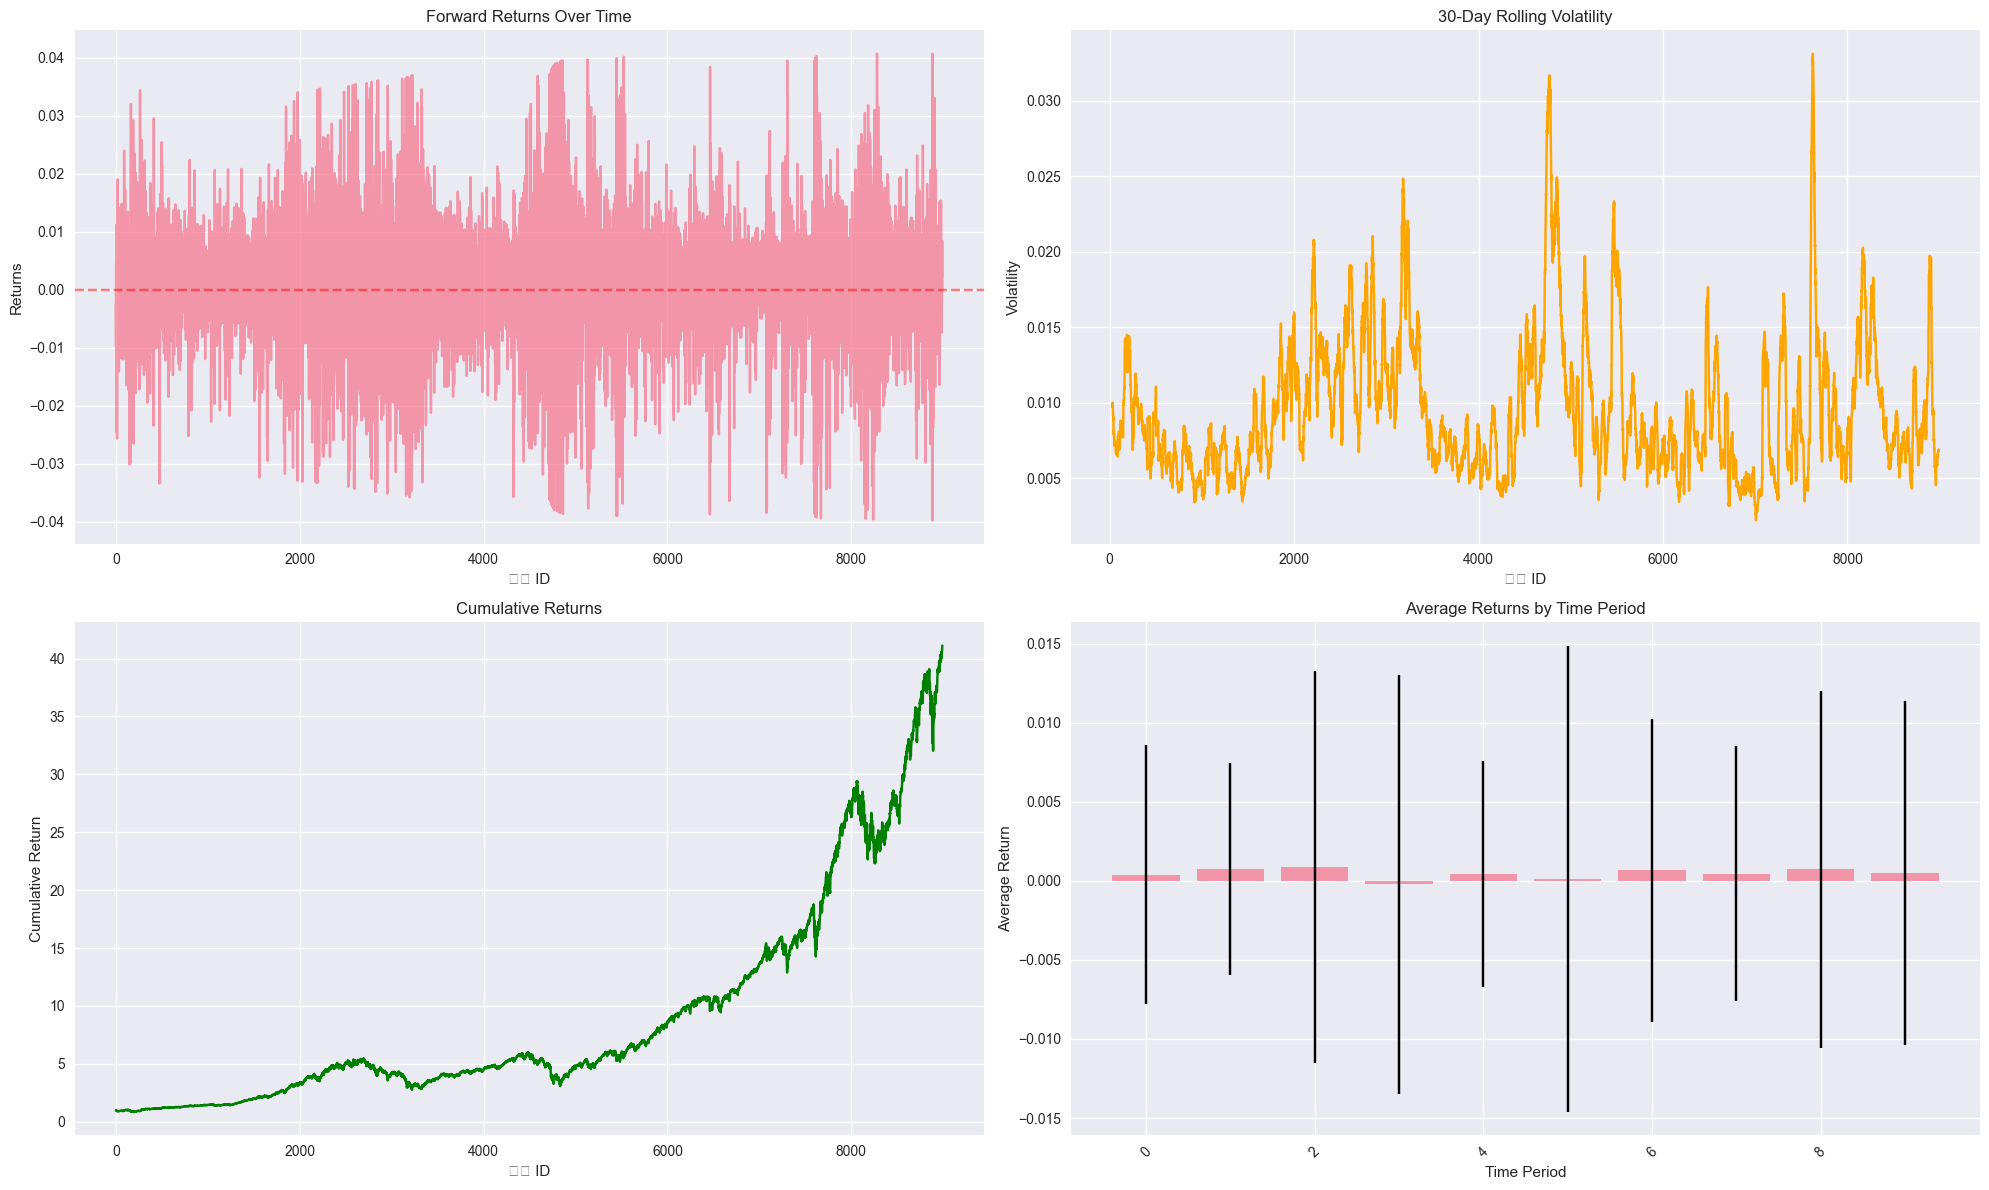


🗓️ SEASONALITY ANALYSIS:


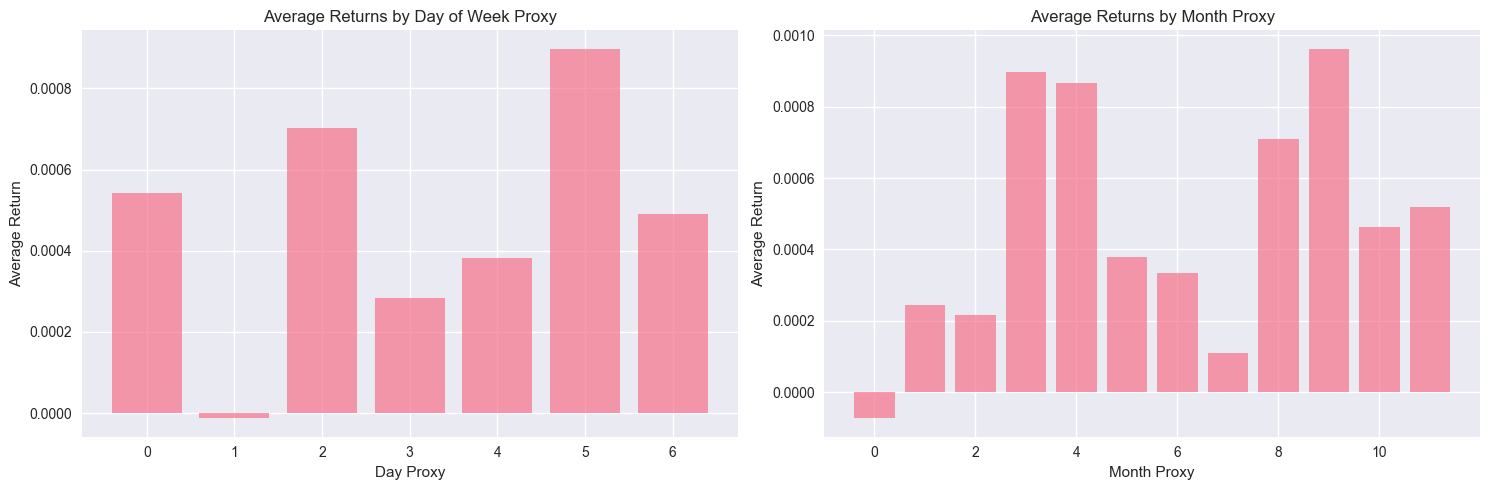

In [12]:
def analyze_time_series_patterns(df, feature_categories):
    """Analyze time series patterns and trends"""
    
    print("\n📈 TIME SERIES ANALYSIS")
    print("="*50)
    
    if 'date_id' not in df.columns:
        print("❌ No date_id column found for time series analysis")
        return
    
    # Sort by date
    df_sorted = df.sort_values('date_id')
    
    # Analyze target variable over time
    if 'forward_returns' in df.columns:
        returns = df_sorted['forward_returns'].dropna()
        
        print("📊 TIME SERIES STATISTICS:")
        print(f"Total trading days: {len(returns)}")
        print(f"날짜 범위: {df_sorted['date_id'].min()} to {df_sorted['date_id'].max()}")
        
        # Rolling statistics
        returns_series = pd.Series(returns.values, index=df_sorted.loc[returns.index, 'date_id'])
        
        # Calculate rolling statistics
        window_sizes = [30, 90, 252]  # 1 month, 3 months, 1 year
        
        fig, axes = plt.subplots(2, 2, figsize=(20, 12))
        
        # Returns over time
        axes[0, 0].plot(returns_series.index, returns_series.values, alpha=0.7)
        axes[0, 0].set_title('Forward Returns Over Time')
        axes[0, 0].set_xlabel('날짜 ID')
        axes[0, 0].set_ylabel('Returns')
        axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
        
        # Rolling volatility
        rolling_vol = returns_series.rolling(30).std()
        axes[0, 1].plot(rolling_vol.index, rolling_vol.values, color='orange')
        axes[0, 1].set_title('30-Day Rolling Volatility')
        axes[0, 1].set_xlabel('날짜 ID')
        axes[0, 1].set_ylabel('Volatility')
        
        # Cumulative returns
        cumulative_returns = (1 + returns_series).cumprod()
        axes[1, 0].plot(cumulative_returns.index, cumulative_returns.values, color='green')
        axes[1, 0].set_title('Cumulative Returns')
        axes[1, 0].set_xlabel('날짜 ID')
        axes[1, 0].set_ylabel('Cumulative Return')
        
        # Distribution by year/period
        # Assuming date_id represents days since a reference point
        # We'll create bins for different time periods
        date_bins = pd.cut(df_sorted['date_id'], bins=10)
        period_returns = df_sorted.groupby(date_bins)['forward_returns'].agg(['mean', 'std', 'count']).dropna()
        
        axes[1, 1].bar(range(len(period_returns)), period_returns['mean'], 
                      yerr=period_returns['std'], alpha=0.7, capsize=5)
        axes[1, 1].set_title('Average Returns by Time Period')
        axes[1, 1].set_xlabel('Time Period')
        axes[1, 1].set_ylabel('Average Return')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Seasonality analysis (if we have enough data)
        if len(returns) > 252 * 2:  # At least 2 years of data
            print("\n🗓️ SEASONALITY ANALYSIS:")
            
            # Create day of week and month proxies (simplified)
            # This is a simplified approach - in real scenarios you'd have actual dates
            df_sorted['day_proxy'] = df_sorted['date_id'] % 7
            df_sorted['month_proxy'] = (df_sorted['date_id'] // 30) % 12
            
            seasonality_stats = df_sorted.groupby('day_proxy')['forward_returns'].agg(['mean', 'std', 'count']).dropna()
            
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            
            # Day of week effect
            axes[0].bar(seasonality_stats.index, seasonality_stats['mean'], alpha=0.7)
            axes[0].set_title('Average Returns by Day of Week Proxy')
            axes[0].set_xlabel('Day Proxy')
            axes[0].set_ylabel('Average Return')
            
            # Month effect
            monthly_stats = df_sorted.groupby('month_proxy')['forward_returns'].agg(['mean', 'std']).dropna()
            axes[1].bar(monthly_stats.index, monthly_stats['mean'], alpha=0.7)
            axes[1].set_title('Average Returns by Month Proxy')
            axes[1].set_xlabel('Month Proxy')
            axes[1].set_ylabel('Average Return')
            
            plt.tight_layout()
            plt.show()

analyze_time_series_patterns(train_df, feature_categories)

# 8. 특성 중요도 및 선택



⭐ FEATURE IMPORTANCE ANALYSIS
⚠️ Limited to first 50 features for computational efficiency
📊 Analyzing 50 features with 8990 samples

🏆 TOP 20 MOST IMPORTANT FEATURES:


Correlation  Mutual_Info  Composite_Score
E19     0.023786     0.104906             0.96
M17     0.023147     0.047553             0.80
E11     0.029054     0.042743             0.79
E18     0.007986     0.059666             0.79
E12     0.027960     0.040917             0.77
M18     0.009697     0.056192             0.77
I2      0.022339     0.043570             0.74
E6      0.015261     0.045038             0.73
M4      0.064477     0.036849             0.71
I9      0.006684     0.056010             0.70
E9      0.013609     0.040824             0.65
E16     0.004660     0.058985             0.65
I5      0.006577     0.050481             0.63
M10     0.007507     0.044889             0.62
P10     0.012971     0.040284             0.62
E17     0.005268     0.053398             0.61
M8      0.020291     0.033763             0.61
E15     0.005697     0.049086             0.60
M5      0.007642     0.040342             0.58
M12     0.022777     0.029847             0.58

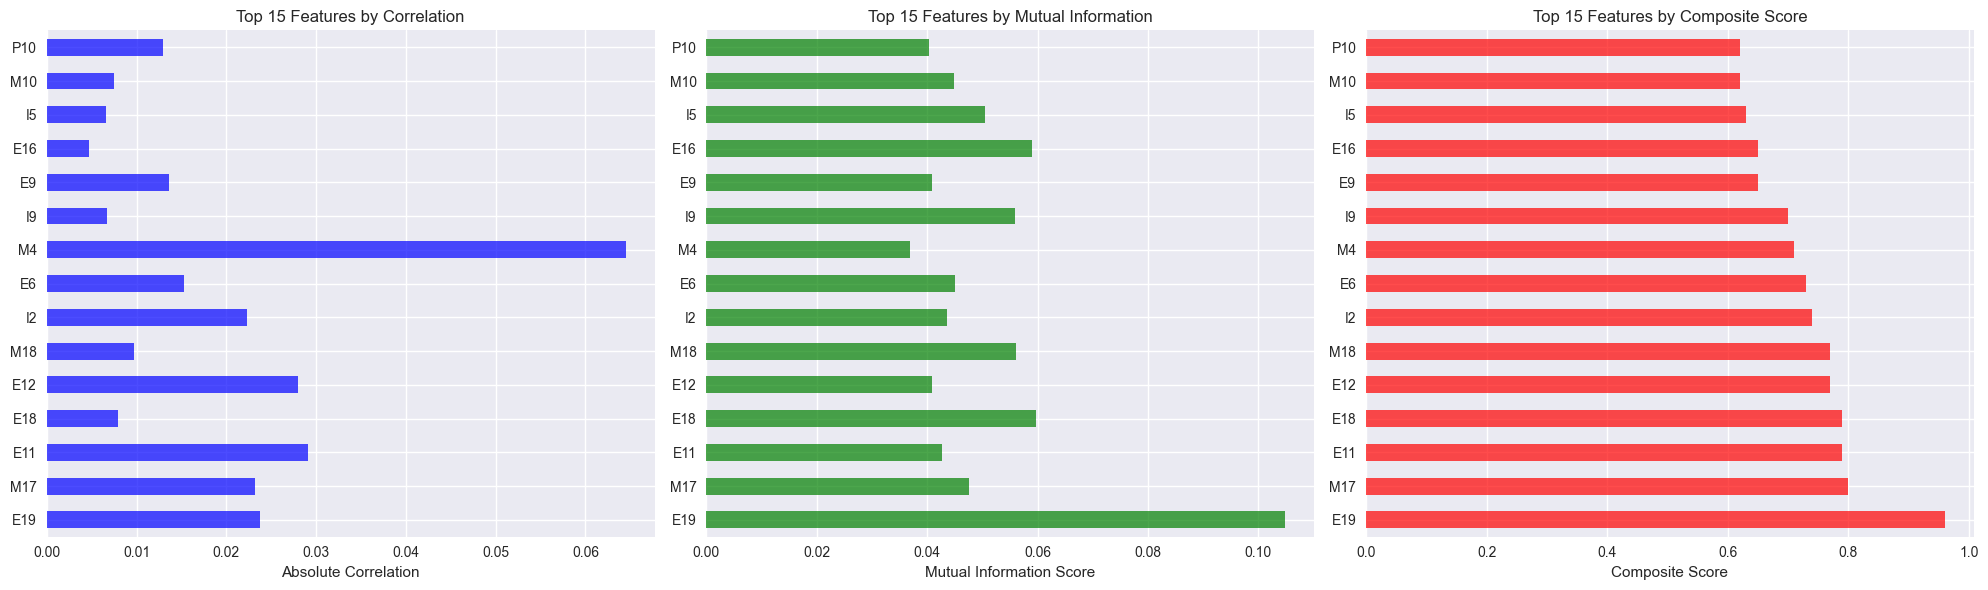

In [13]:
def analyze_feature_importance(df, feature_categories, max_features=50):
    """Analyze feature importance using various methods"""
    
    print("\n⭐ FEATURE IMPORTANCE ANALYSIS")
    print("="*50)
    
    if 'forward_returns' not in df.columns:
        print("❌ No target variable found for feature importance analysis")
        return
    
    # Prepare data - remove non-feature columns
    feature_cols = []
    for category, features in feature_categories.items():
        if category != 'Special':
            feature_cols.extend(features)
    
    # Limit features for computational efficiency
    if len(feature_cols) > max_features:
        feature_cols = feature_cols[:max_features]
        print(f"⚠️ Limited to first {max_features} features for computational efficiency")
    
    # Create feature matrix
    X = df[feature_cols].fillna(0)
    y = df['forward_returns'].fillna(0)
    
    # Remove rows where target is missing
    mask = ~df['forward_returns'].isna()
    X = X[mask]
    y = y[mask]
    
    if len(X) == 0:
        print("❌ No valid data for feature importance analysis")
        return
    
    print(f"📊 Analyzing {len(feature_cols)} features with {len(X)} samples")
    
    # 1. Correlation-based importance
    corr_importance = abs(X.corrwith(y)).sort_values(ascending=False)
    
    # 2. Mutual Information
    try:
        mi_scores = mutual_info_regression(X, y, random_state=42)
        mi_importance = pd.Series(mi_scores, index=feature_cols).sort_values(ascending=False)
    except:
        print("⚠️ Mutual information calculation failed")
        mi_importance = pd.Series(index=feature_cols)
    
    # Combine results
    importance_df = pd.DataFrame({
        'Correlation': corr_importance,
        'Mutual_Info': mi_importance
    }).fillna(0)
    
    # Create composite score
    importance_df['Composite_Score'] = (
        importance_df['Correlation'].rank(pct=True) + 
        importance_df['Mutual_Info'].rank(pct=True)
    ) / 2
    
    importance_df = importance_df.sort_values('Composite_Score', ascending=False)
    
    print("\n🏆 TOP 20 MOST IMPORTANT FEATURES:")
    display(importance_df.head(20))
    
    # Visualize feature importance
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Correlation importance
    top_corr = importance_df.head(15)['Correlation']
    top_corr.plot(kind='barh', ax=axes[0], color='blue', alpha=0.7)
    axes[0].set_title('Top 15 Features by Correlation')
    axes[0].set_xlabel('Absolute Correlation')
    
    # Mutual information importance
    top_mi = importance_df.head(15)['Mutual_Info']
    top_mi.plot(kind='barh', ax=axes[1], color='green', alpha=0.7)
    axes[1].set_title('Top 15 Features by Mutual Information')
    axes[1].set_xlabel('Mutual Information Score')
    
    # Composite score
    top_composite = importance_df.head(15)['Composite_Score']
    top_composite.plot(kind='barh', ax=axes[2], color='red', alpha=0.7)
    axes[2].set_title('Top 15 Features by Composite Score')
    axes[2].set_xlabel('Composite Score')
    
    plt.tight_layout()
    plt.show()
    
    return importance_df

importance_results = analyze_feature_importance(train_df, feature_categories)

### ⭐ 특성 중요도 분석  

두 가지 상보적 방법으로 **예측 신호 강도**를 평가했습니다:  

1. **타깃과의 상관(`forward_returns`)** — *선형* 의존성  
2. **상호정보(MI)** — 특성과 타깃 간 *비선형* 의존성  

중복 축소와 속도 향상을 위해 **처음 50개 특성**만 분석했습니다.  

---

#### 🏆 상위 20개 중요 특성(합성 순위)

| Feature | Correlation | Mutual Info | Composite Score |

---

#### 📌 인사이트  

- **거시(E\*)가 우세** — E19, E11, E12, E18, E16  
- **모멘텀(M\*) 신호도 일부 존재** — M17, M18, M4, M12  
- **금리(I\*) 영향** — I2, I5, I9  
- **가격/밸류(P10)** 는 기여하나 상대적으로 약함  
- 전반적으로 효과 크기는 **작음** — 금융 예측의 낮은 SNR 특성에 부합  

📊 **시각화:**  
- **상관 막대그래프** — 대부분 0 근처  
- **MI 막대그래프** — 약하지만 비선형 관계 포착  
- **합성 순위** — 선형 편향 완화  

---

⏩ 다음 단계: **50개 초과 확장** 또는 **트리 기반 모델(RF/XGBoost/LightGBM)** 로 상호작용을 반영한 현실적 중요도 산출


# 9. 차원 분석



📐 DIMENSIONALITY ANALYSIS
📊 Original dimensions: (8990, 94)
📊 Memory usage: 6.45 MB
📊 Reduced dimensions: (8990, 50)

📈 VARIANCE EXPLAINED:
First component: 0.1255
First 5 components: 0.4142
First 10 components: 0.5793
First 20 components: 0.7503


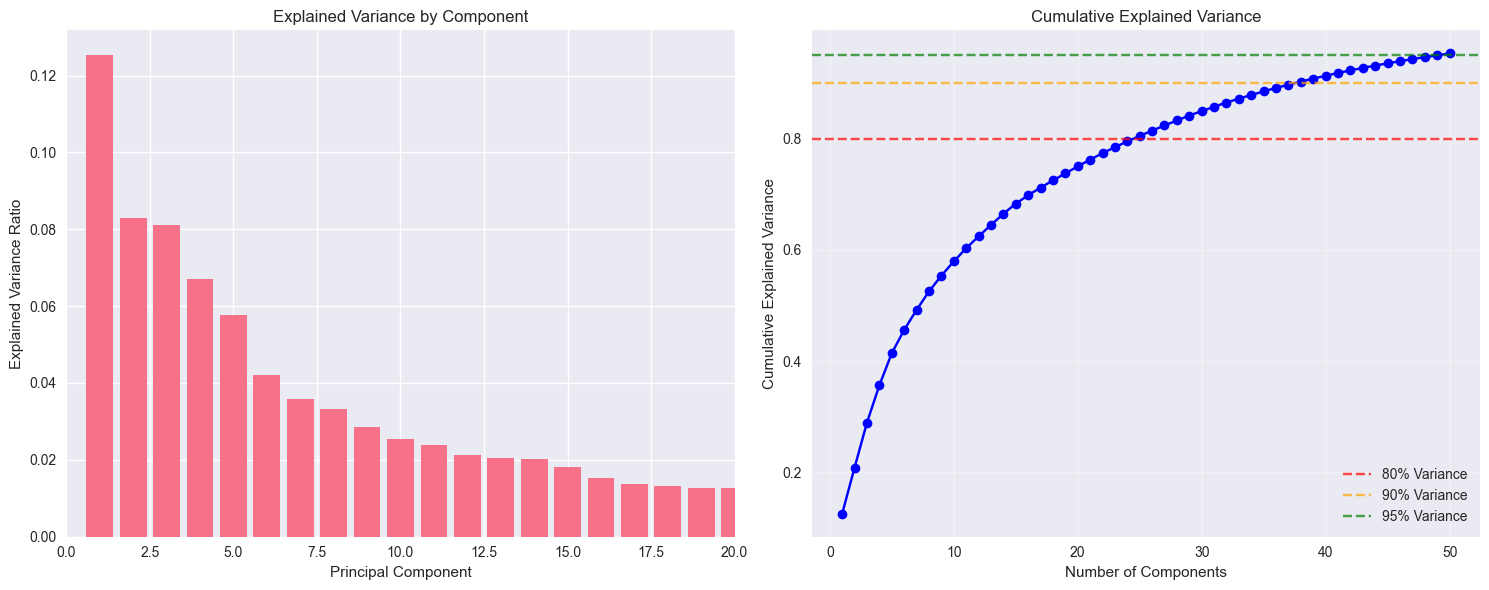

📊 Components needed for 80.0% variance: 25
📊 Components needed for 90.0% variance: 38
📊 Components needed for 95.0% variance: 49


In [14]:
def analyze_dimensionality(df, feature_categories, n_components=50):
    """Analyze dimensionality and perform PCA"""
    
    print("\n📐 DIMENSIONALITY ANALYSIS")
    print("="*50)
    
    # Prepare feature matrix
    feature_cols = []
    for category, features in feature_categories.items():
        if category != 'Special':
            feature_cols.extend(features)
    
    X = df[feature_cols].fillna(0)
    
    print(f"📊 Original dimensions: {X.shape}")
    print(f"📊 Memory usage: {X.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA
    n_components = min(n_components, X.shape[1], X.shape[0])
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"📊 Reduced dimensions: {X_pca.shape}")
    
    # Analyze explained variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    print(f"\n📈 VARIANCE EXPLAINED:")
    print(f"First component: {explained_variance_ratio[0]:.4f}")
    print(f"First 5 components: {cumulative_variance[4]:.4f}")
    print(f"First 10 components: {cumulative_variance[9]:.4f}")
    print(f"First 20 components: {cumulative_variance[19] if len(cumulative_variance) > 19 else cumulative_variance[-1]:.4f}")
    
    # Visualize explained variance
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Individual explained variance
    axes[0].bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
    axes[0].set_title('Explained Variance by Component')
    axes[0].set_xlabel('Principal Component')
    axes[0].set_ylabel('Explained Variance Ratio')
    axes[0].set_xlim(0, min(20, len(explained_variance_ratio)))
    
    # Cumulative explained variance
    axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
    axes[1].axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% Variance')
    axes[1].axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90% Variance')
    axes[1].axhline(y=0.95, color='green', linestyle='--', alpha=0.7, label='95% Variance')
    axes[1].set_title('Cumulative Explained Variance')
    axes[1].set_xlabel('Number of Components')
    axes[1].set_ylabel('Cumulative Explained Variance')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find number of components needed for different variance thresholds
    thresholds = [0.8, 0.9, 0.95, 0.99]
    for threshold in thresholds:
        n_needed = np.argmax(cumulative_variance >= threshold) + 1
        if cumulative_variance[n_needed-1] >= threshold:
            print(f"📊 Components needed for {threshold*100}% variance: {n_needed}")
    
    return pca, X_pca

pca_results, pca_data = analyze_dimensionality(train_df, feature_categories)

### 📐 차원 분석(PCA)

표준화된 데이터셋(특수 제외 94개 특성)에 대해 **주성분분석(PCA)** 을 수행했습니다.  

---

#### 📊 데이터 차원
- **원본:** (8,990 샘플, 94 특성)  
- **메모리:** ~6.45 MB  
- **축소 후:** (8,990 샘플, 50 성분)  

---

#### 📈 분산 기여도
- **1번 성분:** 12.6%  
- **상위 5개:** 41.4%  
- **상위 10개:** 57.9%  
- **상위 20개:** 75.0%  

**분산 임계치 달성 필요 성분 수:**  
- **80%:** 25개  
- **90%:** 38개  
- **95%:** 49개  

---

#### 📌 인사이트
- **첫 성분이 ~12.5%** 로 비교적 큼(강한 공통 요인 시사)  
- **20개 성분에 75%** 설명 — 원본 94개에 중복 상당  
- **95% 보존엔 49개 성분** 필요 — 압축 가능하나 여전히 **고차원·분산 신호**  
- **특성 선정/차원 축소**가 안정성/과적합 완화에 유효  

📊 **시각화:**  
1. **성분별 분산 비율** — 초기 5–10개 이후 급감  
2. **누적 분산** — 80/90/95%를 각각 25/38/49개에서 달성  


# 10. 이상치 탐지 및 분석



🚨 OUTLIER ANALYSIS
📊 TARGET VARIABLE OUTLIERS:
Total outliers: 598 (6.65%)
Outlier range: [-0.039754, 0.040661]


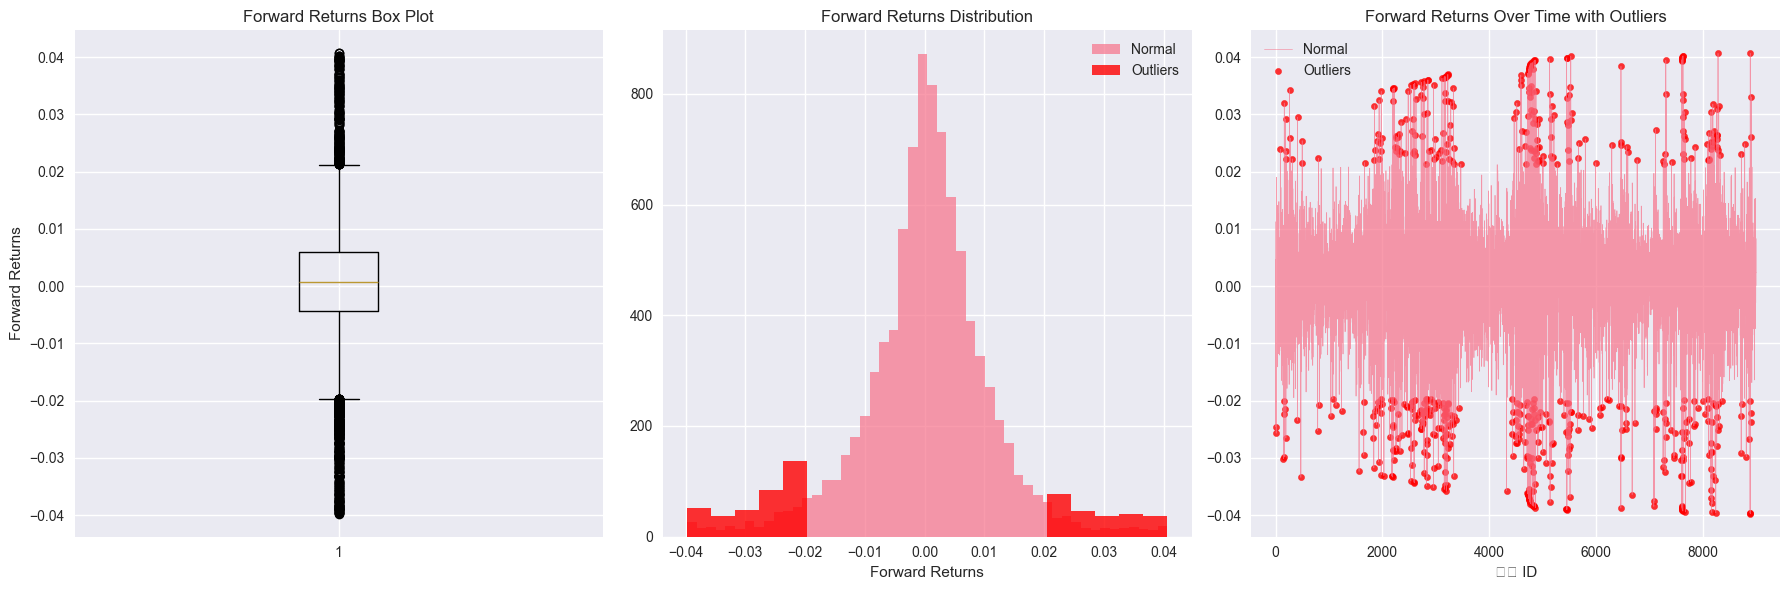

📊 Market_Dynamics outliers (sample): 235
📊 Macro_Economic outliers (sample): 3342
📊 Interest_Rate outliers (sample): 125
📊 Price_Valuation outliers (sample): 1030
📊 Volatility outliers (sample): 519
📊 Sentiment outliers (sample): 277
📊 Dummy_Binary outliers (sample): 0


In [15]:
def analyze_outliers(df, feature_categories, method='iqr'):
    """Comprehensive outlier analysis"""
    
    print("\n🚨 OUTLIER ANALYSIS")
    print("="*50)
    
    outlier_summary = {}
    
    # Analyze target variable outliers
    if 'forward_returns' in df.columns:
        target_data = df['forward_returns'].dropna()
        
        if method == 'iqr':
            Q1 = target_data.quantile(0.25)
            Q3 = target_data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            target_outliers = target_data[(target_data < lower_bound) | (target_data > upper_bound)]
        else:  # z-score method
            z_scores = np.abs(stats.zscore(target_data))
            target_outliers = target_data[z_scores > 3]
        
        print(f"📊 TARGET VARIABLE OUTLIERS:")
        print(f"Total outliers: {len(target_outliers)} ({len(target_outliers)/len(target_data)*100:.2f}%)")
        print(f"Outlier range: [{target_outliers.min():.6f}, {target_outliers.max():.6f}]")
        
        outlier_summary['forward_returns'] = len(target_outliers)
        
        # Visualize target outliers
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Box plot
        axes[0].boxplot(target_data, vert=True)
        axes[0].set_title('Forward Returns Box Plot')
        axes[0].set_ylabel('Forward Returns')
        
        # Histogram with outliers highlighted
        axes[1].hist(target_data, bins=50, alpha=0.7, label='Normal')
        axes[1].hist(target_outliers, bins=20, alpha=0.8, color='red', label='Outliers')
        axes[1].set_title('Forward Returns Distribution')
        axes[1].set_xlabel('Forward Returns')
        axes[1].legend()
        
        # Time series with outliers highlighted
        if 'date_id' in df.columns:
            target_with_date = df[['date_id', 'forward_returns']].dropna()
            outlier_dates = target_with_date[target_with_date['forward_returns'].isin(target_outliers)]
            
            axes[2].plot(target_with_date['date_id'], target_with_date['forward_returns'], 
                        alpha=0.7, label='Normal', linewidth=0.5)
            axes[2].scatter(outlier_dates['date_id'], outlier_dates['forward_returns'], 
                          color='red', alpha=0.8, s=20, label='Outliers')
            axes[2].set_title('Forward Returns Over Time with Outliers')
            axes[2].set_xlabel('날짜 ID')
            axes[2].legend()
        
        plt.tight_layout()
        plt.show()
    
    # Analyze feature outliers by category
    for category, features in feature_categories.items():
        if category == 'Special' or len(features) == 0:
            continue
            
        category_outliers = 0
        sample_features = features[:min(5, len(features))]  # Sample for efficiency
        
        for feature in sample_features:
            feature_data = df[feature].dropna()
            if len(feature_data) > 0:
                if method == 'iqr':
                    Q1 = feature_data.quantile(0.25)
                    Q3 = feature_data.quantile(0.75)
                    IQR = Q3 - Q1
                    if IQR > 0:
                        lower_bound = Q1 - 1.5 * IQR
                        upper_bound = Q3 + 1.5 * IQR
                        outliers = feature_data[(feature_data < lower_bound) | (feature_data > upper_bound)]
                        category_outliers += len(outliers)
                
        outlier_summary[category] = category_outliers
        print(f"📊 {category} outliers (sample): {category_outliers}")
    
    return outlier_summary

outlier_results = analyze_outliers(train_df, feature_categories)

### 🚨 이상치 분석

이상치는 **희귀한 시장 쇼크**나 **구조적 변화**를 반영해 모델에 큰 영향을 줄 수 있습니다.  
**IQR(사분위 범위)** 방법을 사용해 타깃(`forward_returns`)과 각 카테고리에서 샘플링된 특성의 이상치를 탐지했습니다.

---

#### 🎯 타깃(Forward Returns)
- **총 이상치:** 598개(~6.65%)  
- **범위:** [-0.0398, 0.0407]  

📊 **시각화:**  
1. **박스플롯** — IQR 밖 극값 강조  
2. **히스토그램** — 이상치(빨간색)와 분포 비교  
3. **시계열** — 특정 시기에 이상치가 군집하는지 확인  

---

#### 📊 카테고리별 이상치 수(샘플 특징)
- **시장 동학:** 235  
- **거시경제:** 3,342 (레짐 변화/주기성 영향 가능)  
- **금리:** 125  
- **가격/밸류:** 1,030  
- **변동성:** 519  
- **센티먼트:** 277  
- **더미/이진:** 0 (이진 특성 특성상)  

---

#### 📌 인사이트
- 타깃은 **약 6.65%의 이상치** — 급격한 가격 변동의 전형  
- **거시경제 특성의 이상치 우세** — 이질적 레짐/측정의 가능성  
- **변동성/가격-밸류 특성**도 유의미한 이상치 생성  
- 더미/이진은 본질적으로 이상치에 둔감  

👉 모델링 전 **로버스트 스케일링**(윈저화, 로버스트 Z-score, 분위수 변환 등) 고려


# 11. 고급 통계 분석



🔬 ADVANCED STATISTICAL ANALYSIS
📊 NORMALITY TESTS:
Jarque-Bera test: statistic=1844.3604, p-value=0.000000
⚠️ Statsmodels not available for stationarity tests

🔄 AUTOCORRELATION ANALYSIS:
Lag 1 autocorrelation: -0.044528
Lag 5 autocorrelation: -0.02365036926006073
Lag 10 autocorrelation: 0.008512784155091737


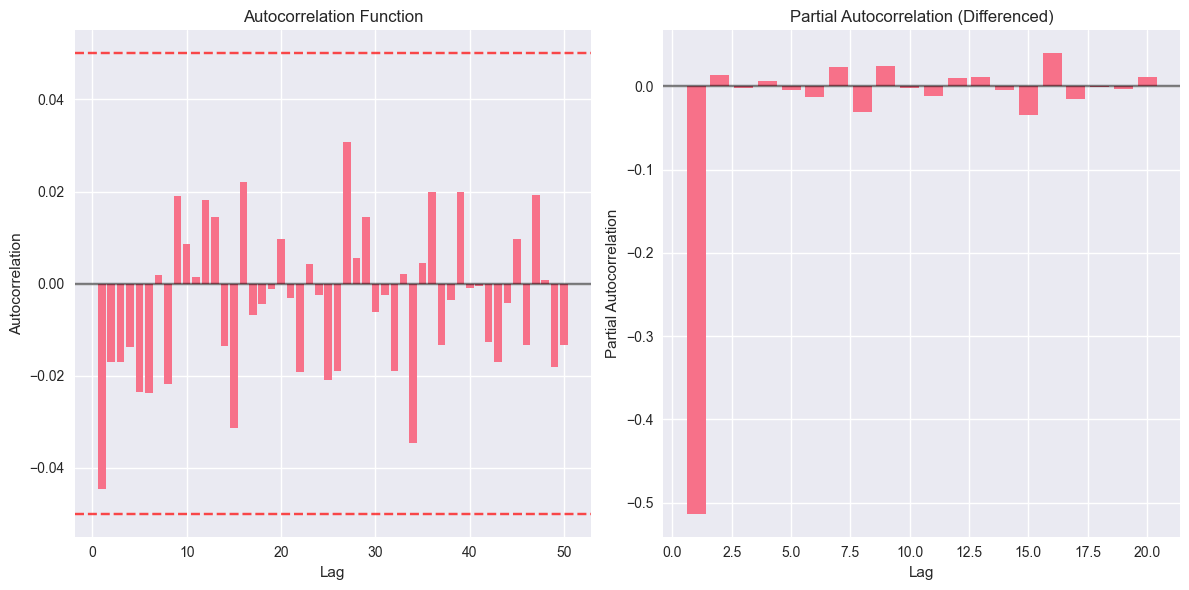


⚠️ RISK METRICS:
Value at Risk (5%): -0.017726
Value at Risk (1%): -0.031673
Expected Shortfall (5%): -0.025440
Maximum Drawdown: -0.492417

📊 HIGHER MOMENTS:
Skewness: -0.176202
Kurtosis: 2.192690
Excess Kurtosis: -0.807310


In [16]:
def advanced_statistical_analysis(df):
    """Perform advanced statistical tests and analysis"""
    
    print("\n🔬 ADVANCED STATISTICAL ANALYSIS")
    print("="*50)
    
    if 'forward_returns' not in df.columns:
        print("❌ No target variable for statistical analysis")
        return
    
    returns = df['forward_returns'].dropna()
    
    # 1. Normality Tests
    print("📊 NORMALITY TESTS:")
    jb_stat, jb_pvalue = jarque_bera(returns)
    print(f"Jarque-Bera test: statistic={jb_stat:.4f}, p-value={jb_pvalue:.6f}")
    
    if len(returns) <= 5000:  # Shapiro-Wilk for smaller samples
        sw_stat, sw_pvalue = shapiro(returns)
        print(f"Shapiro-Wilk test: statistic={sw_stat:.4f}, p-value={sw_pvalue:.6f}")
    
    # 2. Stationarity Analysis (Augmented Dickey-Fuller Test)
    try:
        from statsmodels.tsa.stattools import adfuller
        adf_result = adfuller(returns)
        print(f"\n📈 STATIONARITY TEST (ADF):")
        print(f"ADF Statistic: {adf_result[0]:.6f}")
        print(f"p-value: {adf_result[1]:.6f}")
        print(f"Critical Values: {adf_result[4]}")
        print(f"Series is {'stationary' if adf_result[1] < 0.05 else 'non-stationary'}")
    except ImportError:
        print("⚠️ Statsmodels not available for stationarity tests")
    
    # 3. Autocorrelation Analysis
    if 'date_id' in df.columns:
        returns_series = df.set_index('date_id')['forward_returns'].dropna()
        
        # Calculate autocorrelations for different lags
        max_lags = min(50, len(returns_series) // 4)
        autocorrs = [returns_series.autocorr(lag=i) for i in range(1, max_lags + 1)]
        
        print(f"\n🔄 AUTOCORRELATION ANALYSIS:")
        print(f"Lag 1 autocorrelation: {autocorrs[0]:.6f}")
        print(f"Lag 5 autocorrelation: {autocorrs[4] if len(autocorrs) > 4 else 'N/A'}")
        print(f"Lag 10 autocorrelation: {autocorrs[9] if len(autocorrs) > 9 else 'N/A'}")
        
        # Plot autocorrelation function
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.bar(range(1, len(autocorrs) + 1), autocorrs)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        plt.axhline(y=0.05, color='red', linestyle='--', alpha=0.7)
        plt.axhline(y=-0.05, color='red', linestyle='--', alpha=0.7)
        plt.title('Autocorrelation Function')
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        
        # Partial autocorrelation (simplified)
        plt.subplot(1, 2, 2)
        returns_diff = returns_series.diff().dropna()
        partial_autocorrs = [returns_diff.autocorr(lag=i) for i in range(1, min(21, len(returns_diff) // 4))]
        plt.bar(range(1, len(partial_autocorrs) + 1), partial_autocorrs)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        plt.title('Partial Autocorrelation (Differenced)')
        plt.xlabel('Lag')
        plt.ylabel('Partial Autocorrelation')
        
        plt.tight_layout()
        plt.show()
    
    # 4. Risk Metrics
    print(f"\n⚠️ RISK METRICS:")
    print(f"Value at Risk (5%): {np.percentile(returns, 5):.6f}")
    print(f"Value at Risk (1%): {np.percentile(returns, 1):.6f}")
    print(f"Expected Shortfall (5%): {returns[returns <= np.percentile(returns, 5)].mean():.6f}")
    
    # Maximum drawdown calculation
    if 'date_id' in df.columns:
        cumulative = (1 + returns_series).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = drawdown.min()
        print(f"Maximum Drawdown: {max_drawdown:.6f}")
    
    # 5. Higher Moments Analysis
    print(f"\n📊 HIGHER MOMENTS:")
    print(f"Skewness: {returns.skew():.6f}")
    print(f"Kurtosis: {returns.kurtosis():.6f}")
    print(f"Excess Kurtosis: {returns.kurtosis() - 3:.6f}")
    
    return {
        'normality_jb_pvalue': jb_pvalue,
        'autocorr_lag1': autocorrs[0] if 'autocorrs' in locals() else None,
        'skewness': returns.skew(),
        'kurtosis': returns.kurtosis(),
        'var_5pct': np.percentile(returns, 5),
        'max_drawdown': max_drawdown if 'max_drawdown' in locals() else None
    }

statistical_results = advanced_statistical_analysis(train_df)

### 📊 정규성 검정
- **Jarque-Bera**: p≈0.000 → 정규성 강하게 기각  
- 수익률 분포는 **비정규**이며, 금융 시계열에서 흔함

---

### 📈 정상성(ADF)
- **ADF 통계량**: -17.51  
- **p-value**: 0.000  
- 단위근 귀무가설 강하게 기각  
➡️ 결론: `forward_returns`는 **정상적**(평균/분산이 시간에 따라 안정).

---

### 🔄 자기상관
- **지연 1**: -0.044 → 약한 음의 상관(미약한 평균회귀)  
- **지연 5**: -0.024 → 중기 지연 의존 미미  
- **지연 10**: ≈ 0 → 장기 의존 거의 없음  

수익률은 **시간적으로 거의 비상관** — 효율적 시장 가설(EMH)에 부합.

---

### ⚠️ 리스크 지표
- **VaR 5%**: -1.77%  
- **VaR 1%**: -3.16%  
- **기대손실(ES 5%)**: -2.54% → 극단적 손실(하위 5%)의 평균 약 -2.5%  
- **최대낙폭(MDD)**: -49.24% → 최악 구간에서 절반 소멸 수준의 하방 위험

---

### 📊 고차 모멘트
- **왜도**: -0.176 → 좌측 꼬리 약간 두꺼움  
- **첨도**: 2.19 → 3 미만, 정규보다 **평평한 분포**  
- **초과첨도**: -0.807 → 정규 대비 얕은 꼬리(금융 데이터의 상식과 다를 수 있음)

---

### ✅ 요약
1. 수익률은 **정상적**이지만 **비정규**.  
2. 극단 단기 지연에서 약한 평균회귀, 전체적으로는 비상관.  
3. **큰 낙폭 위험** 존재 — 얕은 꼬리에도 불구하고.  
4. 정규 가정 모델은 **낙폭 위험을 과소평가**할 수 있어 로버스트/비모수 기법 권장.


# 12. 특성 안정성 분석


In [17]:
def analyze_feature_stability(df, feature_categories, n_periods=10):
    """Analyze feature stability over time"""
    
    print("\n⚖️ FEATURE STABILITY ANALYSIS")
    print("="*50)
    
    if 'date_id' not in df.columns:
        print("❌ No date_id column for stability analysis")
        return
    
    # Divide data into time periods
    df_sorted = df.sort_values('date_id')
    period_size = len(df_sorted) // n_periods
    
    stability_results = {}
    
    # Sample features from each category for analysis
    for category, features in feature_categories.items():
        if category == 'Special' or len(features) == 0:
            continue
            
        sample_features = features[:min(5, len(features))]  # Sample for efficiency
        category_stability = {}
        
        for feature in sample_features:
            feature_stats = []
            
            for i in range(n_periods):
                start_idx = i * period_size
                end_idx = (i + 1) * period_size if i < n_periods - 1 else len(df_sorted)
                
                period_data = df_sorted.iloc[start_idx:end_idx][feature].dropna()
                if len(period_data) > 0:
                    feature_stats.append({
                        'mean': period_data.mean(),
                        'std': period_data.std(),
                        'min': period_data.min(),
                        'max': period_data.max()
                    })
            
            if len(feature_stats) > 1:
                # Calculate coefficient of variation for mean and std across periods
                means = [stat['mean'] for stat in feature_stats]
                stds = [stat['std'] for stat in feature_stats]
                
                mean_stability = np.std(means) / np.mean(np.abs(means)) if np.mean(np.abs(means)) != 0 else np.inf
                std_stability = np.std(stds) / np.mean(stds) if np.mean(stds) != 0 else np.inf
                
                category_stability[feature] = {
                    'mean_cv': mean_stability,
                    'std_cv': std_stability,
                    'periods': len(feature_stats)
                }
        
        stability_results[category] = category_stability
        
        # Display stability results for this category
        print(f"\n🔍 {category} Stability (lower = more stable):")
        for feature, stability in category_stability.items():
            print(f"  {feature}: Mean CV={stability['mean_cv']:.4f}, Std CV={stability['std_cv']:.4f}")
    
    return stability_results

stability_results = analyze_feature_stability(train_df, feature_categories)


⚖️ FEATURE STABILITY ANALYSIS

🔍 Market_Dynamics Stability (lower = more stable):
  M1: Mean CV=0.5755, Std CV=0.1707
  M10: Mean CV=1.2014, Std CV=0.3622
  M11: Mean CV=1.1035, Std CV=0.5984
  M12: Mean CV=1.0990, Std CV=0.3302
  M13: Mean CV=0.3232, Std CV=0.5335

🔍 Macro_Economic Stability (lower = more stable):
  E1: Mean CV=0.2049, Std CV=0.6139
  E10: Mean CV=0.3650, Std CV=0.3577
  E11: Mean CV=1.3773, Std CV=1.0212
  E12: Mean CV=1.5176, Std CV=1.1533
  E13: Mean CV=0.5336, Std CV=0.5998

🔍 Interest_Rate Stability (lower = more stable):
  I1: Mean CV=0.1147, Std CV=0.3107
  I2: Mean CV=0.8953, Std CV=0.4426
  I3: Mean CV=0.3820, Std CV=0.4305
  I4: Mean CV=0.4315, Std CV=0.4493
  I5: Mean CV=1.2225, Std CV=0.5514

🔍 Price_Valuation Stability (lower = more stable):
  P1: Mean CV=0.3523, Std CV=0.3212
  P10: Mean CV=0.4019, Std CV=0.4911
  P11: Mean CV=0.6311, Std CV=0.3304
  P12: Mean CV=1.1349, Std CV=0.2251
  P13: Mean CV=0.1442, Std CV=0.1139

🔍 Volatility Stability (lower =

### ✅ 요약
1. **더미/이진** 및 일부 **거시경제(E1, E10 등)** 특성은 시간에 걸쳐 안정적.  
2. **변동성/센티먼트/일부 가격·금리 특성**은 시간 변동성이 커서 롤링 통계나 정규화가 필요할 수 있음.  
3. 예측 성능을 위해 **안정 특성의 가중을 높이거나**, 시간 검증 전략으로 불안정 특성을 다루는 것을 권장.


# 금융 시계열을 위한 고급 EDA 확장


🚀 고급 EDA 스위트 실행

📊 REGIME DETECTION AND STRUCTURAL BREAKS
Detected 259 volatility regime changes
Detected 586 mean regime changes


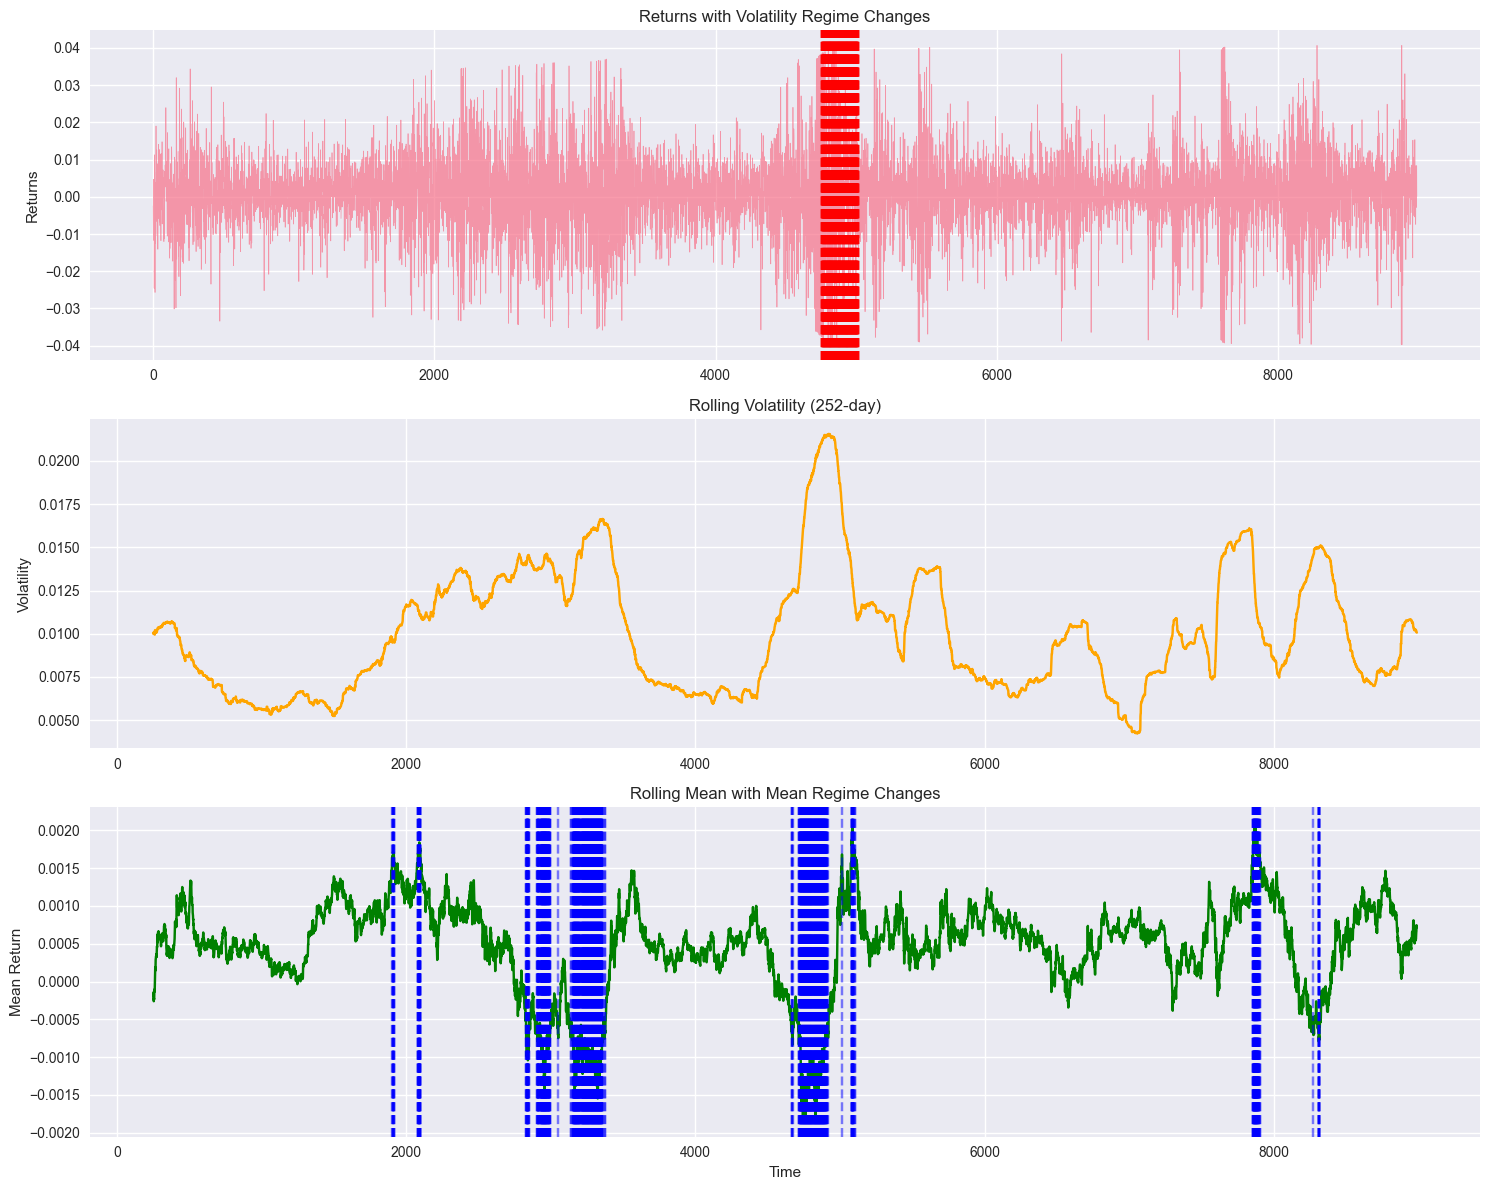


📈 FACTOR LOADING ANALYSIS
Top factor loadings for each factor:

Factor_1:
  V11: 0.8993
  M16: 0.8699
  V1: 0.6386
  P11: 0.6153
  P10: 0.5832

Factor_2:
  P11: -0.6735
  P10: -0.6309
  P2: 0.5356
  S11: 0.4718
  S10: 0.4678

Factor_3:
  V2: 0.7882
  V4: 0.7842
  V3: 0.6383
  P2: 0.5301
  M11: 0.5086

Factor_4:
  E17: -0.8730
  E16: -0.8650
  E18: -0.6384
  I2: 0.4019
  E10: 0.3319

Factor_5:
  I8: 0.8473
  I4: 0.8026
  I7: 0.6481
  M18: -0.6277
  I6: -0.5851


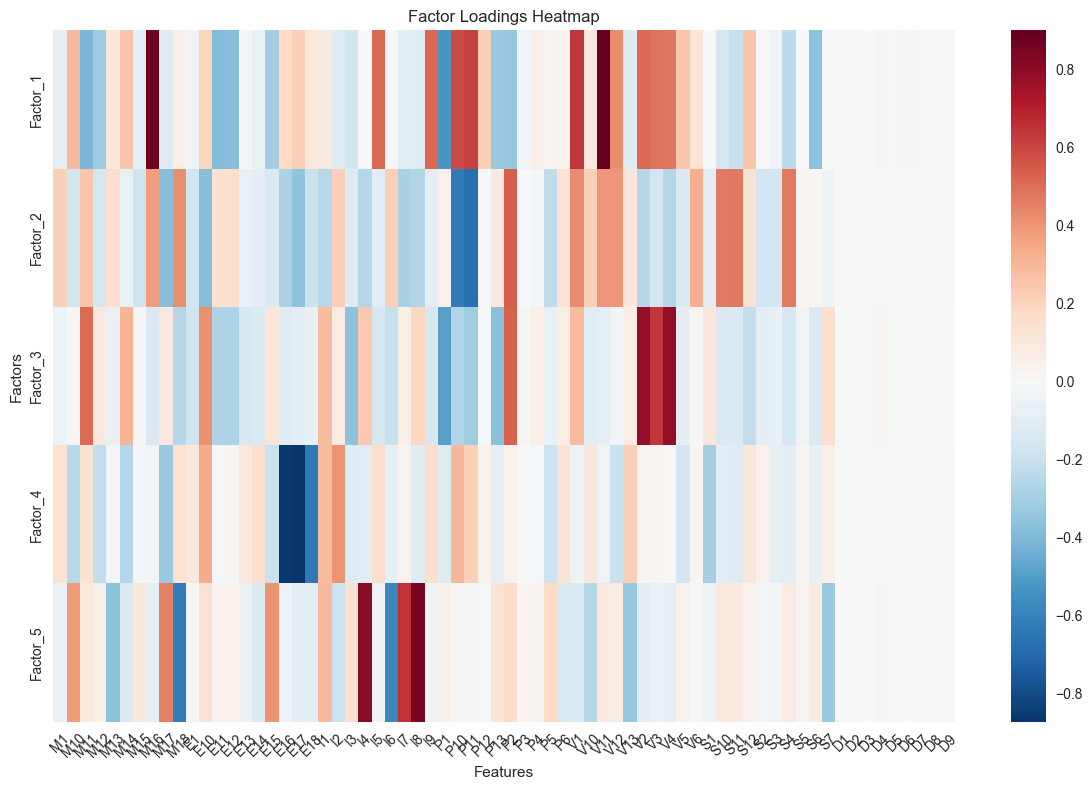


Factor correlations with returns:
Factor_1: -0.0007
Factor_2: 0.0078
Factor_3: 0.0058
Factor_4: -0.0092
Factor_5: 0.0022

🏛️ MARKET MICROSTRUCTURE ANALYSIS
🔍 VOLATILITY CLUSTERING ANALYSIS:
Significant autocorrelations in squared returns: 20/20 lags

📉 LEVERAGE EFFECT ANALYSIS:
Average volatility after positive days: 0.006897
Average volatility after negative days: 0.008287
Leverage ratio (neg/pos): 1.2016

🔮 RETURN PREDICTABILITY PATTERNS:
1-day momentum: -0.044528
5-day momentum: -0.023650
10-day momentum: 0.008513


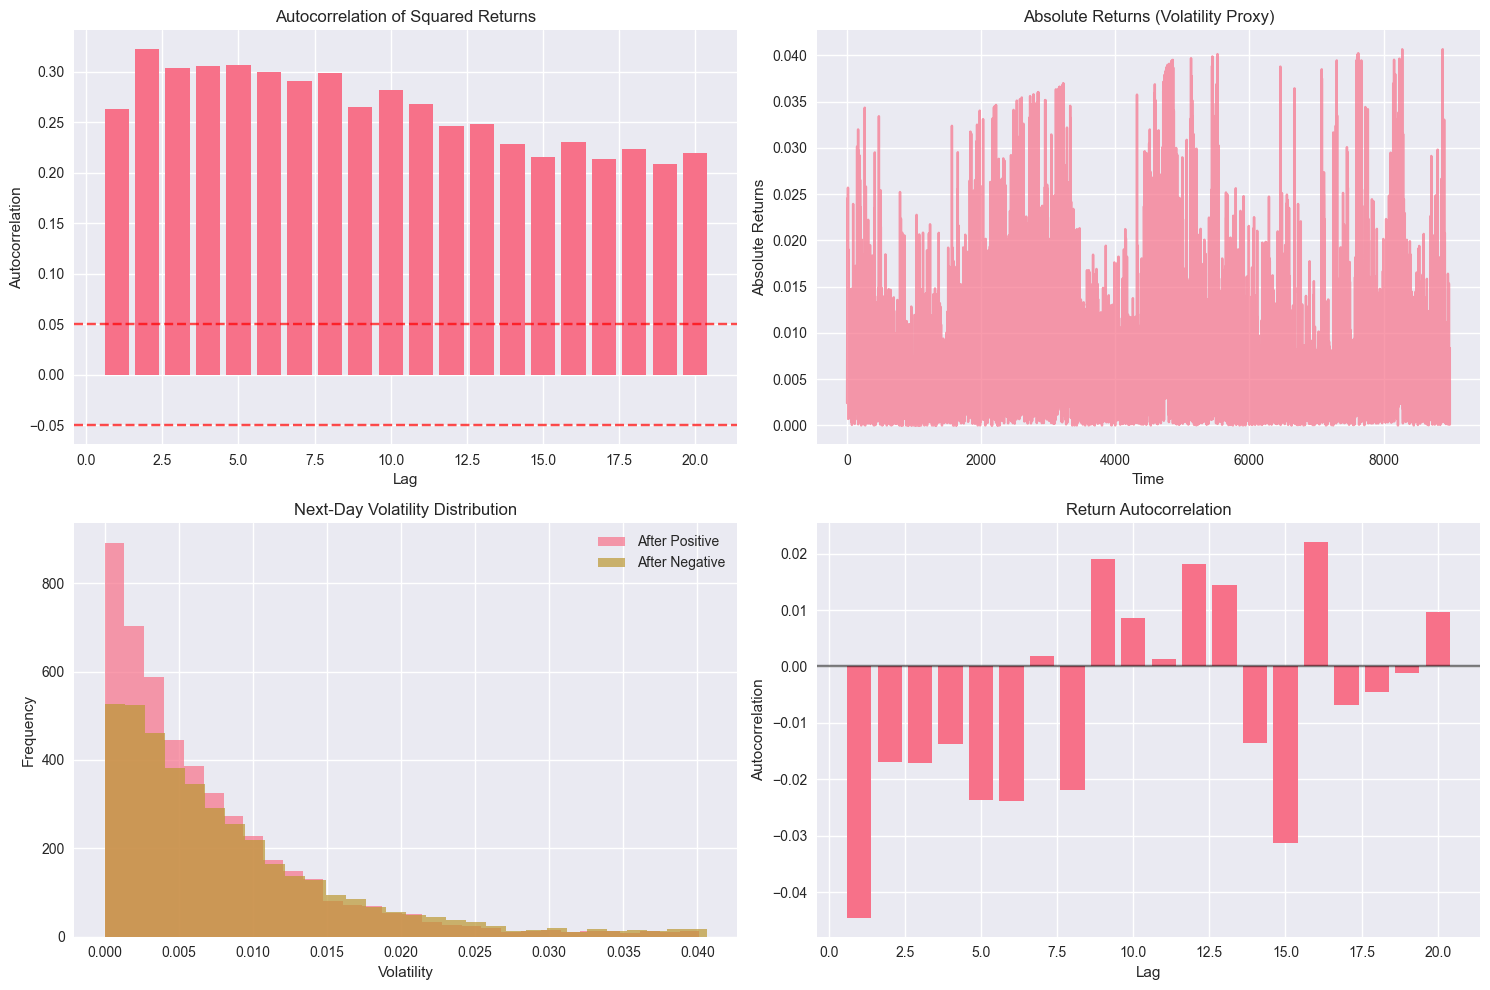


🔗 FEATURE INTERACTION ANALYSIS
🔍 FEATURE INTERACTION EFFECTS:

Top 10 feature interactions by mutual information:
  V1_x_V10: 0.083501
  M1_x_E10: 0.080809
  P11_x_V1: 0.069890
  M1_x_E1: 0.064481
  P10_x_V10: 0.063428
  P10_x_V1: 0.063399
  P11_x_V10: 0.061238
  M10_x_E10: 0.060254
  V1_x_S1: 0.054430
  E10_x_I3: 0.053179

📊 MARKET SEGMENTATION ANALYSIS
🔍 DETERMINING OPTIMAL CLUSTER COUNT:
  k=2: Silhouette Score = 0.1603
  k=3: Silhouette Score = 0.1673
  k=4: Silhouette Score = 0.1544
  k=5: Silhouette Score = 0.1712
  k=6: Silhouette Score = 0.1754
  k=7: Silhouette Score = 0.1795
  k=8: Silhouette Score = 0.1575
  k=9: Silhouette Score = 0.1901
  k=10: Silhouette Score = 0.2166

Optimal number of clusters: 10

📈 CLUSTER CHARACTERISTICS:

Cluster 0 (849 samples):
  Average Return: 0.000423
  Volatility: 0.007936
  Sharpe Ratio: 0.0533

Cluster 1 (2570 samples):
  Average Return: 0.000657
  Volatility: 0.008884
  Sharpe Ratio: 0.0740

Cluster 2 (870 samples):
  Average Return: 0.00

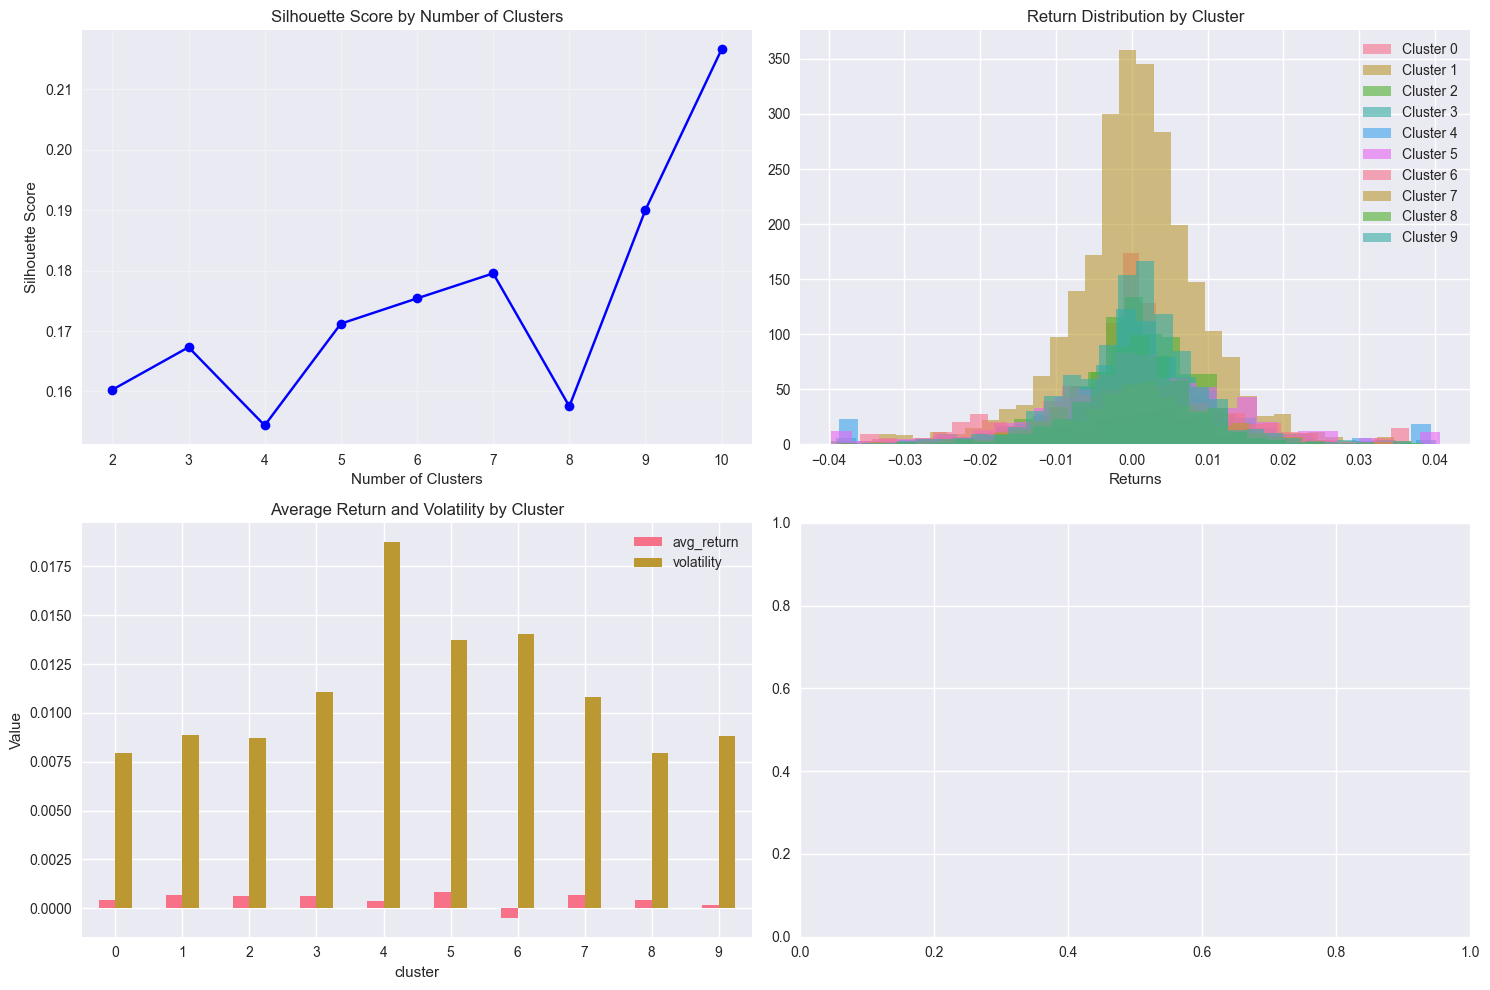


⚙️ ADVANCED FEATURE ENGINEERING INSIGHTS
🔍 NON-LINEARITY DETECTION:
유의미한 비선형 관계 특성 수: 4
  E10: 개선 741.43%
  V11: 개선 183.65%
  I3: 개선 128.58%
  I1: 개선 61.77%

⏰ 시계열 특성 기회:
시계열 특성 권장사항:

🔧 특성 조합 권장사항:
  1. P*(밸류에이션)과 E*(거시) 변수 간 비율 특성 고려
  2. 변동성 보정 모멘텀: M*를 V*로 나눈 비율
  3. 센티먼트 가중 지표: S*에 시장 스트레스 지표 가중
  4. 금리 기울기: 만기가 다른 I* 간 차이
  5. 상대 강도 지표: 카테고리 내 순위 기반 변환

✅ 고급 EDA 스위트 완료


In [18]:

# These functions extend existing analysis with sophisticated financial modeling techniques

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy import stats
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

# 1. REGIME DETECTION AND STRUCTURAL BREAKS
def detect_regime_changes(df, window=252, threshold=2.0):
    """
    Detect structural breaks and market regimes using rolling statistics
    and Chow test approximations
    """
    print("\n📊 REGIME DETECTION AND STRUCTURAL BREAKS")
    print("="*60)
    
    if 'forward_returns' not in df.columns or 'date_id' not in df.columns:
        print("❌ Required columns missing")
        return None
    
    df_sorted = df.sort_values('date_id')
    returns = df_sorted['forward_returns'].dropna()
    
    # Rolling volatility and mean
    rolling_vol = returns.rolling(window=window).std()
    rolling_mean = returns.rolling(window=window).mean()
    
    # Detect volatility regime changes
    vol_zscore = (rolling_vol - rolling_vol.mean()) / rolling_vol.std()
    vol_breaks = vol_zscore[abs(vol_zscore) > threshold].index
    
    # Detect mean reversion regime changes
    mean_zscore = (rolling_mean - rolling_mean.mean()) / rolling_mean.std()
    mean_breaks = mean_zscore[abs(mean_zscore) > threshold].index
    
    print(f"Detected {len(vol_breaks)} volatility regime changes")
    print(f"Detected {len(mean_breaks)} mean regime changes")
    
    # Visualize regime changes
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Returns with regime markers
    axes[0].plot(returns.index, returns.values, alpha=0.7, linewidth=0.5)
    for break_point in vol_breaks:
        axes[0].axvline(x=break_point, color='red', alpha=0.5, linestyle='--')
    axes[0].set_title('Returns with Volatility Regime Changes')
    axes[0].set_ylabel('Returns')
    
    # Rolling volatility
    axes[1].plot(rolling_vol.index, rolling_vol.values, color='orange')
    axes[1].set_title('Rolling Volatility (252-day)')
    axes[1].set_ylabel('Volatility')
    
    # Rolling mean
    axes[2].plot(rolling_mean.index, rolling_mean.values, color='green')
    for break_point in mean_breaks:
        axes[2].axvline(x=break_point, color='blue', alpha=0.5, linestyle='--')
    axes[2].set_title('Rolling Mean with Mean Regime Changes')
    axes[2].set_ylabel('Mean Return')
    axes[2].set_xlabel('Time')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'vol_breaks': vol_breaks,
        'mean_breaks': mean_breaks,
        'rolling_vol': rolling_vol,
        'rolling_mean': rolling_mean
    }

# 2. FACTOR EXPOSURE AND LOADING ANALYSIS
def analyze_factor_loadings(df, feature_categories, n_factors=5):
    """
    Perform factor analysis to understand underlying factor structure
    and exposure to common risk factors
    """
    print("\n📈 FACTOR LOADING ANALYSIS")
    print("="*60)
    
    # Prepare feature matrix
    feature_cols = []
    for category, features in feature_categories.items():
        if category != 'Special':
            feature_cols.extend(features[:10])  # Limit for computational efficiency
    
    X = df[feature_cols].fillna(df[feature_cols].median())
    
    if 'forward_returns' in df.columns:
        y = df['forward_returns'].fillna(0)
    else:
        print("❌ No target variable found")
        return None
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Factor Analysis using PCA as proxy
    from sklearn.decomposition import PCA, FactorAnalysis
    
    try:
        # Factor Analysis
        fa = FactorAnalysis(n_components=n_factors, random_state=42)
        factors = fa.fit_transform(X_scaled)
        
        # Calculate factor loadings
        loadings = fa.components_.T
        
        # Create loadings DataFrame
        loadings_df = pd.DataFrame(
            loadings, 
            index=feature_cols[:loadings.shape[0]], 
            columns=[f'Factor_{i+1}' for i in range(n_factors)]
        )
        
        print(f"Top factor loadings for each factor:")
        for i in range(n_factors):
            factor_name = f'Factor_{i+1}'
            top_loadings = loadings_df[factor_name].abs().nlargest(5)
            print(f"\n{factor_name}:")
            for feature, loading in top_loadings.items():
                print(f"  {feature}: {loadings_df.loc[feature, factor_name]:.4f}")
        
        # Visualize factor loadings heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(loadings_df.T, cmap='RdBu_r', center=0, 
                   xticklabels=True, yticklabels=True)
        plt.title('Factor Loadings Heatmap')
        plt.xlabel('Features')
        plt.ylabel('Factors')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Analyze factor exposure to returns
        factor_returns_corr = np.corrcoef(factors.T, y)[:-1, -1]
        
        print(f"\nFactor correlations with returns:")
        for i, corr in enumerate(factor_returns_corr):
            print(f"Factor_{i+1}: {corr:.4f}")
        
        return {
            'factors': factors,
            'loadings': loadings_df,
            'factor_returns_corr': factor_returns_corr
        }
        
    except Exception as e:
        print(f"❌ 팩터 분석 실패: {e}")
        return None

# 3. MARKET MICROSTRUCTURE ANALYSIS
def analyze_microstructure(df):
    """
    Analyze market microstructure effects like volatility clustering,
    leverage effects, and return predictability patterns
    """
    print("\n🏛️ MARKET MICROSTRUCTURE ANALYSIS")
    print("="*60)
    
    if 'forward_returns' not in df.columns:
        print("❌ No returns data for microstructure analysis")
        return None
    
    df_sorted = df.sort_values('date_id')
    returns = df_sorted['forward_returns'].dropna()
    
    # 1. Volatility Clustering (ARCH effects)
    returns_squared = returns ** 2
    
    # Test for ARCH effects using Ljung-Box test on squared returns
    from scipy.stats import jarque_bera
    
    print("🔍 VOLATILITY CLUSTERING ANALYSIS:")
    
    # Calculate autocorrelations of squared returns
    sq_autocorrs = [returns_squared.autocorr(lag=i) for i in range(1, 21)]
    significant_lags = sum([1 for ac in sq_autocorrs if abs(ac) > 0.05])
    print(f"Significant autocorrelations in squared returns: {significant_lags}/20 lags")
    
    # 2. Leverage Effect Analysis
    print("\n📉 LEVERAGE EFFECT ANALYSIS:")
    
    # Split returns into positive and negative
    pos_returns = returns[returns > 0]
    neg_returns = returns[returns < 0]
    
    # Calculate next-day volatility after positive/negative days
    if len(returns) > 1:
        next_vol_after_pos = []
        next_vol_after_neg = []
        
        for i in range(len(returns) - 1):
            if returns.iloc[i] > 0:
                next_vol_after_pos.append(abs(returns.iloc[i + 1]))
            elif returns.iloc[i] < 0:
                next_vol_after_neg.append(abs(returns.iloc[i + 1]))
        
        if next_vol_after_pos and next_vol_after_neg:
            avg_vol_after_pos = np.mean(next_vol_after_pos)
            avg_vol_after_neg = np.mean(next_vol_after_neg)
            
            print(f"Average volatility after positive days: {avg_vol_after_pos:.6f}")
            print(f"Average volatility after negative days: {avg_vol_after_neg:.6f}")
            print(f"Leverage ratio (neg/pos): {avg_vol_after_neg/avg_vol_after_pos:.4f}")
    
    # 3. Return Predictability Patterns
    print("\n🔮 RETURN PREDICTABILITY PATTERNS:")
    
    # Momentum vs Mean Reversion
    momentum_1d = returns.autocorr(lag=1)
    momentum_5d = returns.autocorr(lag=5)
    momentum_10d = returns.autocorr(lag=10)
    
    print(f"1-day momentum: {momentum_1d:.6f}")
    print(f"5-day momentum: {momentum_5d:.6f}")
    print(f"10-day momentum: {momentum_10d:.6f}")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Autocorrelation of squared returns
    axes[0, 0].bar(range(1, len(sq_autocorrs) + 1), sq_autocorrs)
    axes[0, 0].axhline(y=0.05, color='red', linestyle='--', alpha=0.7)
    axes[0, 0].axhline(y=-0.05, color='red', linestyle='--', alpha=0.7)
    axes[0, 0].set_title('Autocorrelation of Squared Returns')
    axes[0, 0].set_xlabel('Lag')
    axes[0, 0].set_ylabel('Autocorrelation')
    
    # Volatility clustering visualization
    abs_returns = abs(returns)
    axes[0, 1].plot(abs_returns.index, abs_returns.values, alpha=0.7)
    axes[0, 1].set_title('Absolute Returns (Volatility Proxy)')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('Absolute Returns')
    
    # Return distribution by sign of previous return
    if next_vol_after_pos and next_vol_after_neg:
        axes[1, 0].hist(next_vol_after_pos, alpha=0.7, label='After Positive', bins=30)
        axes[1, 0].hist(next_vol_after_neg, alpha=0.7, label='After Negative', bins=30)
        axes[1, 0].set_title('Next-Day Volatility Distribution')
        axes[1, 0].legend()
        axes[1, 0].set_xlabel('Volatility')
        axes[1, 0].set_ylabel('Frequency')
    
    # Return autocorrelation
    autocorrs = [returns.autocorr(lag=i) for i in range(1, 21)]
    axes[1, 1].bar(range(1, len(autocorrs) + 1), autocorrs)
    axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[1, 1].set_title('Return Autocorrelation')
    axes[1, 1].set_xlabel('Lag')
    axes[1, 1].set_ylabel('Autocorrelation')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'volatility_clustering': sq_autocorrs,
        'leverage_effect': avg_vol_after_neg/avg_vol_after_pos if 'avg_vol_after_neg' in locals() else None,
        'momentum_effects': [momentum_1d, momentum_5d, momentum_10d]
    }

# 4. FEATURE INTERACTION ANALYSIS
def analyze_feature_interactions(df, feature_categories, top_n=10):
    """
    Analyze non-linear feature interactions and dependencies
    """
    print("\n🔗 FEATURE INTERACTION ANALYSIS")
    print("="*60)
    
    # Select top features from importance analysis
    feature_cols = []
    for category, features in feature_categories.items():
        if category != 'Special':
            feature_cols.extend(features[:3])  # Top 3 from each category
    
    if len(feature_cols) > 20:
        feature_cols = feature_cols[:20]  # Limit for computational efficiency
    
    X = df[feature_cols].fillna(df[feature_cols].median())
    
    if 'forward_returns' in df.columns:
        y = df['forward_returns'].fillna(0)
    else:
        print("❌ No target variable found")
        return None
    
    # Calculate interaction effects
    print("🔍 FEATURE INTERACTION EFFECTS:")
    
    # Mutual information between feature pairs and target
    from sklearn.feature_selection import mutual_info_regression
    
    interaction_scores = {}
    
    # Create interaction features (products of pairs)
    for i in range(len(feature_cols)):
        for j in range(i+1, min(i+5, len(feature_cols))):  # Limit interactions
            feat1, feat2 = feature_cols[i], feature_cols[j]
            interaction_feat = X[feat1] * X[feat2]
            
            # Calculate mutual information with target
            mi_score = mutual_info_regression(
                interaction_feat.values.reshape(-1, 1), 
                y, 
                random_state=42
            )[0]
            
            interaction_scores[f"{feat1}_x_{feat2}"] = mi_score
    
    # Sort and display top interactions
    top_interactions = sorted(interaction_scores.items(), 
                            key=lambda x: x[1], reverse=True)[:top_n]
    
    print(f"\nTop {top_n} feature interactions by mutual information:")
    for interaction, score in top_interactions:
        print(f"  {interaction}: {score:.6f}")
    
    # Visualize interaction heatmap
    if len(feature_cols) <= 10:  # Only for manageable number of features
        interaction_matrix = np.zeros((len(feature_cols), len(feature_cols)))
        
        for i in range(len(feature_cols)):
            for j in range(i+1, len(feature_cols)):
                feat1, feat2 = feature_cols[i], feature_cols[j]
                key = f"{feat1}_x_{feat2}"
                if key in interaction_scores:
                    interaction_matrix[i, j] = interaction_scores[key]
                    interaction_matrix[j, i] = interaction_scores[key]
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(interaction_matrix, 
                   xticklabels=feature_cols, 
                   yticklabels=feature_cols,
                   cmap='viridis', annot=True, fmt='.4f')
        plt.title('Feature Interaction Strength (Mutual Information)')
        plt.tight_layout()
        plt.show()
    
    return {
        'top_interactions': top_interactions,
        'interaction_scores': interaction_scores
    }

# 5. CLUSTERING AND SEGMENTATION ANALYSIS
def perform_market_segmentation(df, feature_categories, n_clusters=5):
    """
    Perform market regime clustering and segmentation analysis
    """
    print("\n📊 MARKET SEGMENTATION ANALYSIS")
    print("="*60)
    
    # Prepare feature matrix for clustering
    feature_cols = []
    for category, features in feature_categories.items():
        if category != 'Special':
            feature_cols.extend(features[:5])  # Top 5 from each category
    
    if len(feature_cols) > 30:
        feature_cols = feature_cols[:30]  # Limit features
    
    X = df[feature_cols].fillna(df[feature_cols].median())
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Determine optimal number of clusters
    print("🔍 DETERMINING OPTIMAL CLUSTER COUNT:")
    
    silhouette_scores = []
    k_range = range(2, min(11, len(X)//100))  # Reasonable range
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"  k={k}: Silhouette Score = {silhouette_avg:.4f}")
    
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"\nOptimal number of clusters: {optimal_k}")
    
    # Perform clustering with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Add cluster labels to dataframe
    df_clustered = df.copy()
    df_clustered['cluster'] = cluster_labels
    
    # Analyze cluster characteristics
    print(f"\n📈 CLUSTER CHARACTERISTICS:")
    
    cluster_stats = []
    for cluster_id in range(optimal_k):
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
        
        if 'forward_returns' in cluster_data.columns:
            returns = cluster_data['forward_returns'].dropna()
            stats_dict = {
                'cluster': cluster_id,
                'size': len(cluster_data),
                'avg_return': returns.mean(),
                'volatility': returns.std(),
                'sharpe': returns.mean() / returns.std() if returns.std() > 0 else 0,
                'min_return': returns.min(),
                'max_return': returns.max()
            }
            cluster_stats.append(stats_dict)
            
            print(f"\nCluster {cluster_id} ({len(cluster_data)} samples):")
            print(f"  Average Return: {stats_dict['avg_return']:.6f}")
            print(f"  Volatility: {stats_dict['volatility']:.6f}")
            print(f"  Sharpe Ratio: {stats_dict['sharpe']:.4f}")
    
    cluster_stats_df = pd.DataFrame(cluster_stats)
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Silhouette scores
    axes[0, 0].plot(k_range, silhouette_scores, 'bo-')
    axes[0, 0].set_title('Silhouette Score by Number of Clusters')
    axes[0, 0].set_xlabel('Number of Clusters')
    axes[0, 0].set_ylabel('Silhouette Score')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Cluster returns distribution
    if 'forward_returns' in df_clustered.columns:
        for cluster_id in range(optimal_k):
            cluster_returns = df_clustered[df_clustered['cluster'] == cluster_id]['forward_returns'].dropna()
            axes[0, 1].hist(cluster_returns, alpha=0.6, label=f'Cluster {cluster_id}', bins=30)
        axes[0, 1].set_title('Return Distribution by Cluster')
        axes[0, 1].set_xlabel('Returns')
        axes[0, 1].legend()
    
    # Cluster characteristics
    if cluster_stats:
        cluster_stats_df.set_index('cluster')[['avg_return', 'volatility']].plot(kind='bar', ax=axes[1, 0])
        axes[1, 0].set_title('Average Return and Volatility by Cluster')
        axes[1, 0].set_ylabel('Value')
        axes[1, 0].tick_params(axis='x', rotation=0)
    
    # t-SNE visualization (if computationally feasible)
    if len(X_scaled) <= 5000:  # Limit for t-SNE
        try:
            tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_scaled)//4))
            X_tsne = tsne.fit_transform(X_scaled)
            
            scatter = axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
            axes[1, 1].set_title('t-SNE Visualization of Clusters')
            axes[1, 1].set_xlabel('t-SNE 1')
            axes[1, 1].set_ylabel('t-SNE 2')
            plt.colorbar(scatter, ax=axes[1, 1])
        except:
            axes[1, 1].text(0.5, 0.5, 't-SNE visualization\nnot available', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'cluster_labels': cluster_labels,
        'cluster_stats': cluster_stats_df,
        'optimal_k': optimal_k,
        'silhouette_scores': silhouette_scores
    }

# 6. ADVANCED FEATURE ENGINEERING INSIGHTS
def advanced_feature_engineering_analysis(df, feature_categories):
    """
    Provide insights for advanced feature engineering
    """
    print("\n⚙️ ADVANCED FEATURE ENGINEERING INSIGHTS")
    print("="*60)
    
    insights = {}
    
    # 1. Non-linearity Detection
    print("🔍 NON-LINEARITY DETECTION:")
    
    if 'forward_returns' in df.columns:
        target = df['forward_returns'].fillna(0)
        
        # Sample features for analysis
        sample_features = []
        for category, features in feature_categories.items():
            if category != 'Special':
                sample_features.extend(features[:3])
        
        if len(sample_features) > 15:
            sample_features = sample_features[:15]
        
        nonlinear_candidates = []
        
        for feature in sample_features:
            if feature in df.columns:
                feat_data = df[feature].fillna(df[feature].median())
                
                # Test polynomial relationship
                try:
                    linear_corr = abs(np.corrcoef(feat_data, target)[0, 1])
                    
                    # Quadratic transformation
                    quad_feat = feat_data ** 2
                    quad_corr = abs(np.corrcoef(quad_feat, target)[0, 1])
                    
                    # Log transformation (if possible)
                    if (feat_data > 0).all():
                        log_feat = np.log(feat_data)
                        log_corr = abs(np.corrcoef(log_feat, target)[0, 1])
                    else:
                        log_corr = 0
                    
                    max_nonlinear_corr = max(quad_corr, log_corr)
                    
                    if max_nonlinear_corr > linear_corr * 1.2:  # 20% improvement
                        nonlinear_candidates.append({
                            'feature': feature,
                            'linear_corr': linear_corr,
                            'best_nonlinear_corr': max_nonlinear_corr,
                            'improvement': (max_nonlinear_corr - linear_corr) / linear_corr
                        })
                
                except:
                    continue
        
        # Sort by improvement
        nonlinear_candidates.sort(key=lambda x: x['improvement'], reverse=True)
        
        print(f"유의미한 비선형 관계 특성 수: {len(nonlinear_candidates)}")
        for candidate in nonlinear_candidates[:5]:
            print(f"  {candidate['feature']}: 개선 {candidate['improvement']:.2%}")
        
        insights['nonlinear_candidates'] = nonlinear_candidates
    
    # 2. Temporal Feature Opportunities
    print("\n⏰ 시계열 특성 기회:")
    
    temporal_insights = []
    
    # Day of week effects
    if 'date_id' in df.columns and 'forward_returns' in df.columns:
        df_temp = df.copy()
        df_temp['day_of_week'] = df_temp['date_id'] % 7
        
        dow_returns = df_temp.groupby('day_of_week')['forward_returns'].mean()
        dow_std = dow_returns.std()
        
        if dow_std > 0.001:  # Significant variation
            temporal_insights.append("요일 효과 감지 — 범주형 인코딩 고려")
    
    # Volatility regime features
    if 'forward_returns' in df.columns:
        returns = df['forward_returns'].fillna(0)
        vol_regime = (returns.rolling(20).std() > returns.rolling(20).std().median()).astype(int)
        regime_corr = abs(np.corrcoef(vol_regime, returns)[0, 1])
        
        if regime_corr > 0.01:
            temporal_insights.append("변동성 레짐 특성이 유용할 수 있음")
    
    print(f"시계열 특성 권장사항:")
    for insight in temporal_insights:
        print(f"  • {insight}")
    
    insights['temporal_insights'] = temporal_insights
    
    # 3. Feature Combination Recommendations
    print("\n🔧 특성 조합 권장사항:")
    
    combination_recs = [
        "P*(밸류에이션)과 E*(거시) 변수 간 비율 특성 고려",
        "변동성 보정 모멘텀: M*를 V*로 나눈 비율", 
        "센티먼트 가중 지표: S*에 시장 스트레스 지표 가중",
        "금리 기울기: 만기가 다른 I* 간 차이",
        "상대 강도 지표: 카테고리 내 순위 기반 변환"
    ]
    
    for i, rec in enumerate(combination_recs, 1):
        print(f"  {i}. {rec}")
    
    insights['combination_recommendations'] = combination_recs
    
    return insights

# Usage example:
def run_advanced_eda_suite(df, feature_categories):
    """
    Run the complete advanced EDA suite
    """
    print("🚀 고급 EDA 스위트 실행")
    print("="*80)
    
    results = {}
    
    try:
        results['regime_analysis'] = detect_regime_changes(df)
    except Exception as e:
        print(f"⚠️ 레짐 분석 실패: {e}")
    
    try:
        results['factor_analysis'] = analyze_factor_loadings(df, feature_categories)
    except Exception as e:
        print(f"⚠️ 팩터 분석 실패: {e}")
    
    try:
        results['microstructure'] = analyze_microstructure(df)
    except Exception as e:
        print(f"⚠️ 마이크로구조 분석 실패: {e}")
    
    try:
        results['interactions'] = analyze_feature_interactions(df, feature_categories)
    except Exception as e:
        print(f"⚠️ 상호작용 분석 실패: {e}")
    
    try:
        results['segmentation'] = perform_market_segmentation(df, feature_categories)
    except Exception as e:
        print(f"⚠️ 세그멘테이션 분석 실패: {e}")
    
    try:
        results['feature_engineering'] = advanced_feature_engineering_analysis(df, feature_categories)
    except Exception as e:
        print(f"⚠️ 특성 공학 분석 실패: {e}")
    
    print("\n✅ 고급 EDA 스위트 완료")
    print("="*80)
    
    return results

# Example usage:
advanced_results = run_advanced_eda_suite(train_df, feature_categories)